# Methods validation using simulations of transcription factor network

Compare methods
- Including latent nodes vs no latent nodes
- Imputation as part of model or outside of model

Accuracy
- Show accuracy of methods

In [6]:
# Load packages
from MScausality.causal_model.LVM import LVM
from MScausality.simulation.simulation import simulate_data
from MScausality.data_analysis.normalization import normalize
from MScausality.data_analysis.dataProcess import dataProcess

import pyro
import pandas as pd
import numpy as np

import networkx as nx
import y0
from y0.algorithm.simplify_latent import simplify_latent_dag

from y0.dsl import Variable
from eliater.regression import summary_statistics, estimate_probabilities, fit_regression, get_adjustment_set
from operator import attrgetter

from scipy.stats import linregress
from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [35]:
def get_std_error(
        graph,
        data,
        treatments,
        outcome,
        _adjustment_set=None):

    treatments = y0.graph._ensure_set(treatments)
    if _adjustment_set:
        adjustment_set = _adjustment_set
    else:
        adjustment_set, _ = get_adjustment_set(graph=graph, treatments=treatments, outcome=outcome)
    variable_set = adjustment_set.union(treatments).difference({outcome})
    variables = sorted(variable_set, key=attrgetter("name"))
    model = linregress(data[[v.name for v in variables]].values.flatten(), data[outcome.name].values)
    
    return model.stderr*np.sqrt(len(data))

def comparison(full_graph, 
               y0_graph, 
               coefficients, 
               int1, int2, 
               outcome,
               obs_data=None,
               training_obs=1000,
               alt_graph=None
               ):
    """
    Compare the results of the full graph with the y0 graph
    
    """

    ## Ground truth
    if obs_data is None:
        obs_data = pd.DataFrame(simulate_data(full_graph, coefficients=coefficients, 
                            add_feature_var=False, n=training_obs, seed=2)
                            ["Protein_data"])

    intervention_low = simulate_data(full_graph, coefficients=coefficients,
                                     intervention=int1, 
                                     add_feature_var=False, n=10000, seed=2)

    intervention_high = simulate_data(full_graph, coefficients=coefficients,
                                     intervention=int2, 
                                     add_feature_var=False, n=10000, seed=2)

    ## Eliator results
    if obs_data.isnull().values.any():
        imputer = KNNImputer(n_neighbors=3)

        # # Impute missing values (the result is a NumPy array, so we need to convert it back to a DataFrame)
        obs_data_eliator = obs_data.copy()
        obs_data_eliator = pd.DataFrame(imputer.fit_transform(obs_data_eliator), columns=obs_data.columns)
        # def impute_with_normal(df):
        #     for col in df.columns:
        #         missing = df[col].isnull()
        #         if missing.any():
        #             # Sample from normal distribution based on column mean and std
        #             df.loc[missing, col] = np.random.normal(df[col].mean(), df[col].std(), missing.sum())
        #     return df
        # obs_data_eliator = impute_with_normal(obs_data_eliator)
    else:
        obs_data_eliator = obs_data.copy()

    eliator_int_low = summary_statistics(
        y0_graph, obs_data_eliator,
        treatments={Variable(list(int1.keys())[0])},
        outcome=Variable(outcome),
        interventions={
            Variable(list(int1.keys())[0]): list(int1.values())[0]})

    eliator_int_high = summary_statistics(
        y0_graph, obs_data_eliator,
        treatments={Variable(list(int2.keys())[0])},
        outcome=Variable(outcome),
        interventions={
            Variable(list(int2.keys())[0]): list(int2.values())[0]})
    
    eliator_std_error = get_std_error(
        y0_graph, obs_data_eliator, 
        treatments={Variable(list(int2.keys())[0])}, 
        outcome=Variable(outcome))


    ## MScausality results
    if alt_graph is None:
        alt_graph = y0_graph
    pyro.clear_param_store()

    transformed_data = normalize(obs_data, wide_format=True)
    input_data = transformed_data["df"]
    scale_metrics = transformed_data["adj_metrics"]

    lvm = LVM(input_data, alt_graph)
    lvm.prepare_graph()
    lvm.prepare_data()
    lvm.fit_model(num_steps=10000)

    # lvm.intervention(int1, outcome)
    # mscausality_int_low = lvm.intervention_samples
    # lvm.intervention(int2, outcome)
    # mscausality_int_high = lvm.intervention_samples
    lvm.intervention({list(int1.keys())[0]: (list(int1.values())[0] - scale_metrics["mean"]) / scale_metrics["std"]}, outcome)
    mscausality_int_low = lvm.intervention_samples
    lvm.intervention({list(int2.keys())[0]: (list(int2.values())[0] - scale_metrics["mean"]) / scale_metrics["std"]}, outcome)
    mscausality_int_high = lvm.intervention_samples
    
    
    mscausality_int_low = (mscausality_int_low*scale_metrics["std"]) + scale_metrics["mean"]
    mscausality_int_high = (mscausality_int_high*scale_metrics["std"]) + scale_metrics["mean"]

    ## Comparison plots
    fig, ax = plt.subplots(3,1, figsize=(8,8))
    fig.tight_layout()
    
    ax[0].hist(intervention_low["Protein_data"][outcome], alpha=.75, bins=20)
    ax[0].hist(intervention_high["Protein_data"][outcome], alpha=.75, bins=20)
    ax[0].axvline(np.mean(intervention_low["Protein_data"][outcome]), 
                  color="darkblue", linestyle="dashed", lw=4)
    ax[0].axvline(np.mean(intervention_high["Protein_data"][outcome]), 
                  color="darkred", linestyle="dashed", lw=4)
    ax[0].set_title("Ground truth")

    ax[1].hist(np.random.normal(eliator_int_low.mean, eliator_std_error, 10000), 
               alpha=.75, bins=20)
    ax[1].hist(np.random.normal(eliator_int_high.mean, eliator_std_error, 10000), 
               alpha=.75, bins=20)
    ax[1].axvline(np.mean(intervention_low["Protein_data"][outcome]), 
                  color="darkblue", linestyle="dashed", lw=4)
    ax[1].axvline(np.mean(intervention_high["Protein_data"][outcome]), 
                  color="darkred", linestyle="dashed", lw=4)
    ax[1].set_title("Eliator")

    ax[2].hist(mscausality_int_low, alpha=.75, bins=20)
    ax[2].hist(mscausality_int_high, alpha=.75, bins=20)
    ax[2].axvline(np.mean(intervention_low["Protein_data"][outcome]), 
                  color="darkblue", linestyle="dashed", lw=4)
    ax[2].axvline(np.mean(intervention_high["Protein_data"][outcome]), 
                  color="darkred", linestyle="dashed", lw=4)
    ax[2].set_title("MScausality")

    ax[0].set_xlim(-10,10)
    ax[1].set_xlim(-10,10)
    ax[2].set_xlim(-10,10)

    result_df = pd.DataFrame({
        "Ground_truth": [np.mean(intervention_low["Protein_data"][outcome]), 
                         np.mean(intervention_high["Protein_data"][outcome])],
        "Ground_truth_std": [np.std(intervention_low["Protein_data"][outcome]), 
                             np.std(intervention_high["Protein_data"][outcome])],
        "Eliator": [eliator_int_low.mean, eliator_int_high.mean],
        "Eliator_std": [eliator_std_error, eliator_std_error],
        "MScausality": [np.mean(np.array(mscausality_int_low)), 
                        np.mean(np.array(mscausality_int_high))],
        "MScausality_std": [np.std(np.array(mscausality_int_low)), 
                            np.std(np.array(mscausality_int_high))]
    })

    return result_df

    

# Latent variable model vs regression

## Simple Regression

In [62]:
def build_sr_network():
    """
    Create TF MYC graph in networkx
    
    """
    graph = nx.DiGraph()

    ## Add edges
    graph.add_edge("IL6", "MYC")
    
    return graph

def build_sr_admg(graph):

    """

    Creates acyclic directed mixed graph (ADMG) from networkx graph with latent variables.
    
    """

    ## Define obs vs latent nodes
    all_nodes = ["IL6", "MYC"]
    obs_nodes = ["IL6", "MYC"]
            
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}

    nx.set_node_attributes(graph, attrs, name="hidden")
    
    ## Use y0 to build ADMG
    mapping = dict(zip(list(graph.nodes), 
                      [Variable(i) for i in list(graph.nodes)]))
    graph = nx.relabel_nodes(graph, mapping)
    
    ## Use y0 to build ADMG
    simplified_graph = simplify_latent_dag(graph.copy(), tag="hidden")
    y0_graph = y0.graph.NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(simplified_graph.graph, "hidden")
    
    return y0_graph

In [63]:
sr_graph = build_sr_network()
y0_sr_graph = build_sr_admg(sr_graph)

In [66]:
## Coefficients for relations
# sr_coef = {'STAT3': {'intercept': 0, "error": 1},
#             'MYC': {'intercept': 2, "error": .25, 'STAT3': 1.}}
sr_coef = {'IL6': {'intercept': 6, "error": 1},
            'MYC': {'intercept': 2, "error": .25, 'IL6': 1.}}

simulating data...
simulating data...
simulating data...
Step 0: Loss = 1065.9144097473472
Step 100: Loss = -269.08605509996414
Step 200: Loss = -659.751949340105
Step 300: Loss = -822.4939948320389
Step 400: Loss = -910.8907623589039
Step 500: Loss = -996.0531293153763
Step 600: Loss = -1060.9197906255722
Step 700: Loss = -1100.954879373312
Step 800: Loss = -1145.829118669033
Step 900: Loss = -1144.914663285017
Step 1000: Loss = -1190.4298485517502
Step 1100: Loss = -1215.722734004259
Stopping early at step 1149 with loss -1211.1432645618916


Ground_truth  Ground_truth_std   Eliator  Eliator_std  MScausality  \
0      7.004485          0.251902  7.015879     0.233839     6.994071   
1      9.004485          0.251902  8.997016     0.233839     8.975492   

   MScausality_std  
0         0.265262  
1         0.260379

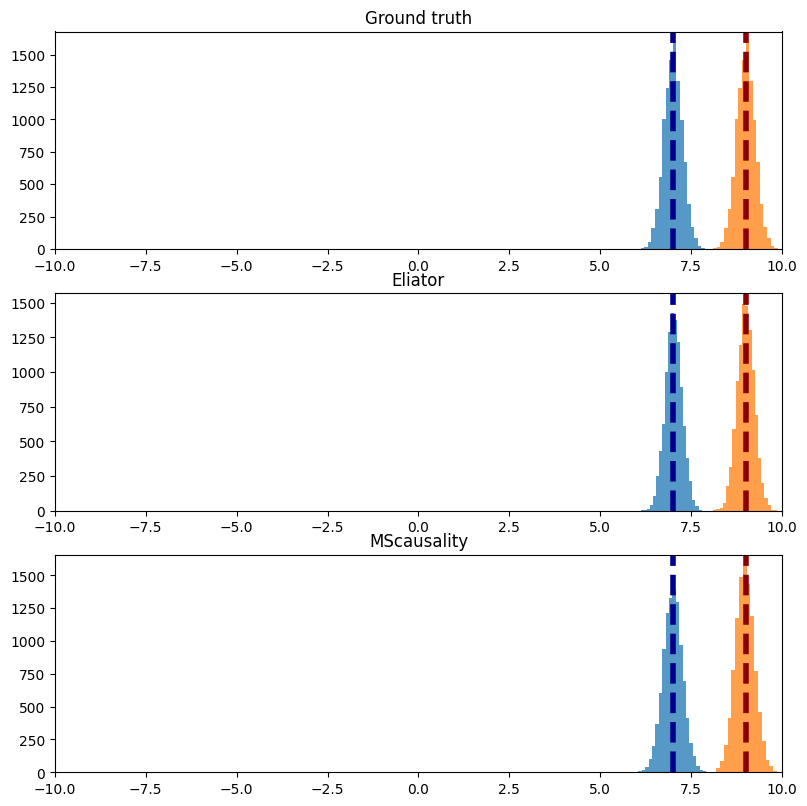

In [67]:
comparison(sr_graph, y0_sr_graph, sr_coef, {"IL6": 5}, 
           {"IL6": 7}, "MYC", training_obs=200)

## Mediator

In [45]:
def build_tf_med_network():
    """
    Create TF MYC graph in networkx
    
    """
    graph = nx.DiGraph()

    ## Add edges
    graph.add_edge("IL6", "STAT3")
    graph.add_edge("STAT3", "MYC")
    
    return graph

def build_med_admg(graph):

    """

    Creates acyclic directed mixed graph (ADMG) from networkx graph with latent variables.
    
    """

    ## Define obs vs latent nodes
    all_nodes = ["IL6", "STAT3", "MYC"]
    obs_nodes = ["IL6", "STAT3", "MYC"]
            
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}

    nx.set_node_attributes(graph, attrs, name="hidden")
    
    ## Use y0 to build ADMG
    mapping = dict(zip(list(graph.nodes), 
                      [Variable(i) for i in list(graph.nodes)]))
    graph = nx.relabel_nodes(graph, mapping)
    
    ## Use y0 to build ADMG
    simplified_graph = simplify_latent_dag(graph.copy(), tag="hidden")
    y0_graph = y0.graph.NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(simplified_graph.graph, "hidden")
    
    return y0_graph

In [46]:
med_graph = build_tf_med_network()
y0_med_graph = build_med_admg(med_graph)

In [47]:
## Coefficients for relations
med_coef = {'IL6': {'intercept': 6, "error": 1.},
            'STAT3': {'intercept': 1.6, "error": .25,  'IL6': 0.5},
              'MYC': {'intercept': 2, "error": .25, 'STAT3': 1.}
              }

simulating data...
simulating data...
simulating data...
Step 0: Loss = 814.0287779048085
Step 100: Loss = -182.0986661836505
Step 200: Loss = -470.6648276373744
Step 300: Loss = -598.0711401775479
Step 400: Loss = -661.077899383381
Step 500: Loss = -718.9144815206528
Step 600: Loss = -774.1813282519579
Step 700: Loss = -798.5461848974228
Step 800: Loss = -823.7201204001904
Stopping early at step 895 with loss -825.2973107397556


Ground_truth  Ground_truth_std   Eliator  Eliator_std  MScausality  \
0      2.602243           0.35274  2.733529      0.36933     2.527611   
1      4.602243           0.35274  4.658131      0.36933     4.518209   

   MScausality_std  
0         0.444577  
1         0.399787

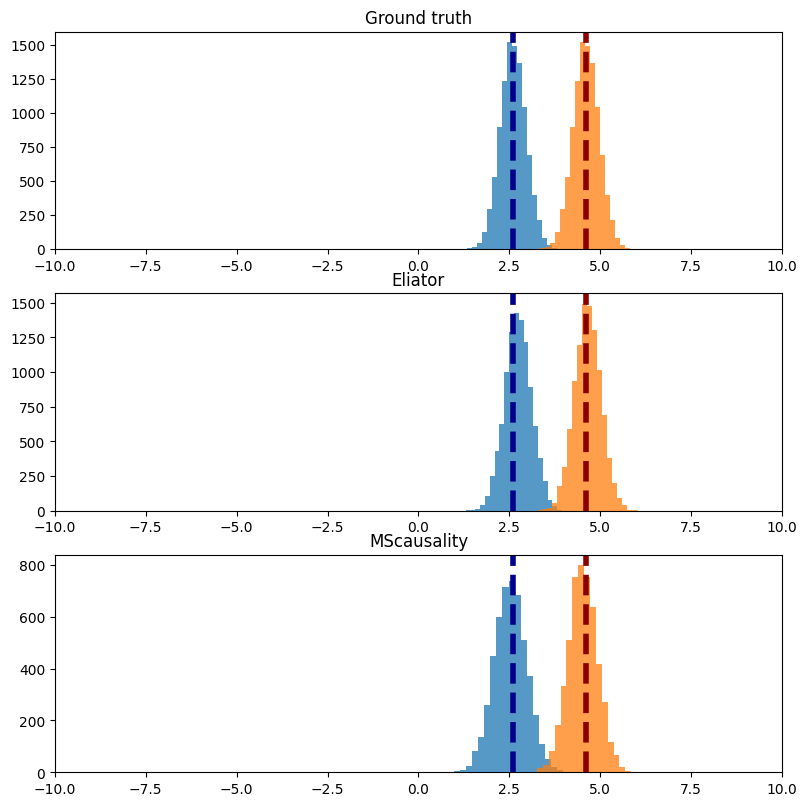

In [48]:
comparison(med_graph, y0_med_graph, med_coef, {'IL6': -2}, {'IL6': 2}, "MYC", training_obs=100)

## Mediator with latent

In [49]:
def build_tf_med_lat_network():
    """
    Create TF MYC graph in networkx
    
    """
    graph = nx.DiGraph()

    ## Add edges
    graph.add_edge("IL6", "STAT3")
    graph.add_edge("STAT3", "MYC")
    
    graph.add_edge("C1", "STAT3")
    graph.add_edge("C1", "MYC")
    
    return graph

def build_med_lat_admg(graph):

    """

    Creates acyclic directed mixed graph (ADMG) from networkx graph with latent variables.
    
    """

    ## Define obs vs latent nodes
    all_nodes = ["IL6", "STAT3", "MYC", "C1"]
    obs_nodes = ["IL6", "STAT3", "MYC"]
            
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}

    nx.set_node_attributes(graph, attrs, name="hidden")
    
    ## Use y0 to build ADMG
    mapping = dict(zip(list(graph.nodes), 
                      [Variable(i) for i in list(graph.nodes)]))
    graph = nx.relabel_nodes(graph, mapping)
    
    ## Use y0 to build ADMG
    simplified_graph = simplify_latent_dag(graph.copy(), tag="hidden")
    y0_graph = y0.graph.NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(simplified_graph.graph, "hidden")
    
    return y0_graph

alt_graph = y0.graph.NxMixedGraph()
alt_graph.add_directed_edge("IL6", "MYC")

In [50]:
med_lat_graph = build_tf_med_lat_network()
y0_med_lat_graph = build_med_lat_admg(med_lat_graph)

In [51]:
## Coefficients for relations
med_lat_coef = {'IL6': {'intercept': 6, "error": 1.},
            'C1': {'intercept': 0, "error": 1.},
            'STAT3': {'intercept': 1.6, "error": .25, 'IL6': 0.5, 'C1': .35},
            'MYC': {'intercept': 2, "error": .25, 'STAT3': 1., 'C1': .35}
              }

simulating data...
simulating data...
simulating data...
Step 0: Loss = 1009.6254719626158
Step 100: Loss = -320.47797271609306
Step 200: Loss = -580.8953213989735
Step 300: Loss = -735.4455085992813
Step 400: Loss = -830.623497903347
Step 500: Loss = -877.2354270815849
Step 600: Loss = -895.4808497130871
Step 700: Loss = -959.2840018868446
Step 800: Loss = -991.0827164649963
Step 900: Loss = -1016.8952932357788
Step 1000: Loss = -1034.753680050373
Step 1100: Loss = -1058.7905599474907
Stopping early at step 1164 with loss -1049.1018074154854


Ground_truth  Ground_truth_std   Eliator  Eliator_std  MScausality  \
0      2.613218          0.788609  3.074163     0.842476     2.756216   
1      4.613218          0.788609  4.885856     0.842476     4.749307   

   MScausality_std  
0         0.905656  
1         0.912331

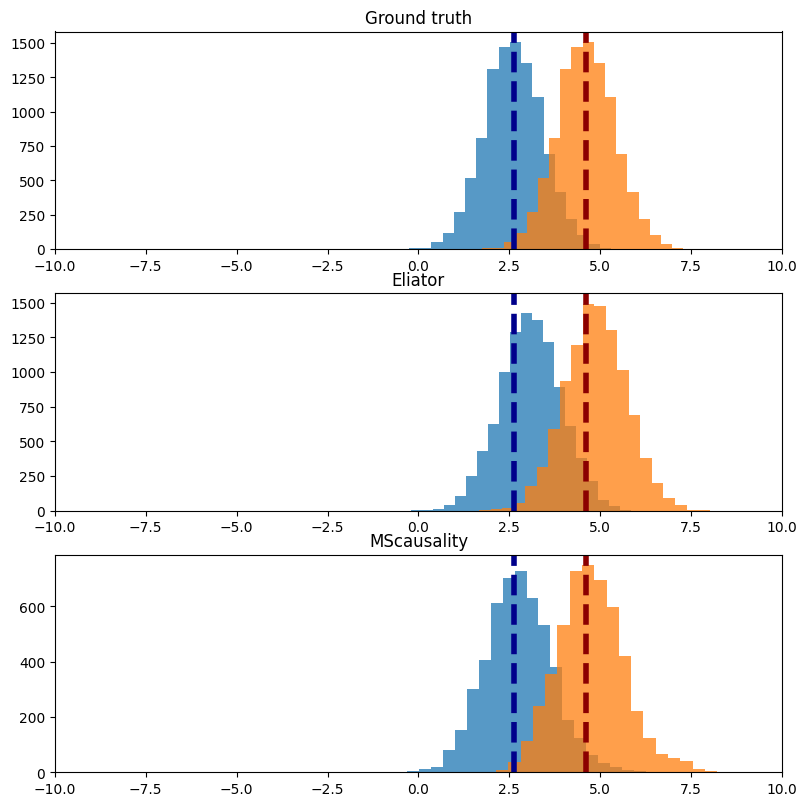

In [52]:
comparison(med_lat_graph, y0_med_lat_graph, med_lat_coef, {'IL6': -2}, {'IL6': 2}, "MYC", training_obs=100)

## More latents!

In [53]:
def build_tf_med_more_lat_network():
    """
    Create TF MYC graph in networkx
    
    """
    graph = nx.DiGraph()

    ## Add edges
    graph.add_edge("IL6", "STAT3")
    graph.add_edge("STAT3", "M2")
    graph.add_edge("M2", "MYC")
    
    graph.add_edge("C1", "STAT3")
    graph.add_edge("C1", "MYC")
    graph.add_edge("C2", "M2")
    graph.add_edge("C2", "MYC")
    
    return graph

def build_med_more_lat_admg(graph):

    """

    Creates acyclic directed mixed graph (ADMG) from networkx graph with latent variables.
    
    """

    ## Define obs vs latent nodes
    all_nodes = ["IL6", "STAT3", "M2", "MYC", "C1", "C2"]
    obs_nodes = ["IL6", "STAT3", "M2", "MYC"]
            
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}

    nx.set_node_attributes(graph, attrs, name="hidden")
    
    ## Use y0 to build ADMG
    mapping = dict(zip(list(graph.nodes), 
                      [Variable(i) for i in list(graph.nodes)]))
    graph = nx.relabel_nodes(graph, mapping)
    
    ## Use y0 to build ADMG
    simplified_graph = simplify_latent_dag(graph.copy(), tag="hidden")
    y0_graph = y0.graph.NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(simplified_graph.graph, "hidden")
    
    return y0_graph

med_more_lat_graph = build_tf_med_more_lat_network()
y0_more_med_lat_graph = build_med_more_lat_admg(med_more_lat_graph)

## Coefficients for relations
med_more_lat_coef = {'IL6': {'intercept': 0, "error": 1.},
            'C1': {'intercept': 0, "error": 1.},
            'C2': {'intercept': 0, "error": 1.},
            'STAT3': {'intercept': 1.6, "error": .25, 'IL6': 0.5, 'C1': .35},
            'M2': {'intercept': 1.6, "error": .25, 'STAT3': 0.5, 'C2': .6},
            'MYC': {'intercept': 2, "error": .25, 'M2': 1., 'C1': .35, 'C2':.6}
              }

simulating data...
simulating data...
simulating data...
Step 0: Loss = 3937.622374652885
Step 100: Loss = -674.250563621521
Step 200: Loss = -1663.5362588763237
Step 300: Loss = -2117.512371689081
Step 400: Loss = -2355.837092667818
Step 500: Loss = -2531.7904413938522
Step 600: Loss = -2679.6769704520702
Step 700: Loss = -2794.6987269818783
Step 800: Loss = -2883.454954624176
Step 900: Loss = -2995.0013480186462
Step 1000: Loss = -3050.5600802004337
Step 1100: Loss = -3111.537637412548
Step 1200: Loss = -3187.653555572033
Step 1300: Loss = -3227.8199532926083
Step 1400: Loss = -3306.5716447234154
Step 1500: Loss = -3346.9880135059357
Step 1600: Loss = -3374.2827855944633
Step 1700: Loss = -3417.230492979288
Step 1800: Loss = -3467.203764051199
Step 1900: Loss = -3471.3239775896072
Step 2000: Loss = -3519.0474931299686
Step 2100: Loss = -3572.3859564960003
Step 2200: Loss = -3543.895445674658
Step 2300: Loss = -3613.5361619889736
Step 2400: Loss = -3665.850988805294
Step 2500: Loss = 

Ground_truth  Ground_truth_std   Eliator  Eliator_std  MScausality  \
0      3.897529           1.35684  3.813367     1.249237     3.414066   
1      4.897529           1.35684  4.629113     1.249237     4.946893   

   MScausality_std  
0         1.351712  
1         1.335427

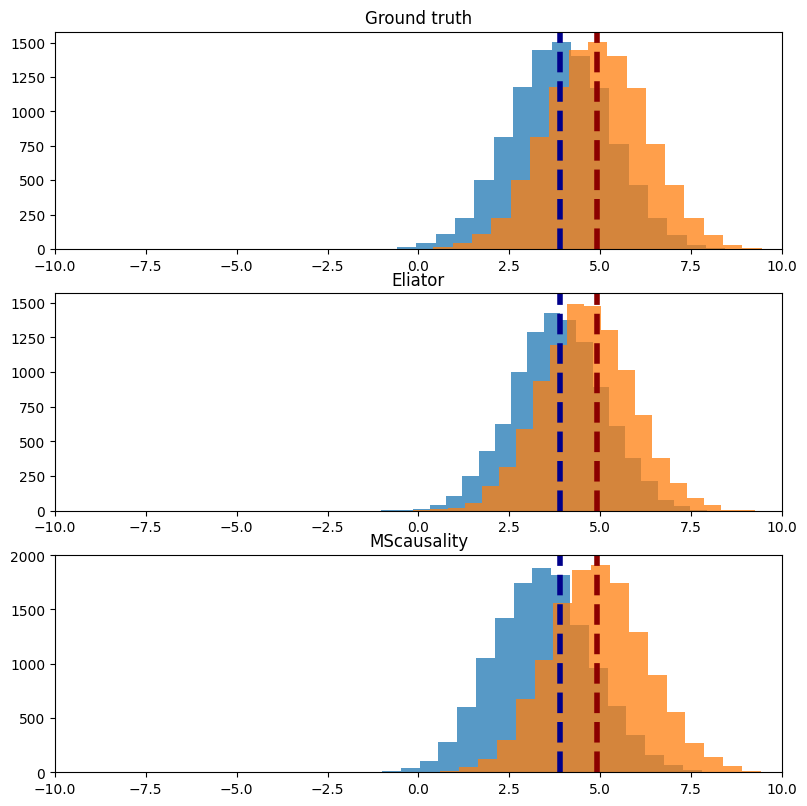

In [54]:
comparison(med_more_lat_graph, y0_more_med_lat_graph, med_more_lat_coef, 
           {'IL6': -2}, {'IL6': 2}, "MYC", training_obs=250)

## Mediator with latent confounder

In [55]:
def build_tf_med_lat_network():
    """
    Create TF MYC graph in networkx
    
    """
    graph = nx.DiGraph()

    ## Add edges
    graph.add_edge("IL6", "STAT3")
    graph.add_edge("STAT3", "MYC")
    
    graph.add_edge("C1", "IL6")
    graph.add_edge("C1", "MYC")
    
    return graph

def build_admg(graph):

    """

    Creates acyclic directed mixed graph (ADMG) from networkx graph with latent variables.
    
    """

    ## Define obs vs latent nodes
    all_nodes = ["IL6", "STAT3", "MYC", "C1"]
    obs_nodes = ["IL6", "STAT3", "MYC"]
            
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}

    nx.set_node_attributes(graph, attrs, name="hidden")
    
    ## Use y0 to build ADMG
    mapping = dict(zip(list(graph.nodes), 
                      [Variable(i) for i in list(graph.nodes)]))
    graph = nx.relabel_nodes(graph, mapping)
    
    ## Use y0 to build ADMG
    simplified_graph = simplify_latent_dag(graph.copy(), tag="hidden")
    y0_graph = y0.graph.NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(simplified_graph.graph, "hidden")
    
    return y0_graph

confound_lat_graph = build_tf_med_lat_network()
confound_lat_y0_graph = build_admg(confound_lat_graph)

## Coefficients for relations
confound_lat_coef = {
            'C1': {'intercept': 0, "error": 1.},
            'IL6': {'intercept': 0, "error": 1., 'C1': .9},
            'STAT3': {'intercept': 1.6, "error": .25, 'IL6': 0.5},
            'MYC': {'intercept': 2, "error": .25, 'STAT3': 1., 'C1': .9}
              }

alt_graph = y0.graph.NxMixedGraph()
alt_graph.add_directed_edge("IL6", "STAT3")
alt_graph.add_directed_edge("STAT3", "MYC")
alt_graph.add_directed_edge("IL6", "MYC")
alt_graph.add_undirected_edge("IL6", "MYC")

In [56]:
comparison(confound_lat_graph, confound_lat_y0_graph, confound_lat_coef, 
           {'IL6': -2}, {'IL6': 2}, "MYC", training_obs=1000, alt_graph=None)

simulating data...
simulating data...
simulating data...


ValueError: No valid adjustment set found for IL6 -> MYC

simulating data...
simulating data...
simulating data...
Step 0: Loss = 17391.347883095965
Step 100: Loss = -240.22616556286812
Step 200: Loss = -3172.6533222198486
Stopping early at step 281 with loss -4229.448123335838
         parameter         mean         scale
0    IL6_intercept  0.027472159   0.042093765
1        IL6_scale    0.2558112    0.02109838
2  STAT3_intercept    1.6054231    0.00995552
3   STAT3_IL6_coef    0.4997218  0.0073701697
4      STAT3_scale    -1.394317   0.027122784
5    MYC_intercept    1.7927781   0.027407428
6   MYC_STAT3_coef     1.010574   0.015180261
7     MYC_IL6_coef   0.46519786   0.016857618
8        MYC_scale  -0.36957818   0.024572663


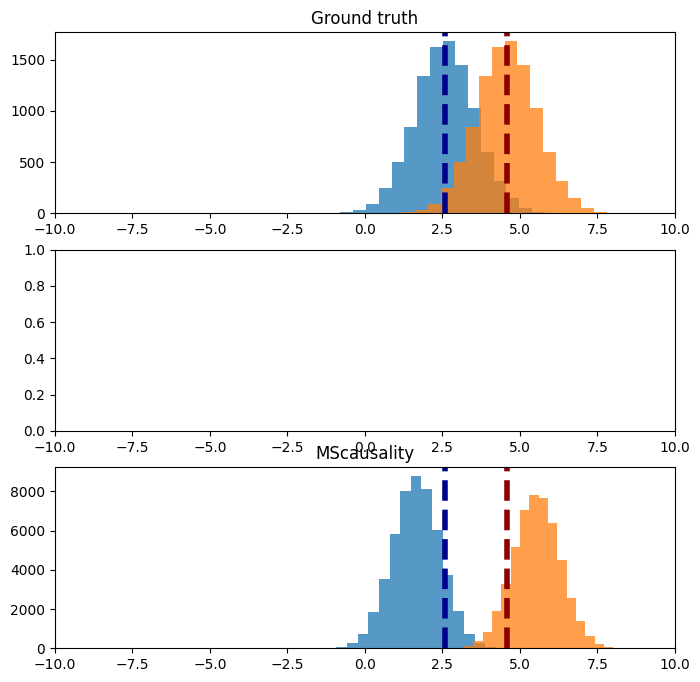

In [214]:
comparison(confound_lat_graph, confound_lat_y0_graph, confound_lat_coef, 
           {'IL6': -2}, {'IL6': 2}, "MYC", training_obs=1000, alt_graph=alt_graph)

- Why isnt Eliator working with mediator adj
- Fix MScausality model to work with mediator

In [225]:
obs_data = pd.DataFrame(simulate_data(confound_lat_graph, coefficients=confound_lat_coef, 
                        add_feature_var=False, n=1000, seed=2)["Protein_data"])

eliator_int_low = summary_statistics(
    confound_lat_y0_graph, obs_data,
    treatments={Variable('IL6'), Variable('STAT3')},
    outcome=Variable("MYC"),
    interventions={
        Variable('IL6'): -2})

simulating data...


MultipleTreatmentsNotImplementedError: 

In [236]:
    from y0.dsl import Variable, X, Y
    from eliater.frontdoor_backdoor import example1
    from eliater.regression import estimate_query_by_linear_regression

    graph = example1.graph
    data = example1.generate(100, seed=100)

    estimate_query_by_linear_regression(
        graph=graph,
        data=data,
        treatments={X},
        outcome=Y,
        query_type="ate"
    )

ValueError: No valid adjustment set found for X -> Y

In [234]:
graph.directed.edges

OutEdgeView([(X, M1), (M1, M2), (M2, Y)])

In [235]:
graph.undirected.edges

EdgeView([(X, Y)])

# Imputation as part of model vs before

## Simple regression

In [15]:
sr_data = simulate_data(sr_graph, coefficients=sr_coef, 
                        add_feature_var=True, n=30, seed=2)
sr_data["Feature_data"].to_csv("../../data/methods_paper_data/tf_sim/simple_regression_feature_data.csv", index=False)

sr_data = dataProcess(sr_data["Feature_data"], normalization=False, sim_data=True)
sr_data.head()

simulating data...
adding feature level data...
masking data...
TODO: imputation


STAT3        MYC
0  5.239732   7.175601
1  6.207944   8.132700
2  7.948698  10.144584
3  5.698029   7.234140
4  4.538564   6.974494

simulating data...
simulating data...
Step 0: Loss = 164.80479199578986
Step 100: Loss = -17.112510979175568
Step 200: Loss = -79.05416290462017
Step 300: Loss = -110.30441182851791
Step 400: Loss = -121.97460666298866
Step 500: Loss = -129.49760681390762
Stopping early at step 514 with loss -136.3834332227707


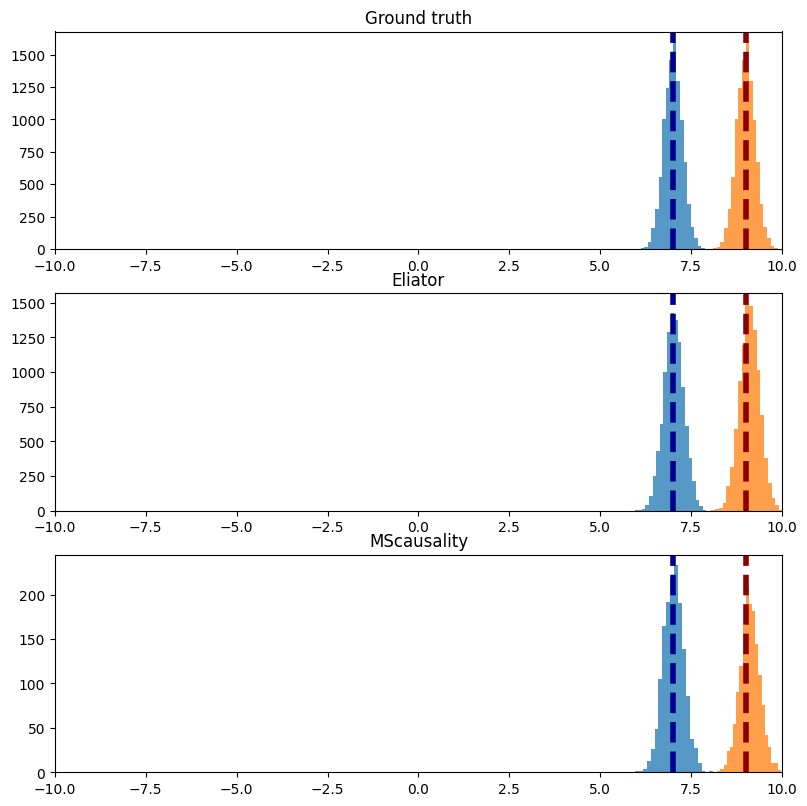

In [22]:
result_data = comparison(sr_graph, y0_sr_graph, sr_coef, {"STAT3": 5}, 
           {"STAT3": 7}, "MYC", obs_data=sr_data)

In [ ]:
def benchmark_comparison(full_graph, y0_graph, coef, replicates):
    eliate_ate = list()
    mscausality_ate = list()
    eliate_var = list()
    mscausality_var = list()

    for i in range(replicates):

        sr_data = simulate_data(full_graph, coefficients=coef, 
                                add_feature_var=True, n=30, seed=i)

        sr_data = dataProcess(sr_data["Feature_data"], normalization=False, sim_data=True)
        
        result_data = comparison(full_graph, y0_graph, coef, {"IL6": 5}, 
            {"IL6": 7}, "MYC", obs_data=sr_data)

        eliate_ate.append(result_data.loc[1, "Eliator"] - result_data.loc[0, "Eliator"])
        mscausality_ate.append(result_data.loc[1, "MScausality"] - result_data.loc[0, "MScausality"])
        eliate_var.append(result_data.loc[1, "Eliator_std"])
        mscausality_var.append(result_data.loc[1, "MScausality_std"])

    return {"eliate_ate": eliate_ate, "mscausality_ate": mscausality_ate,
            "eliate_var": eliate_var, "mscausality_var": mscausality_var}

simulating data...
adding feature level data...
masking data...
TODO: imputation
simulating data...
simulating data...
Step 0: Loss = 166.92798573663458
Step 100: Loss = 5.48088414222002
Step 200: Loss = -56.929339341819286
Step 300: Loss = -85.59986764937639
Step 400: Loss = -98.46003073453903
Step 500: Loss = -105.32582984864712
Step 600: Loss = -113.920923858881
Stopping early at step 616 with loss -120.56304220110178
simulating data...
adding feature level data...
masking data...
TODO: imputation
simulating data...
simulating data...
Step 0: Loss = 165.0232825963758
Step 100: Loss = -23.09505322575569
Step 200: Loss = -85.31227761507034
Step 300: Loss = -118.08976230025291
Step 400: Loss = -129.45946139097214
Step 500: Loss = -136.15814131498337
Stopping early at step 514 with loss -143.42381271719933
simulating data...
adding feature level data...
masking data...
TODO: imputation
simulating data...
simulating data...
Step 0: Loss = 164.80479199578986
Step 100: Loss = -17.112510979

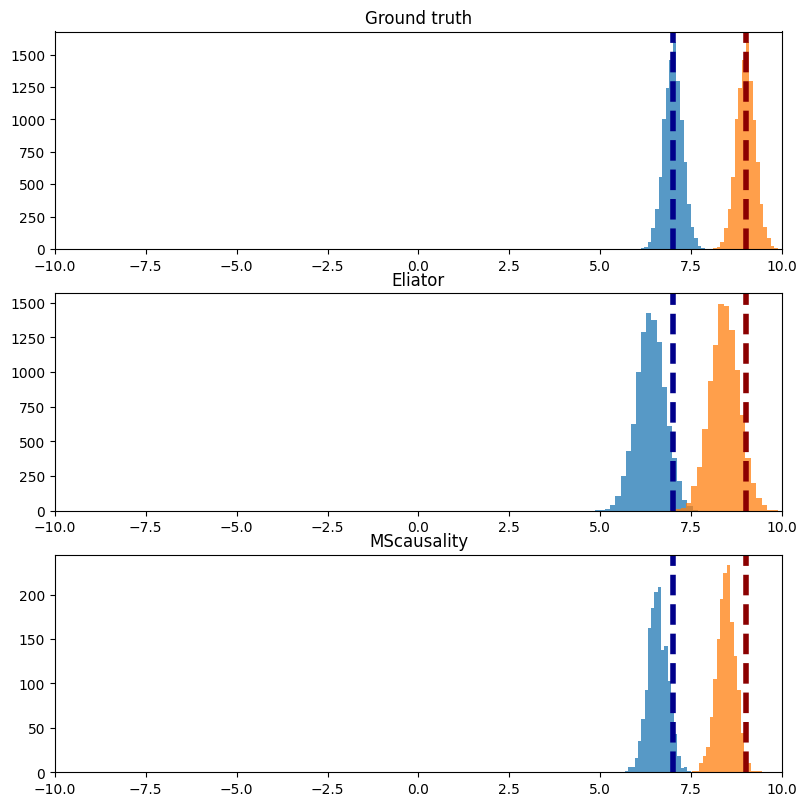

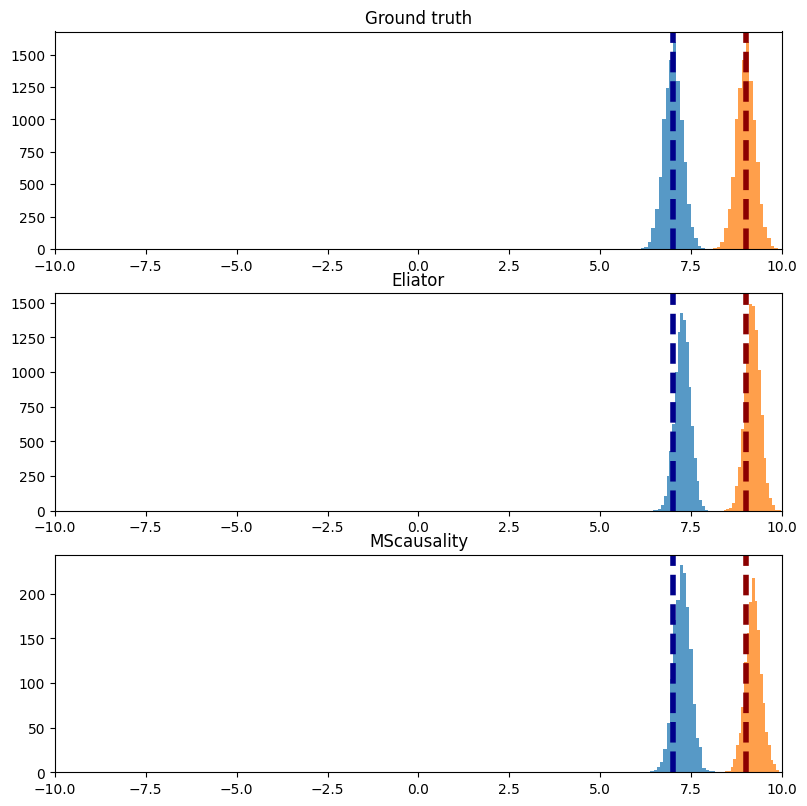

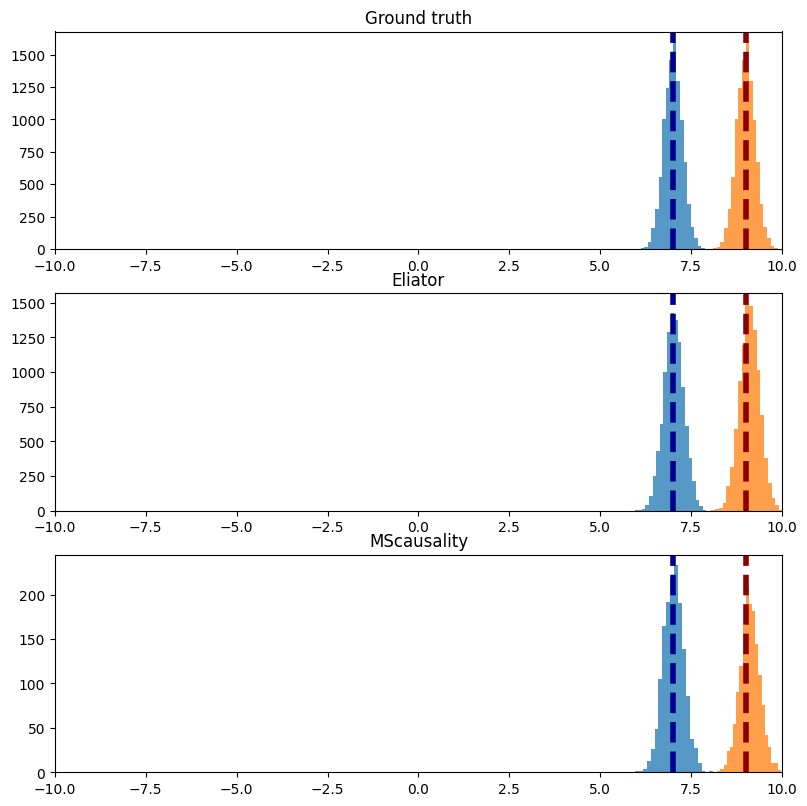

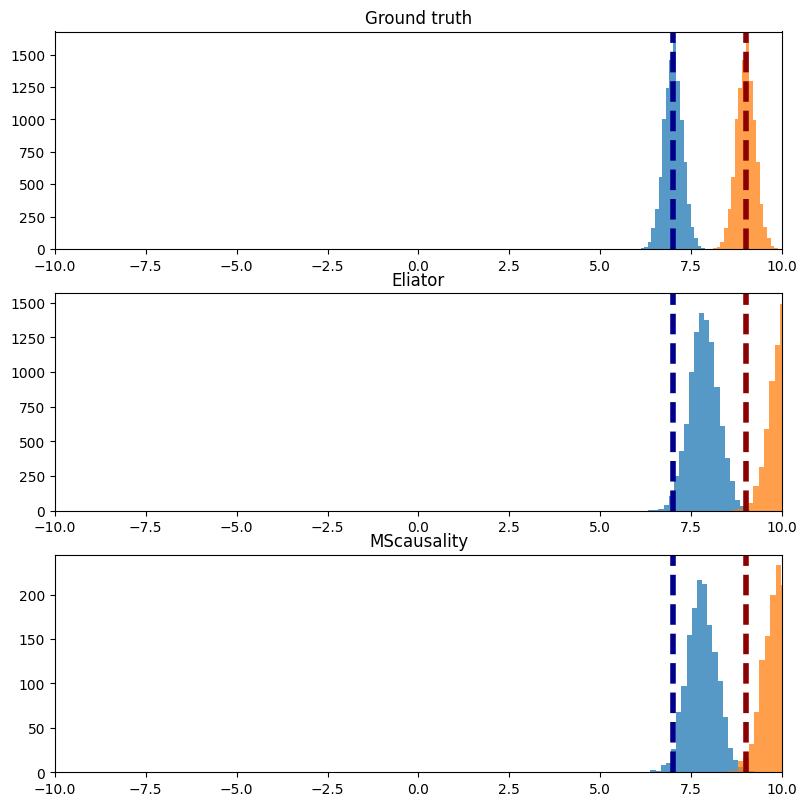

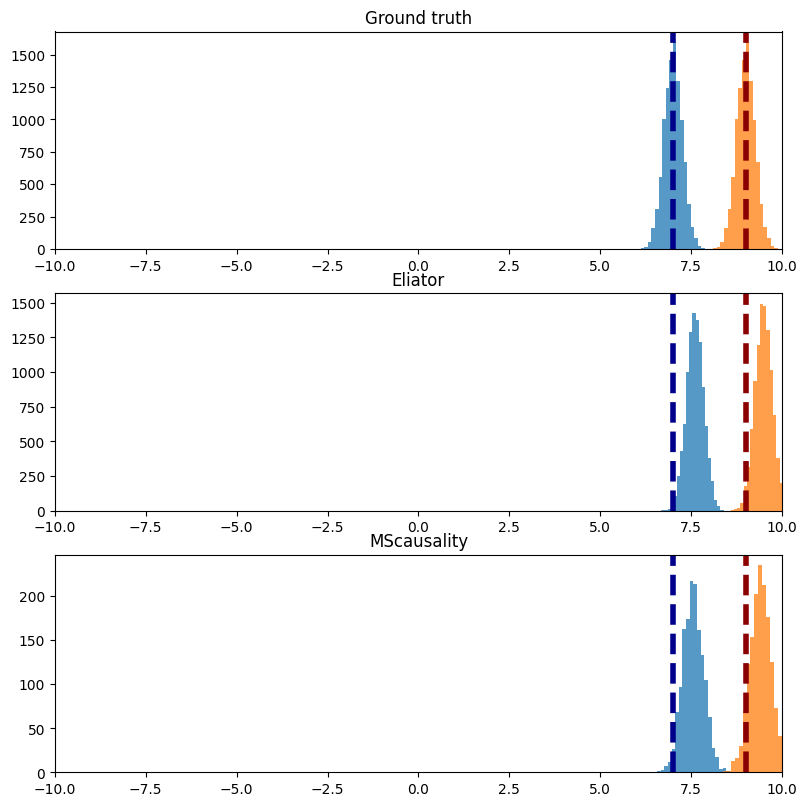

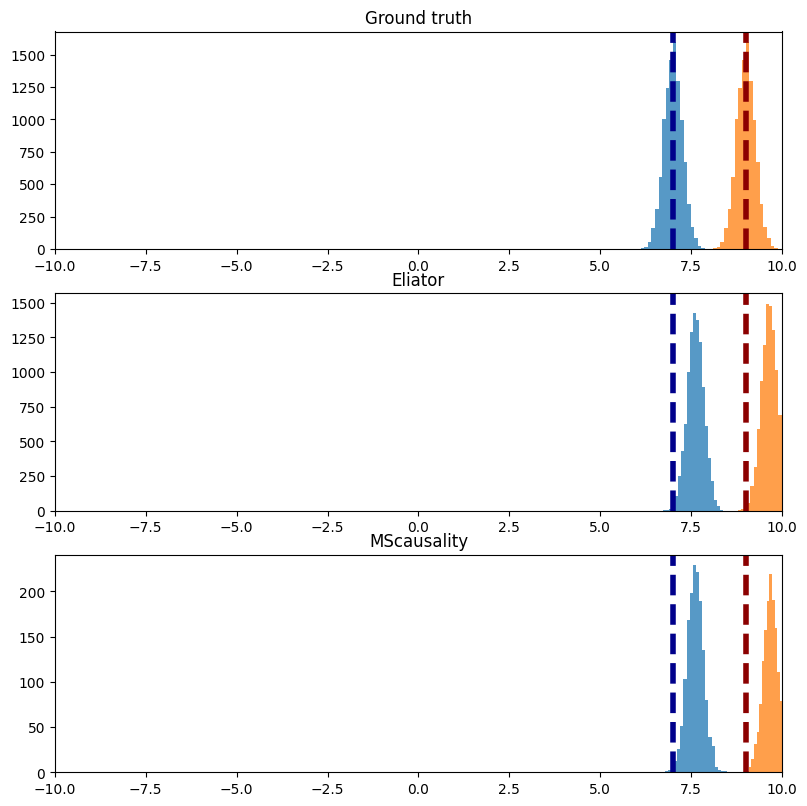

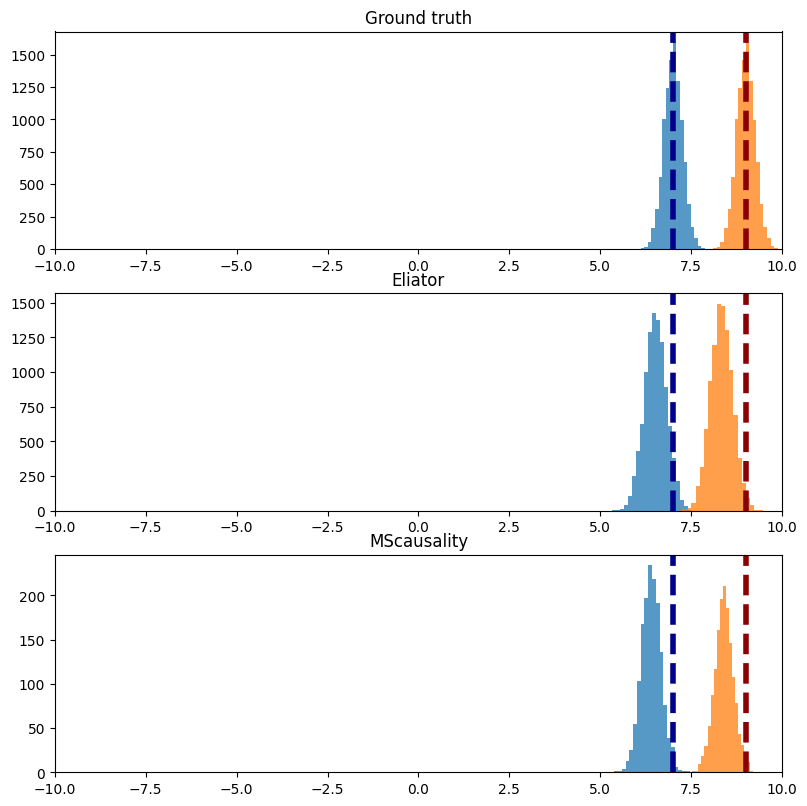

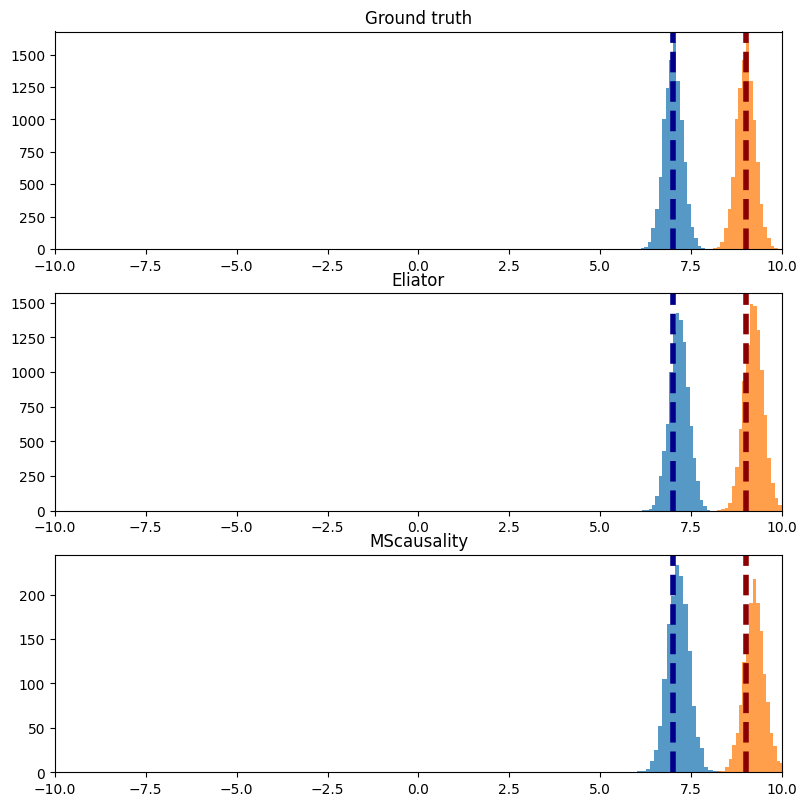

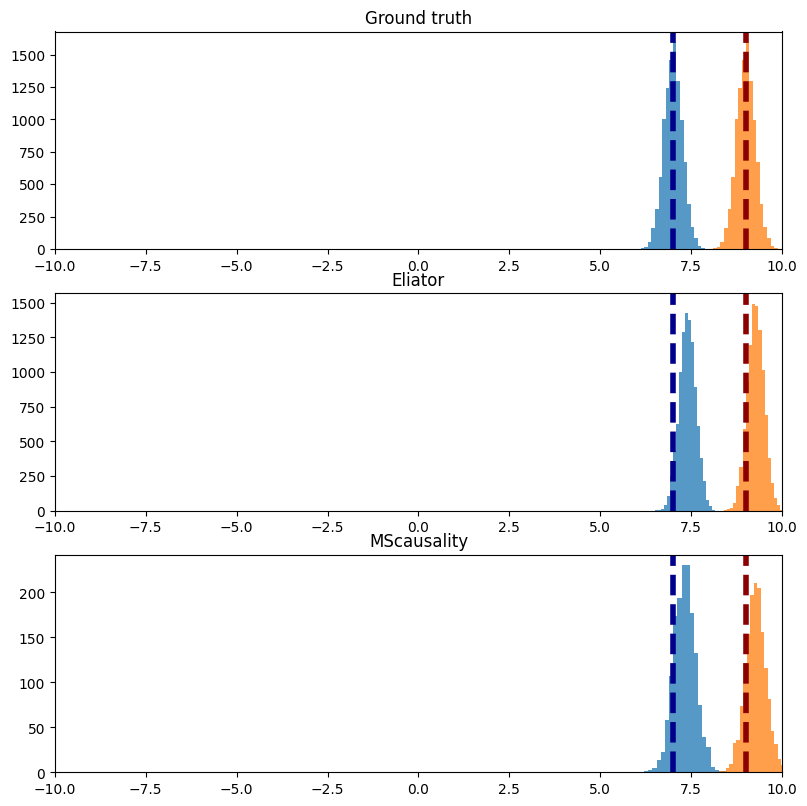

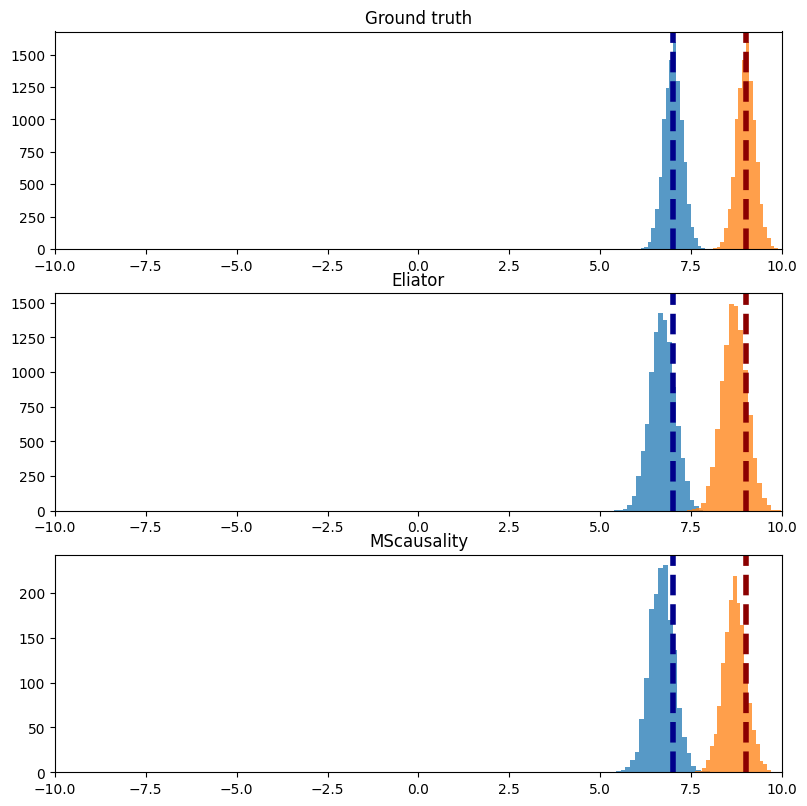

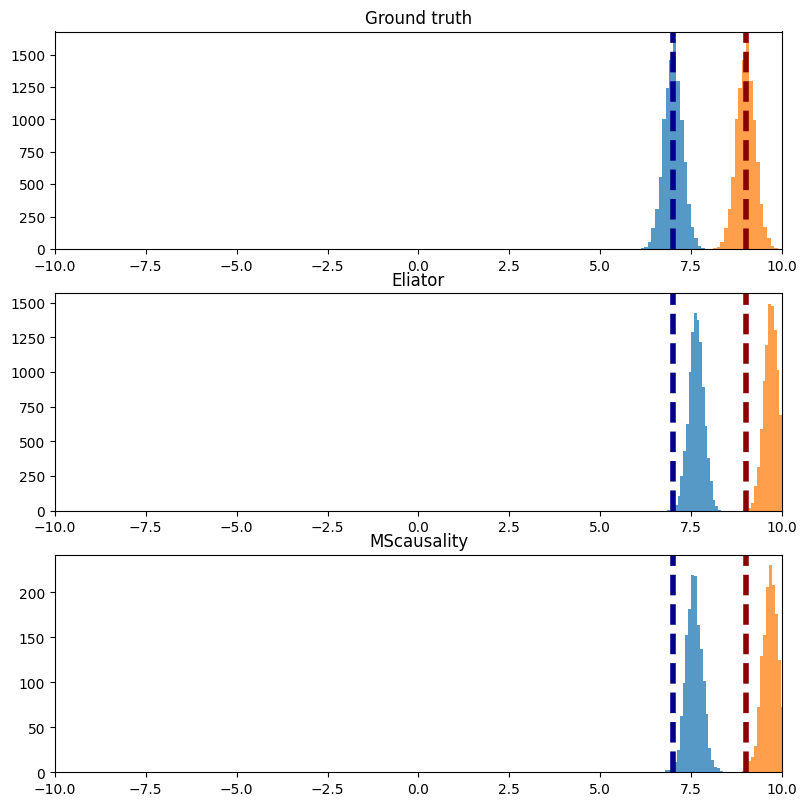

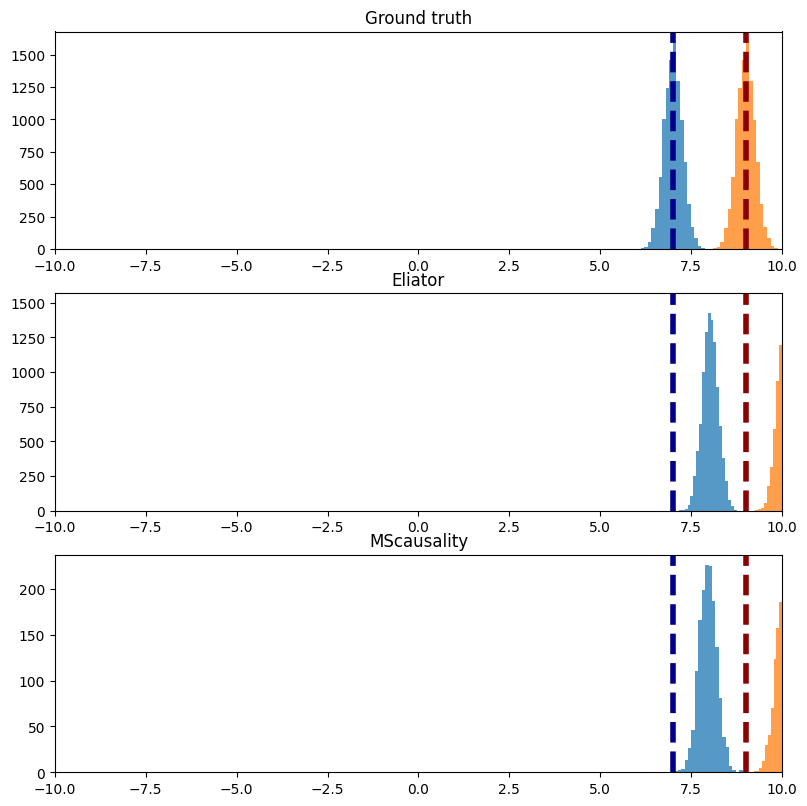

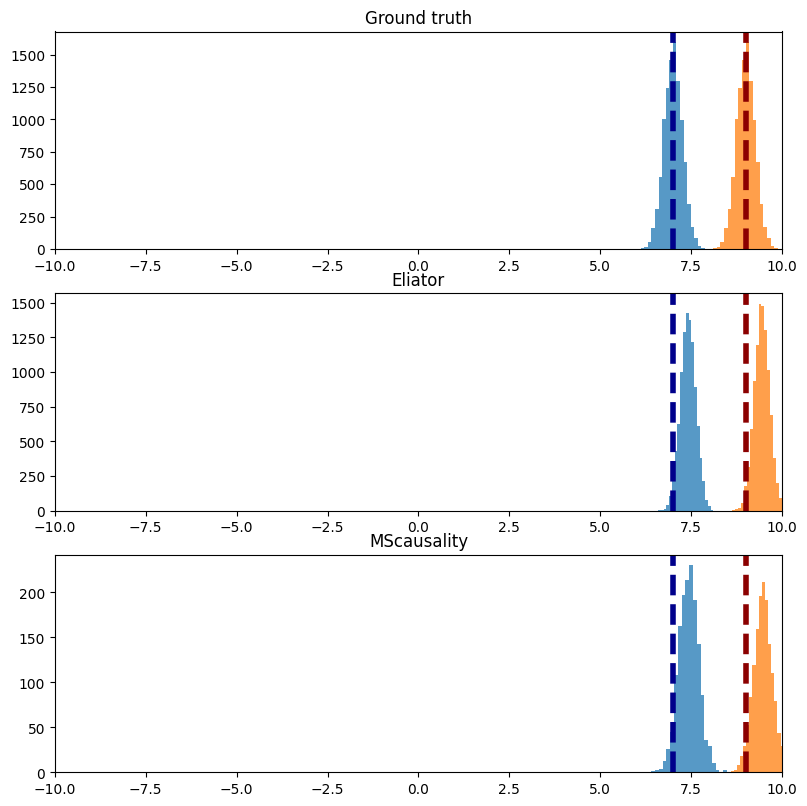

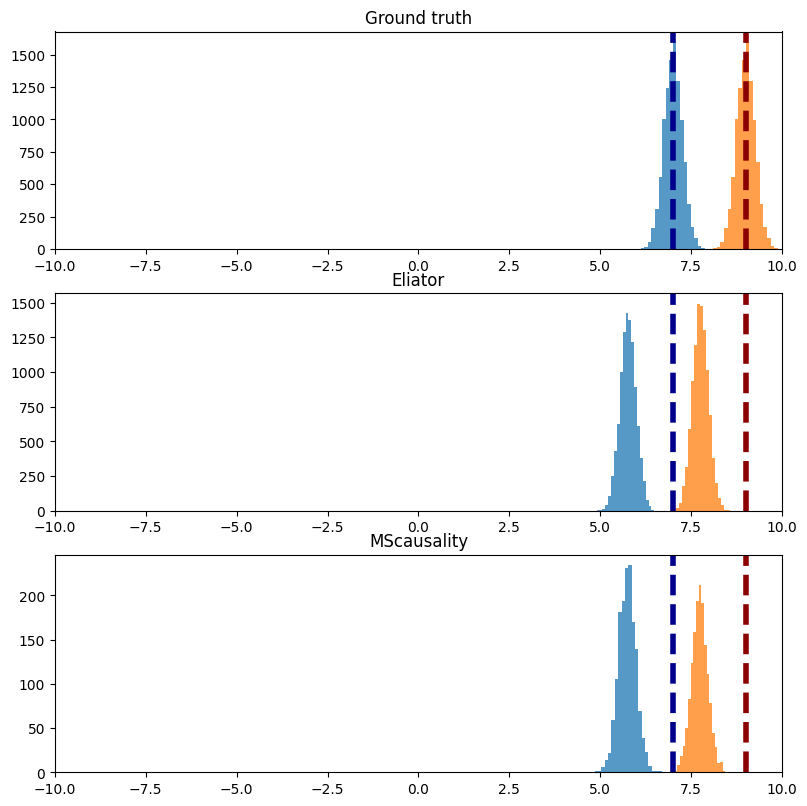

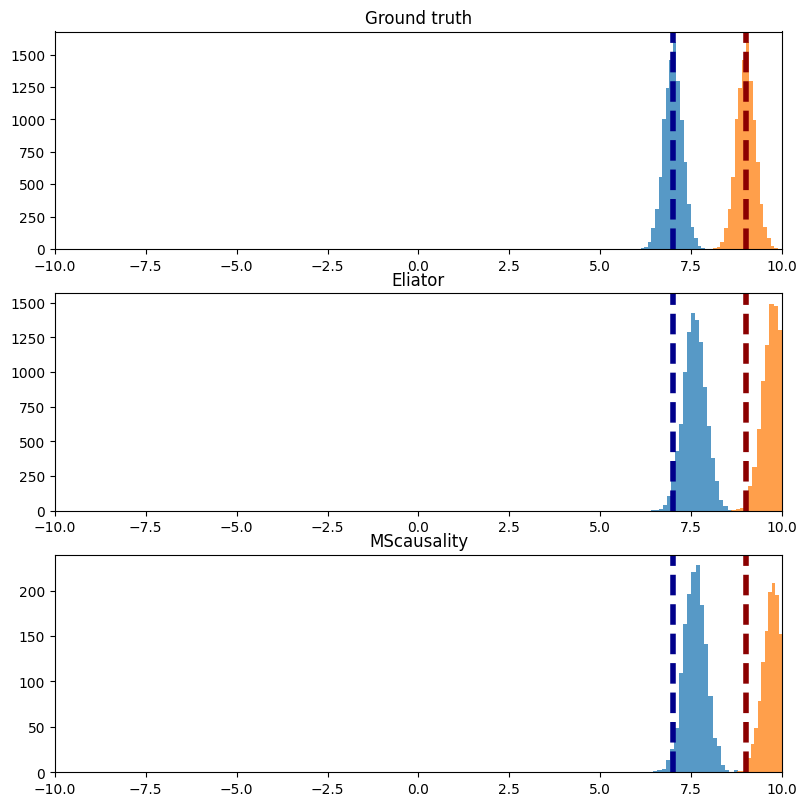

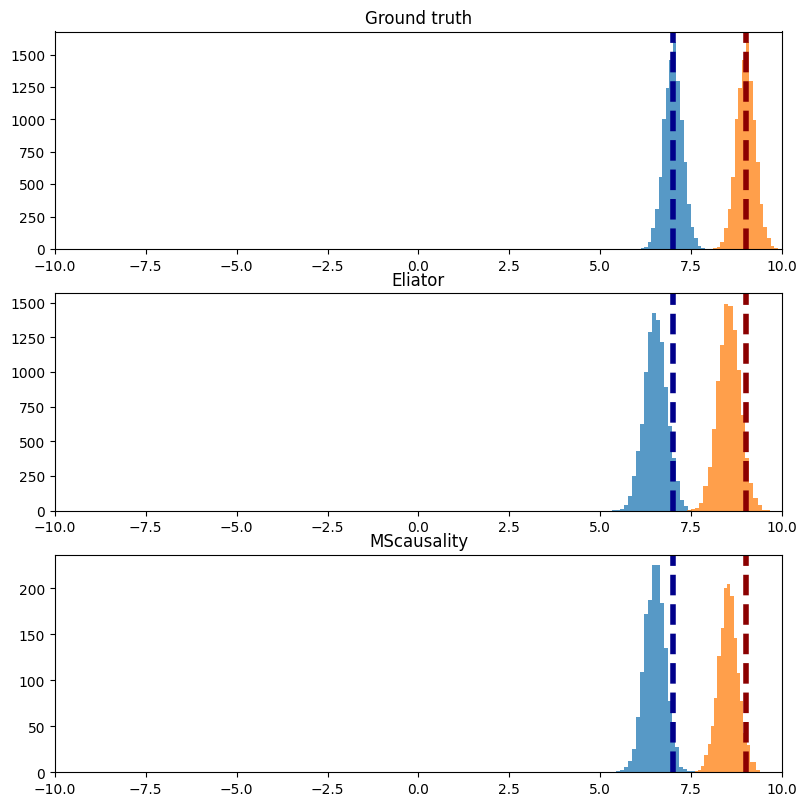

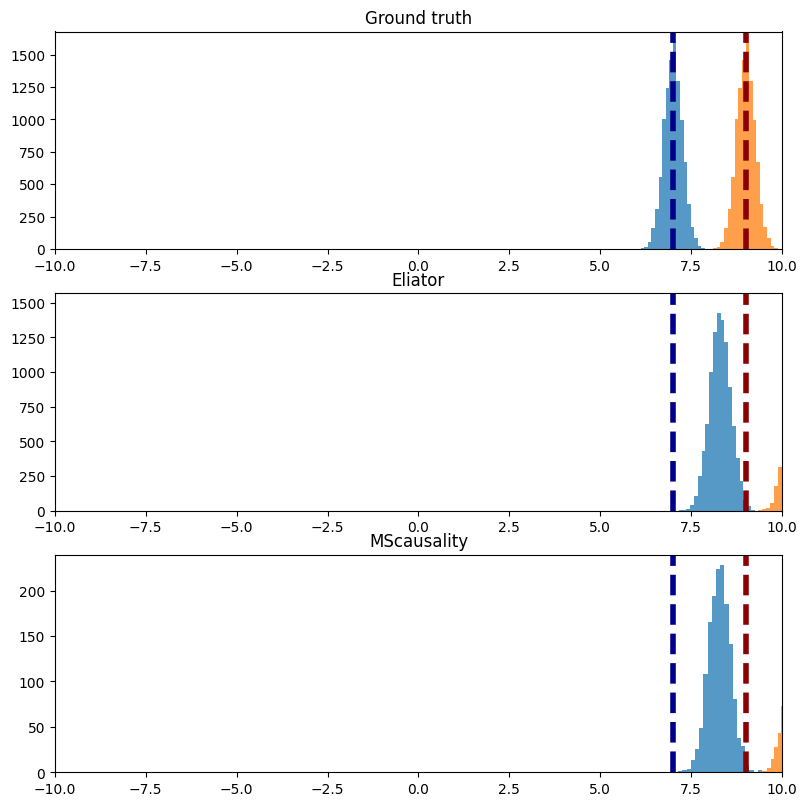

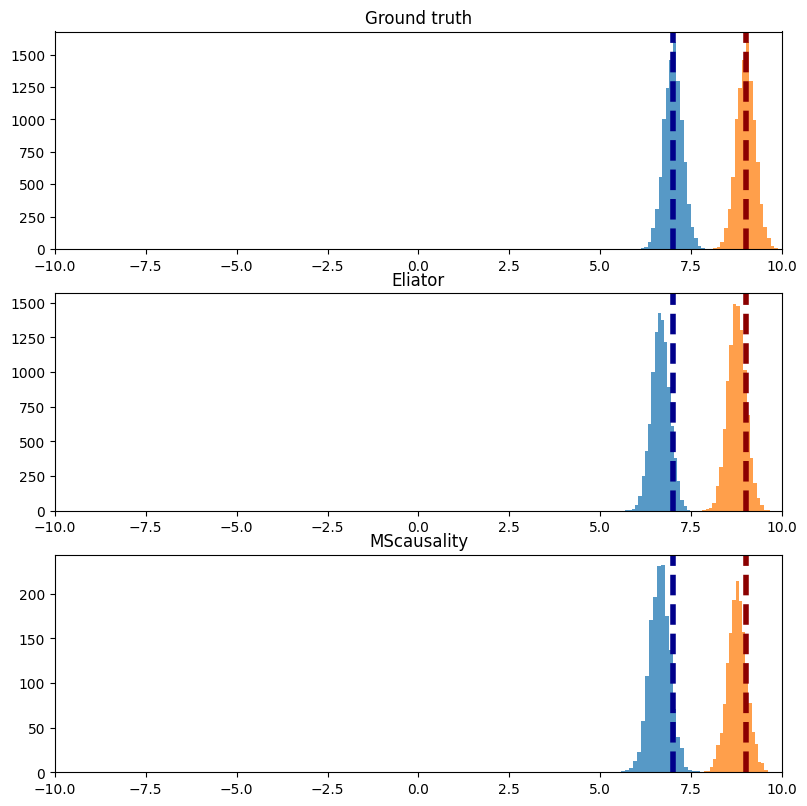

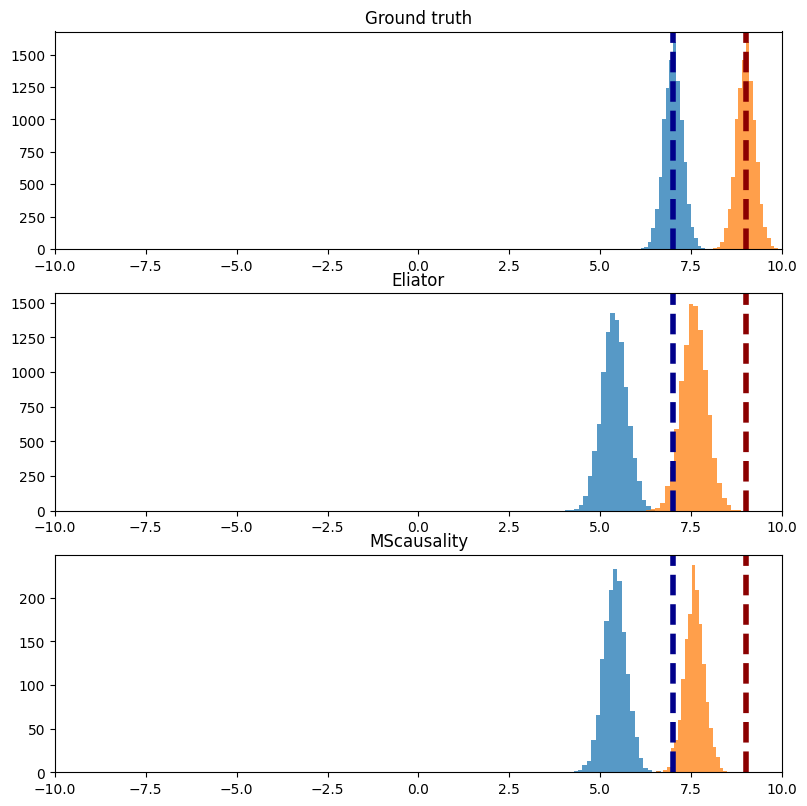

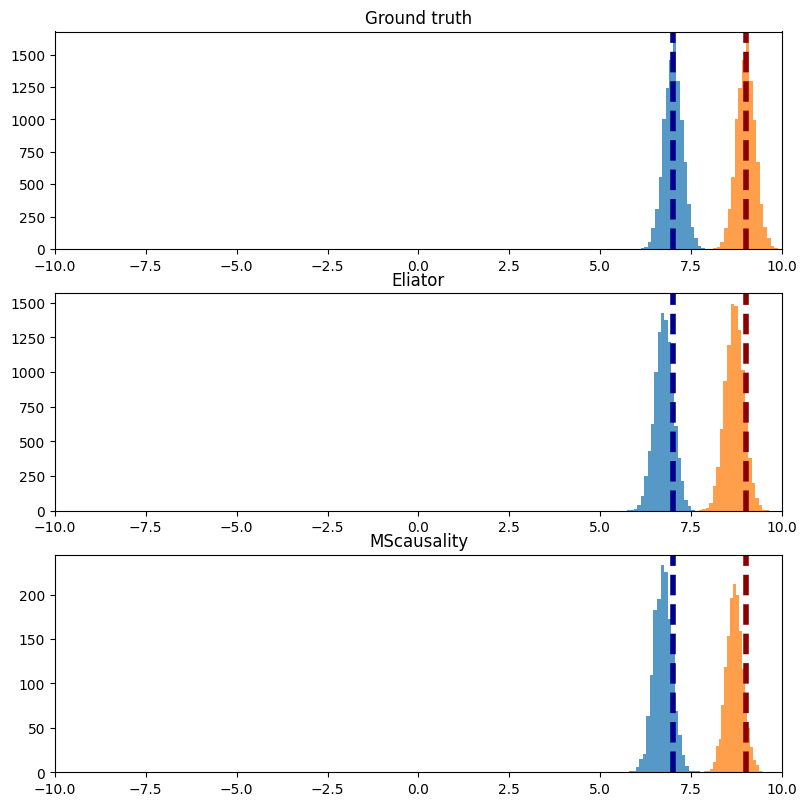

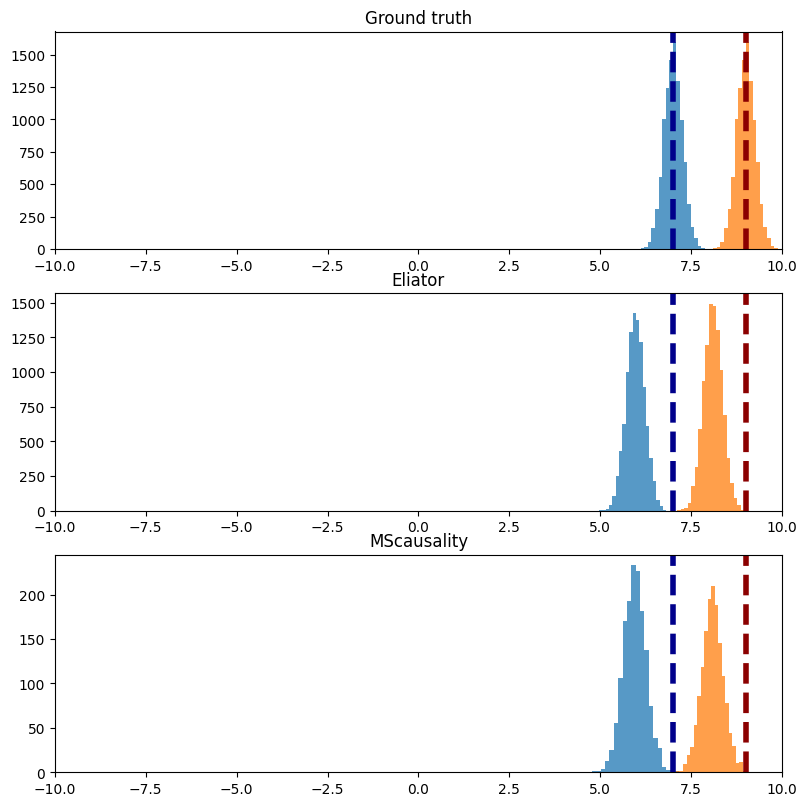

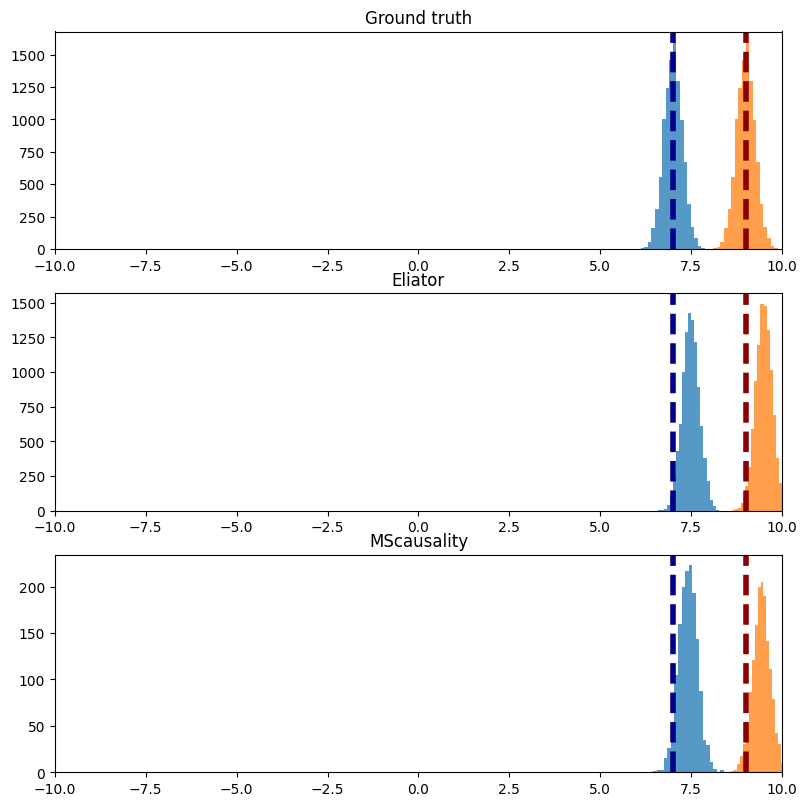

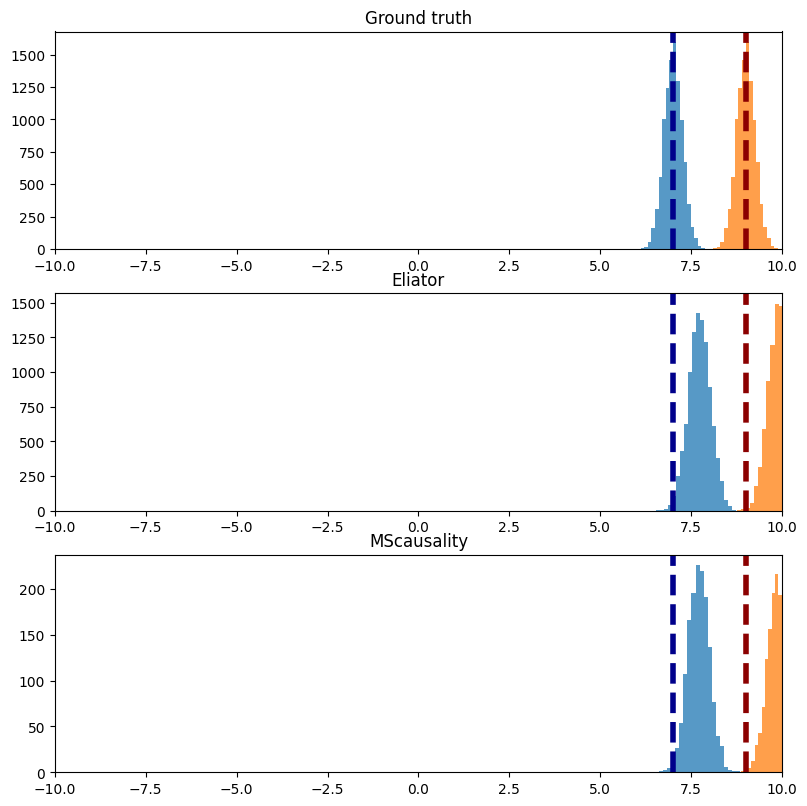

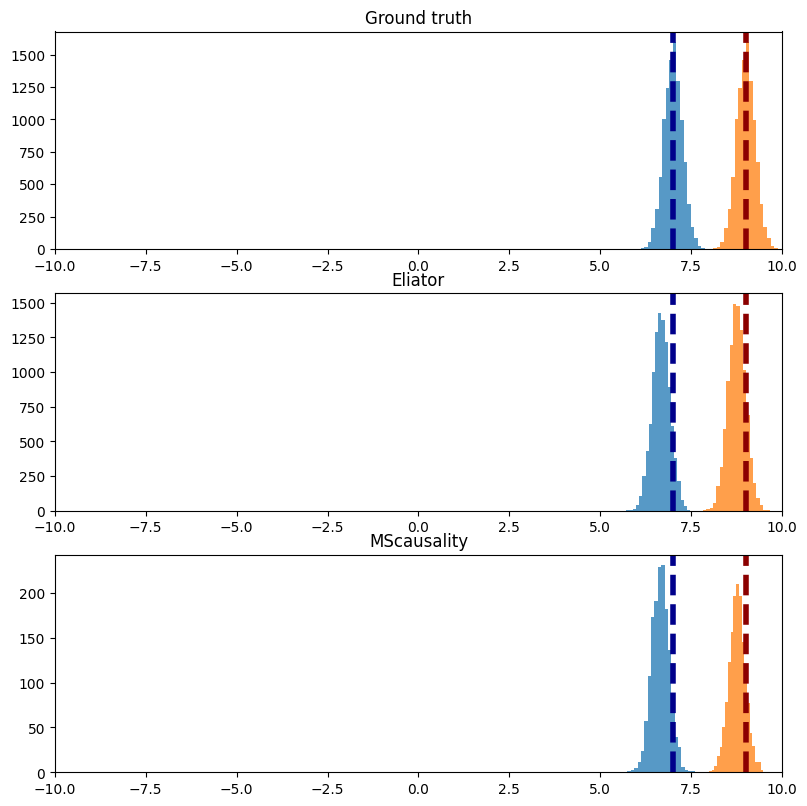

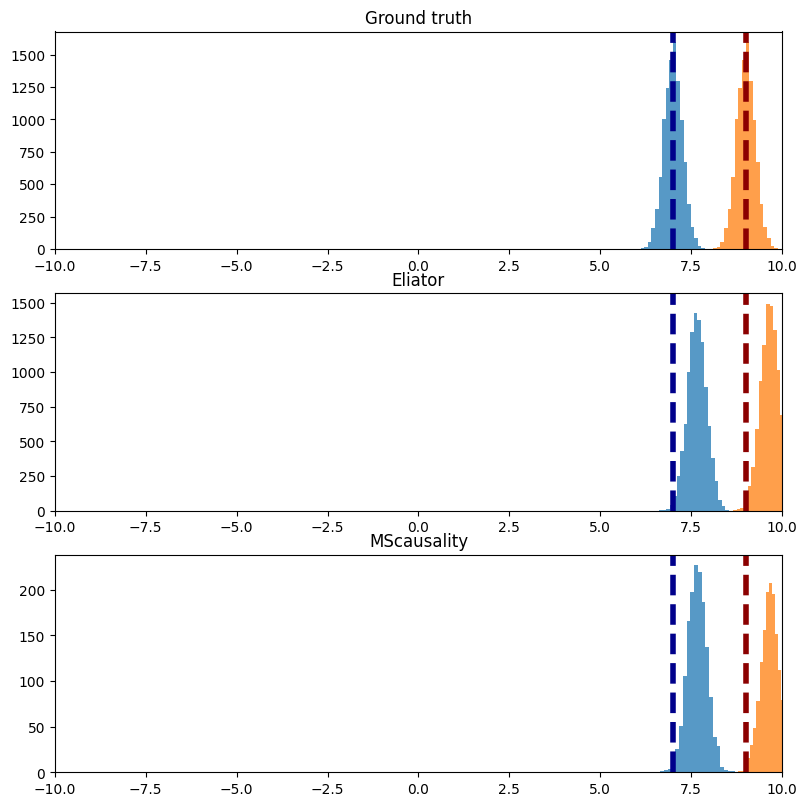

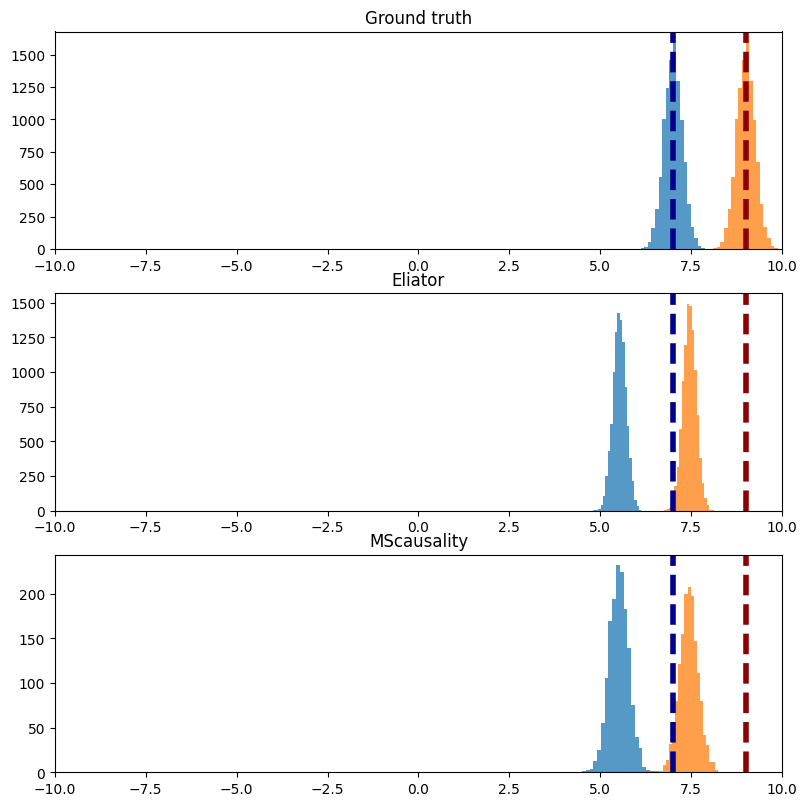

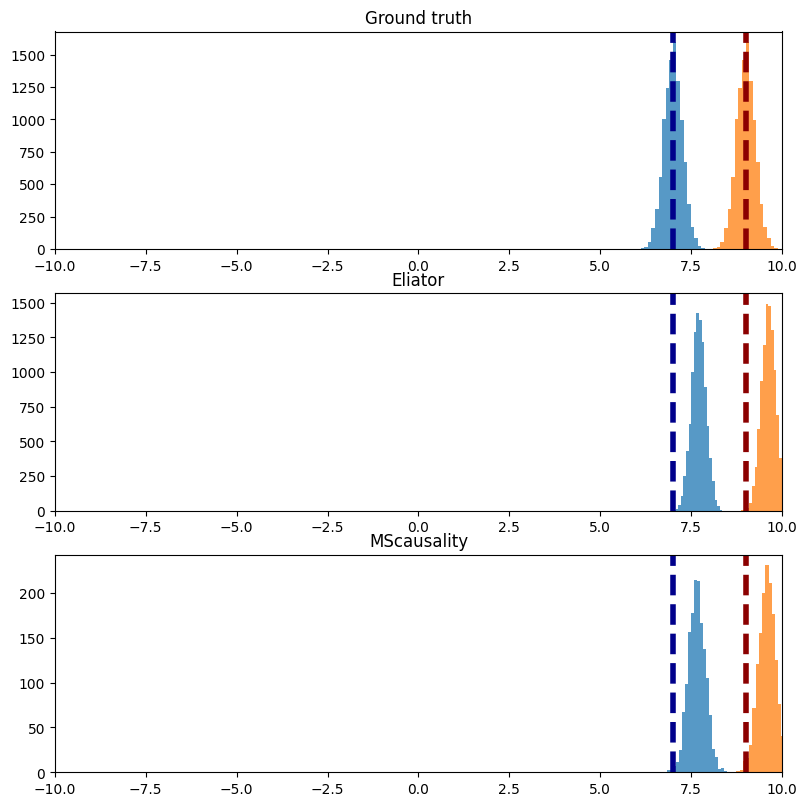

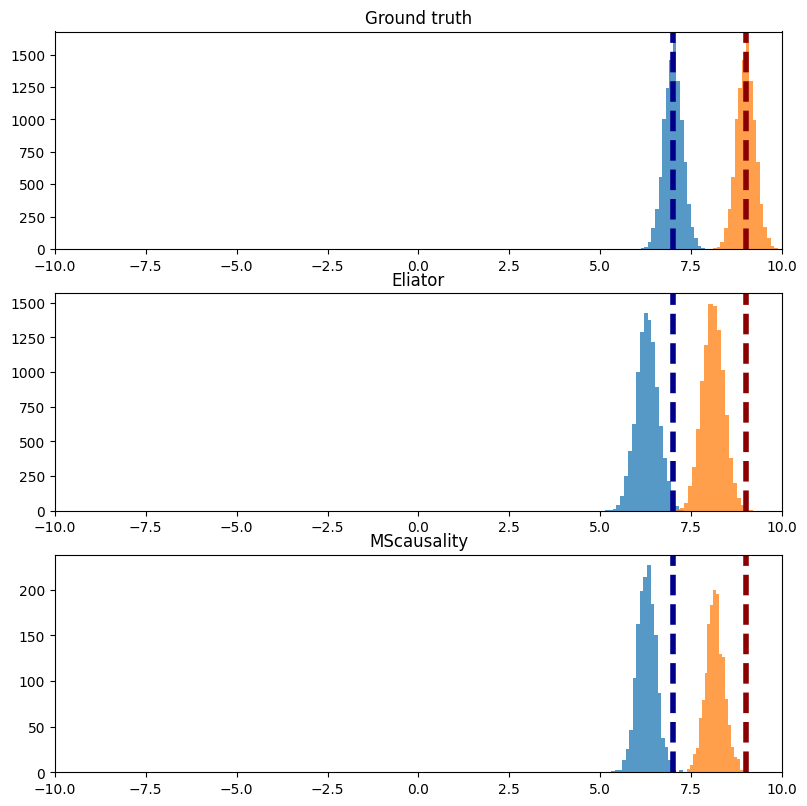

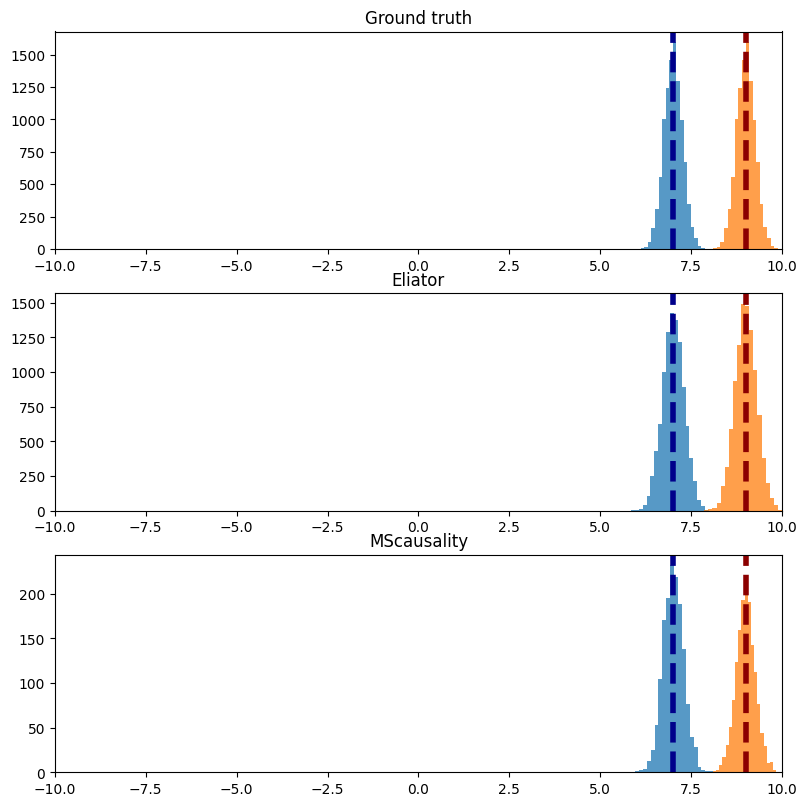

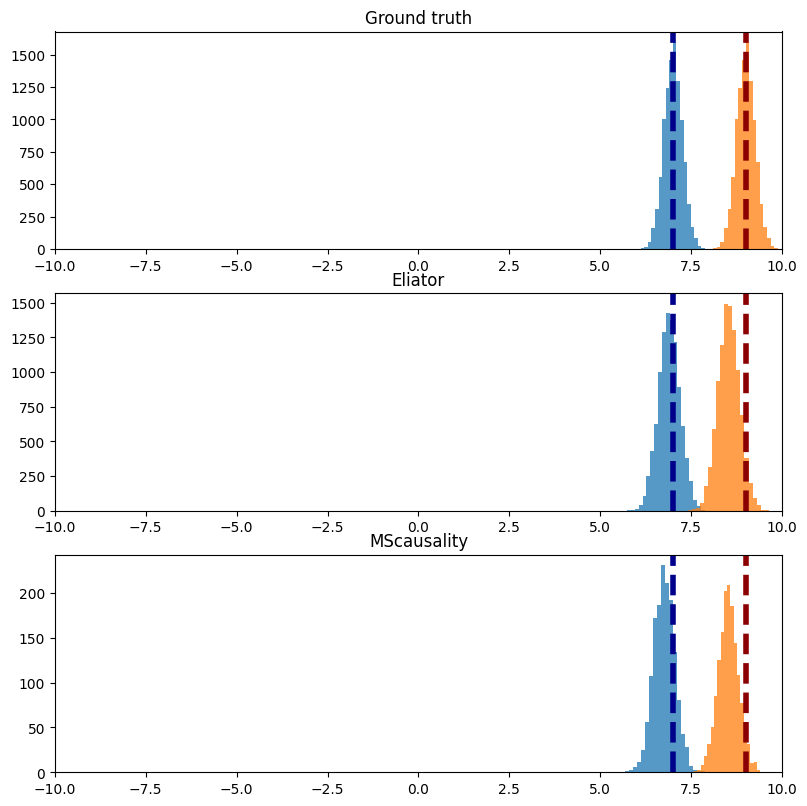

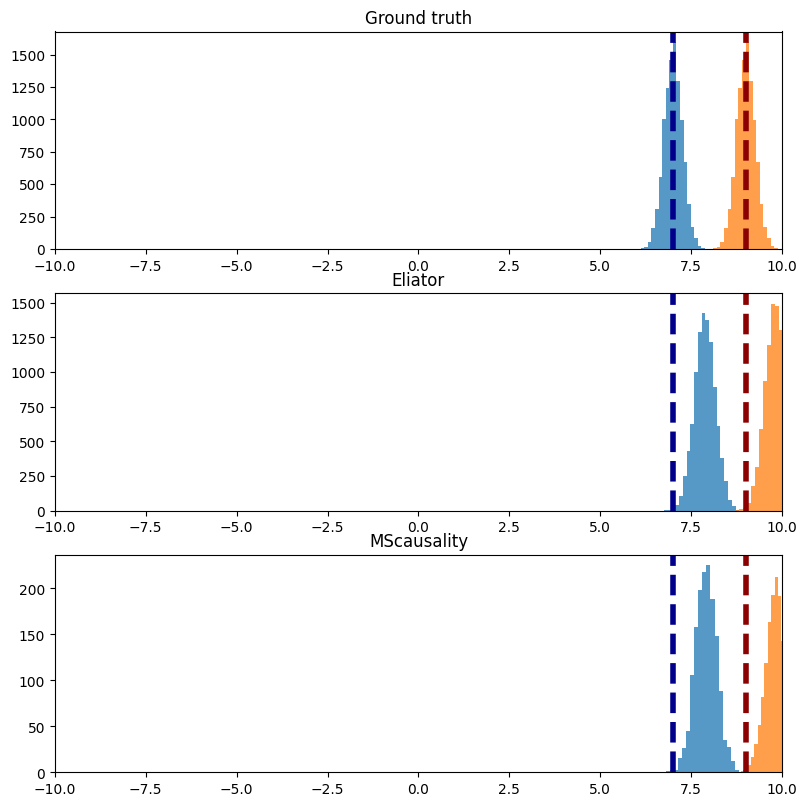

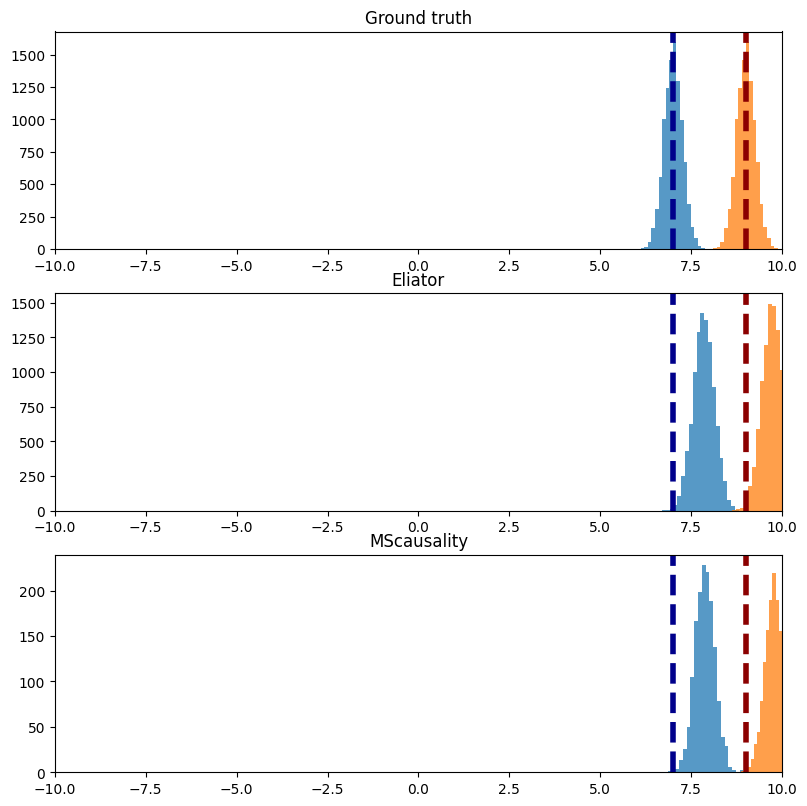

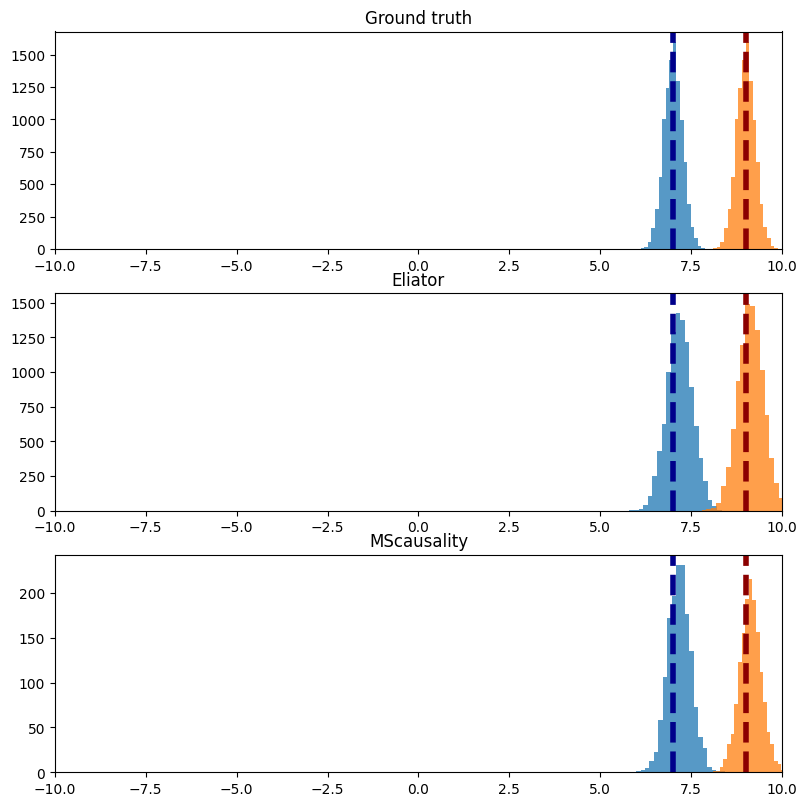

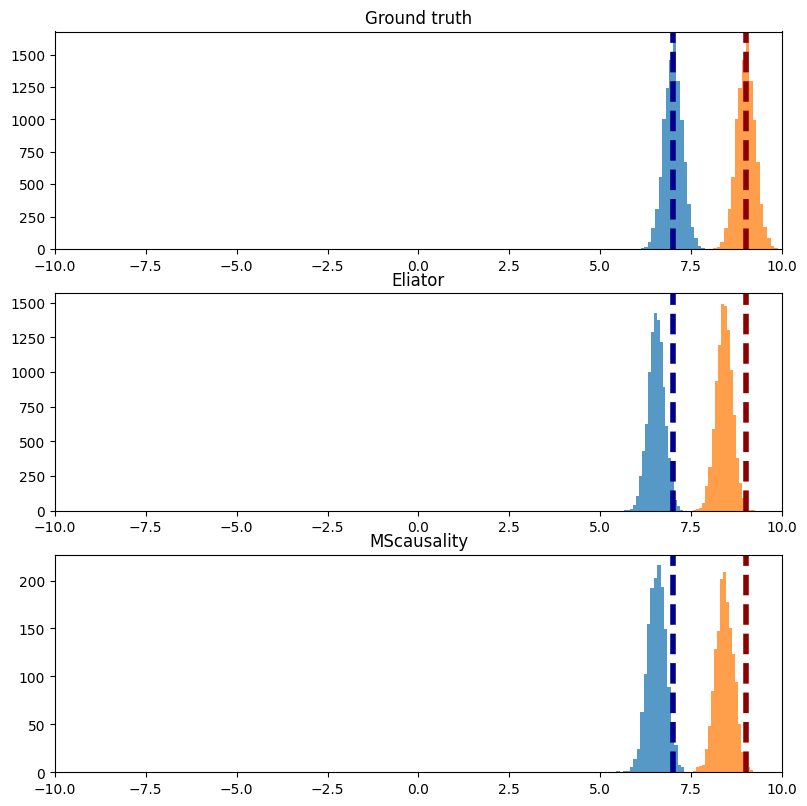

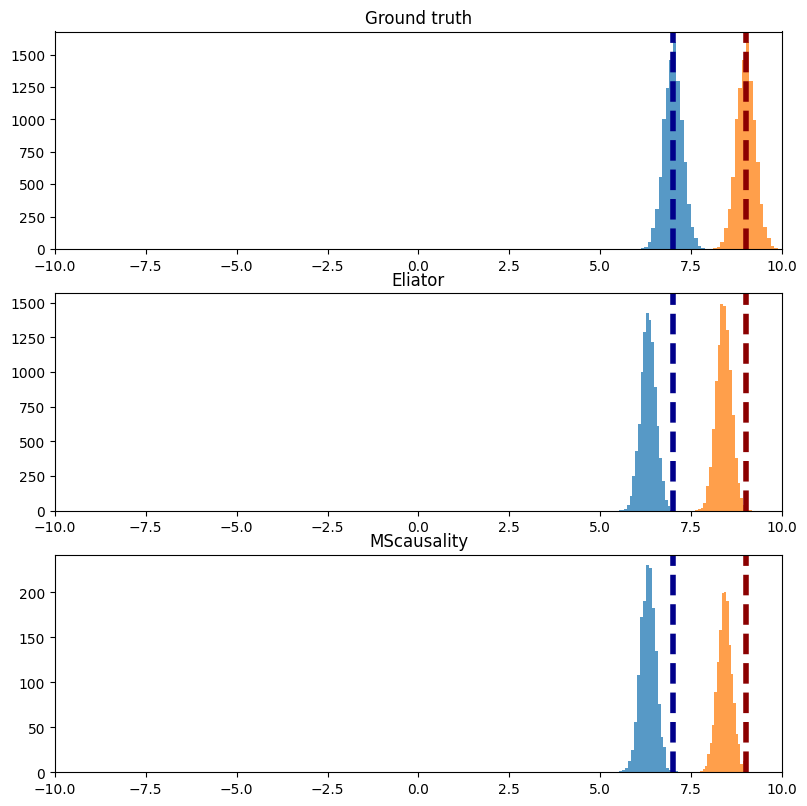

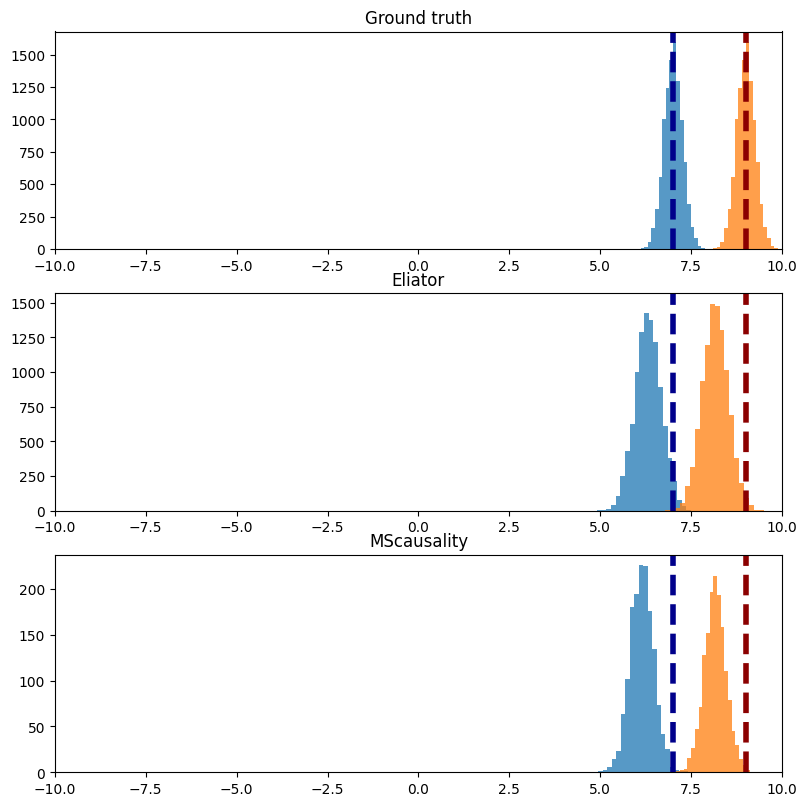

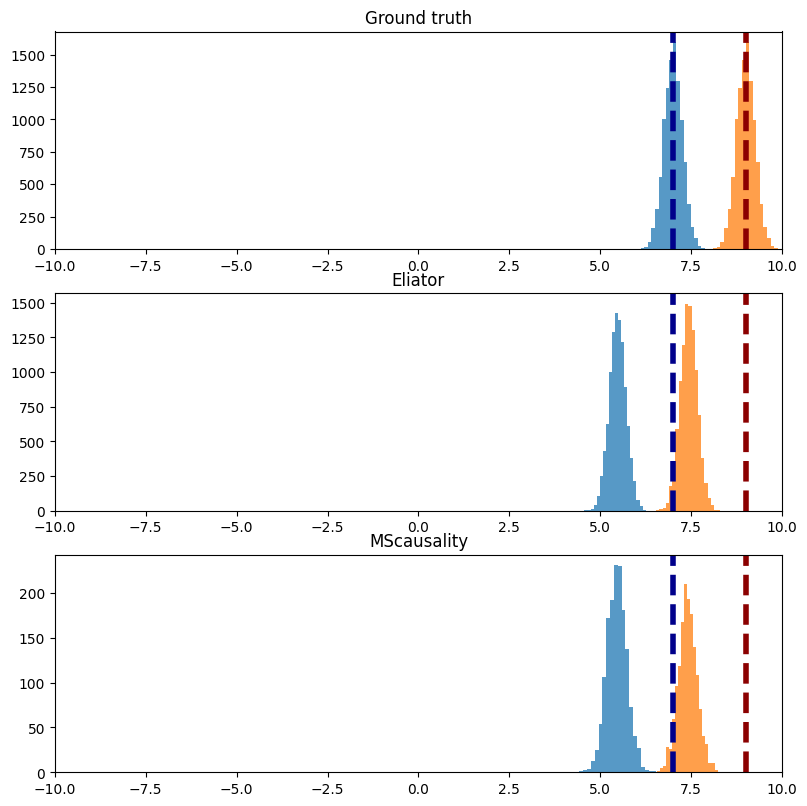

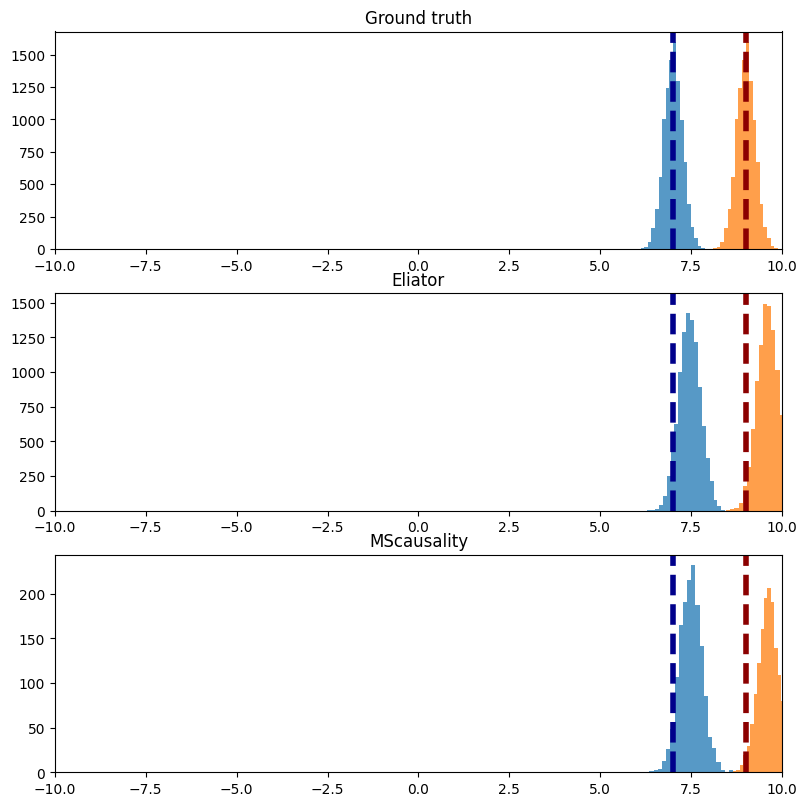

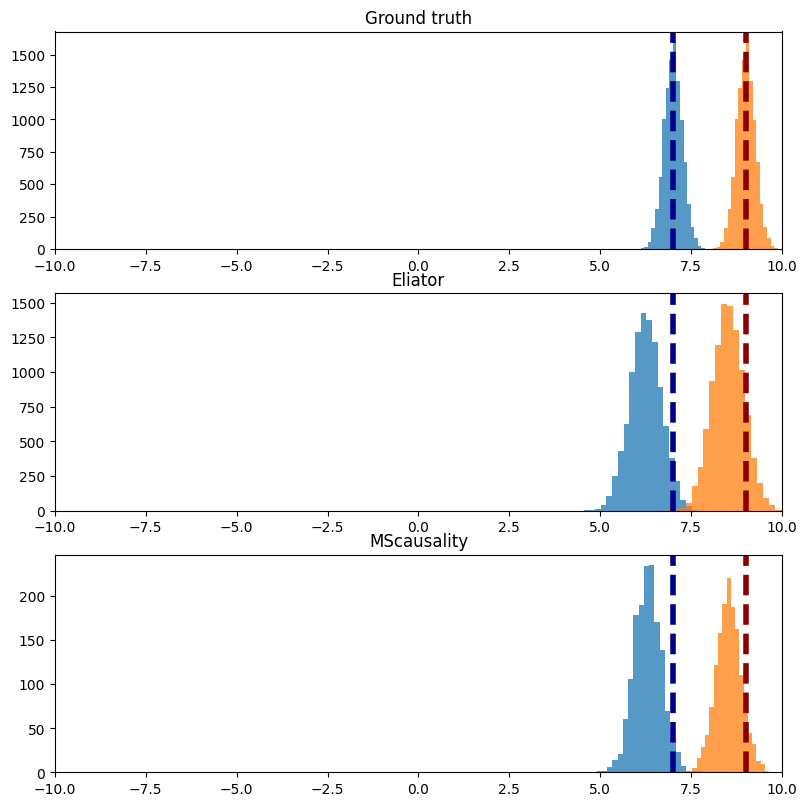

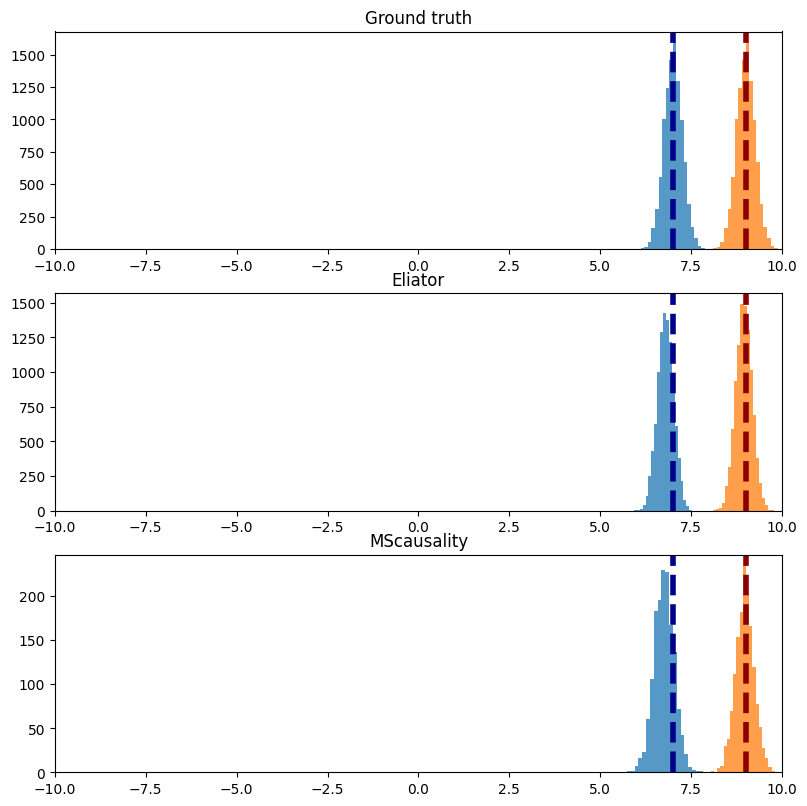

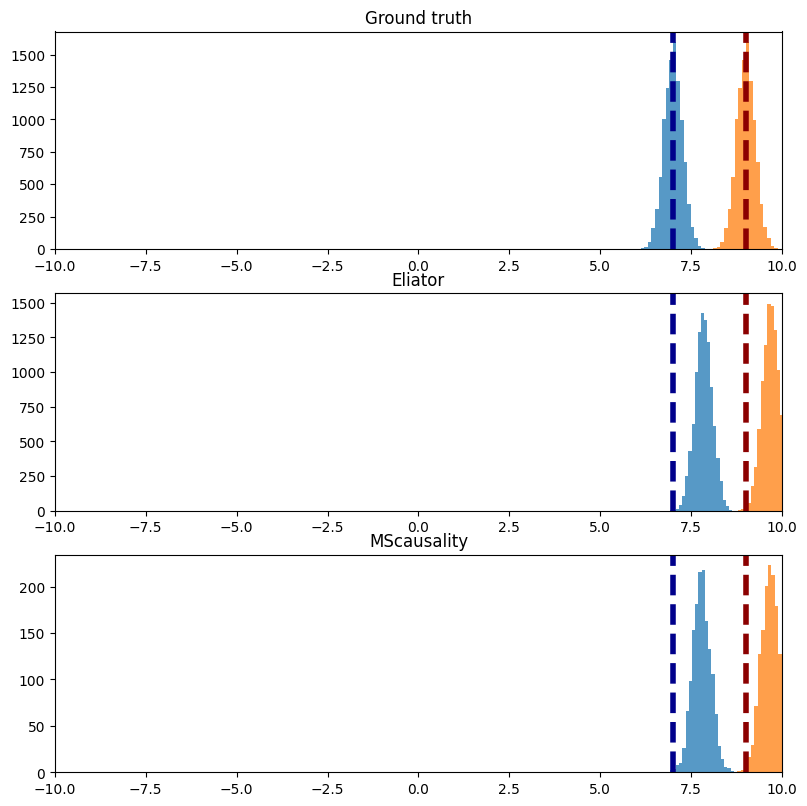

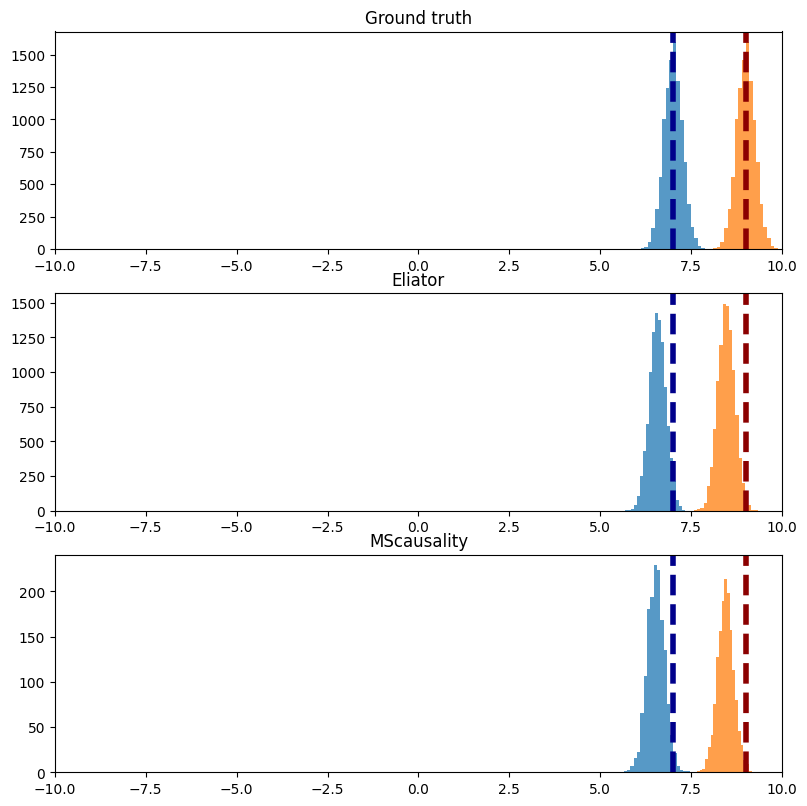

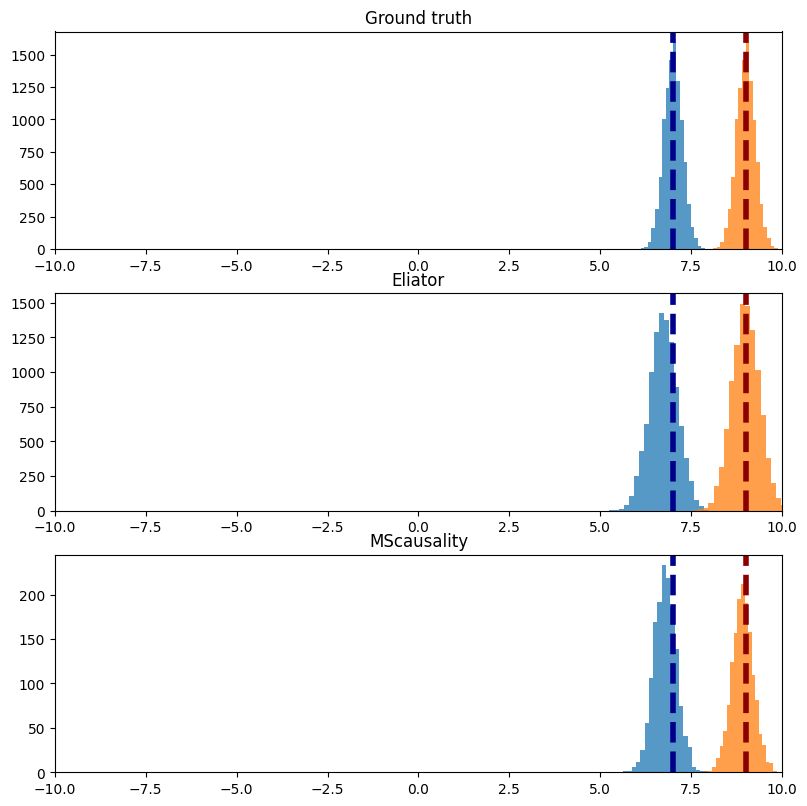

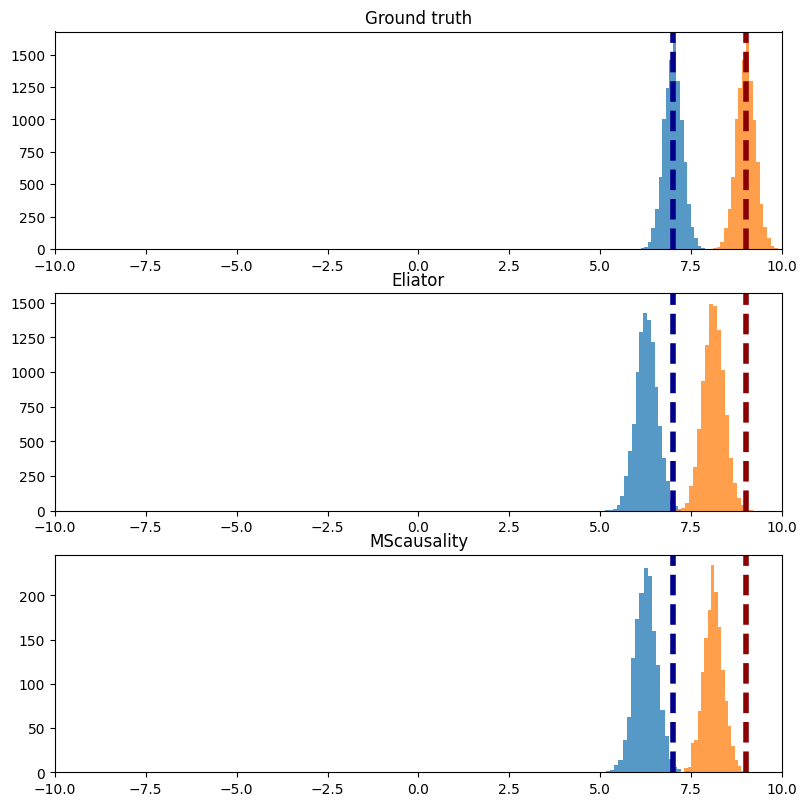

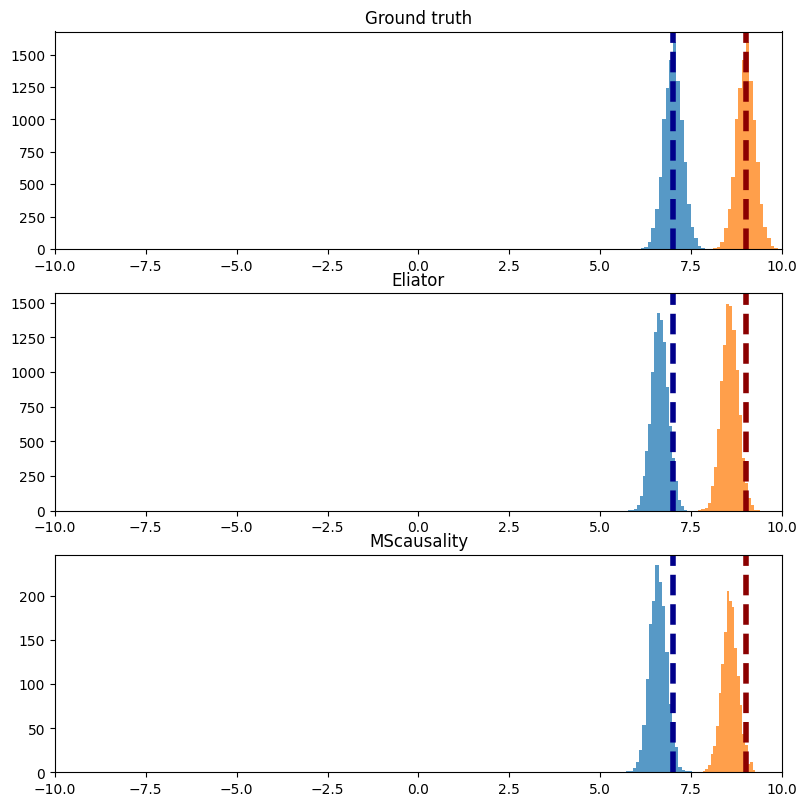

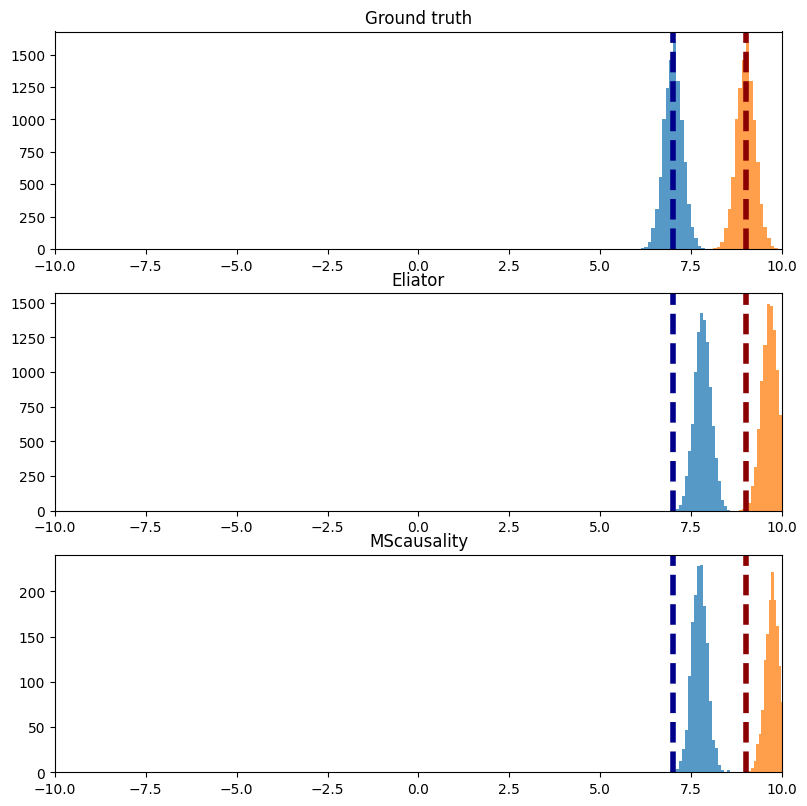

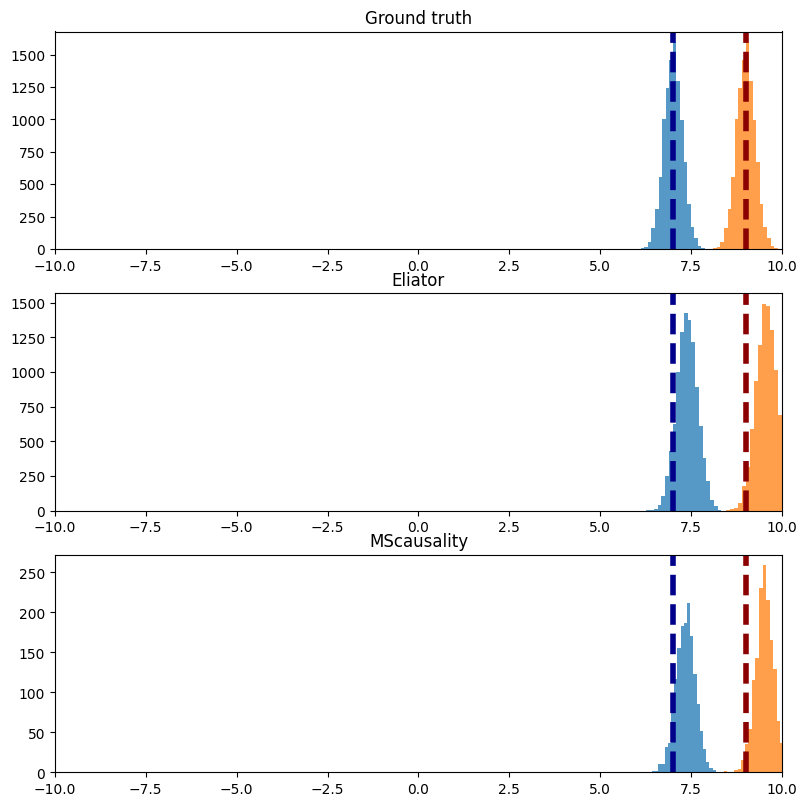

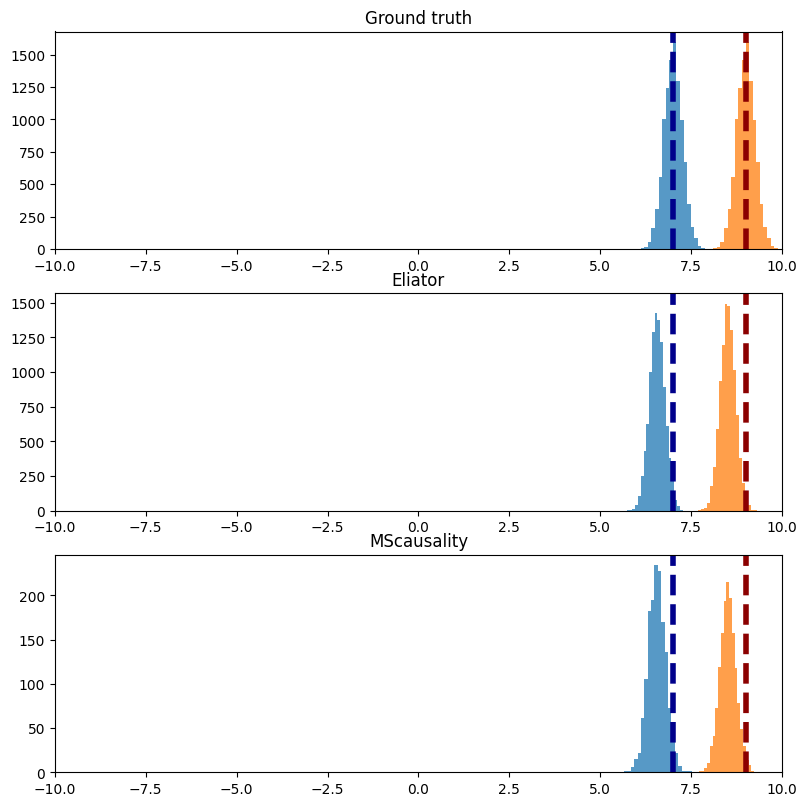

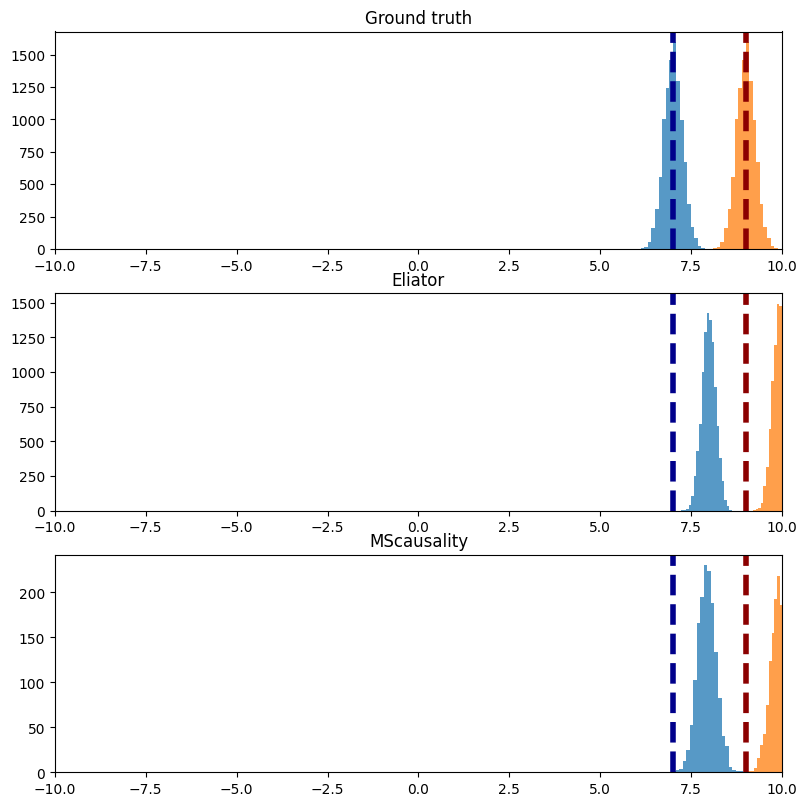

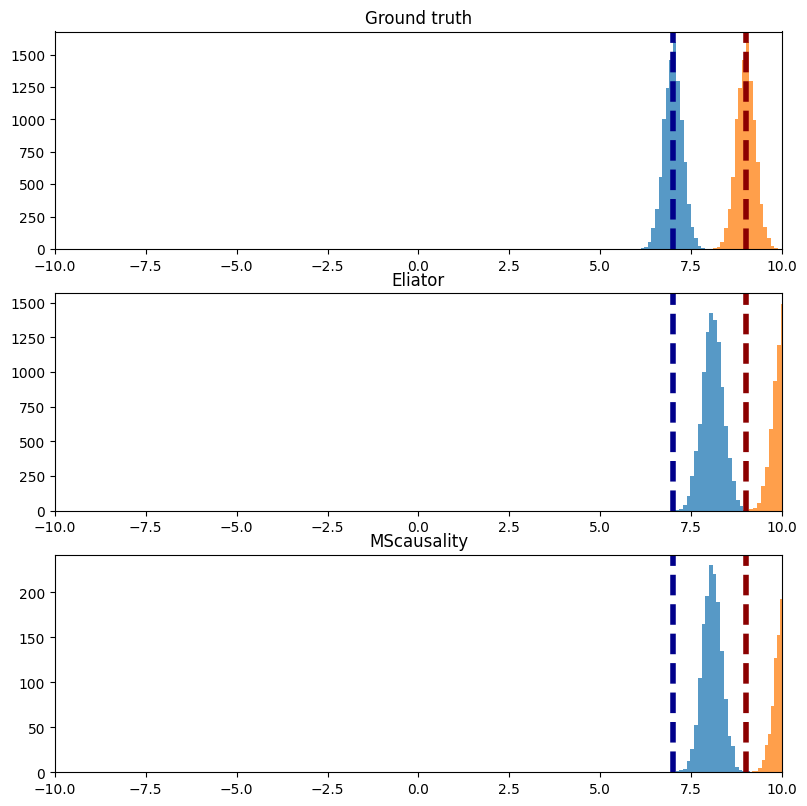

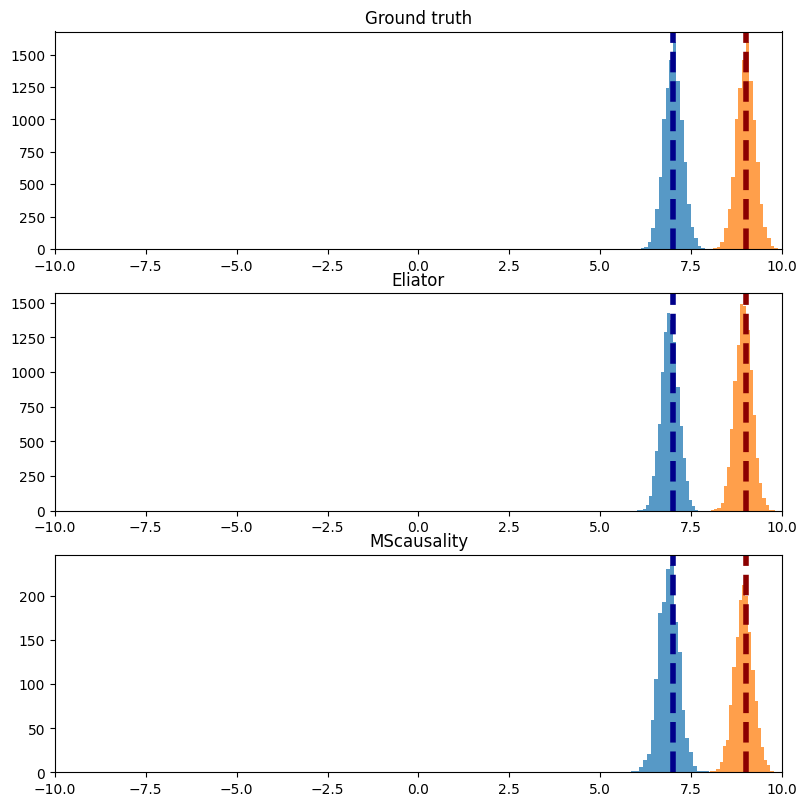

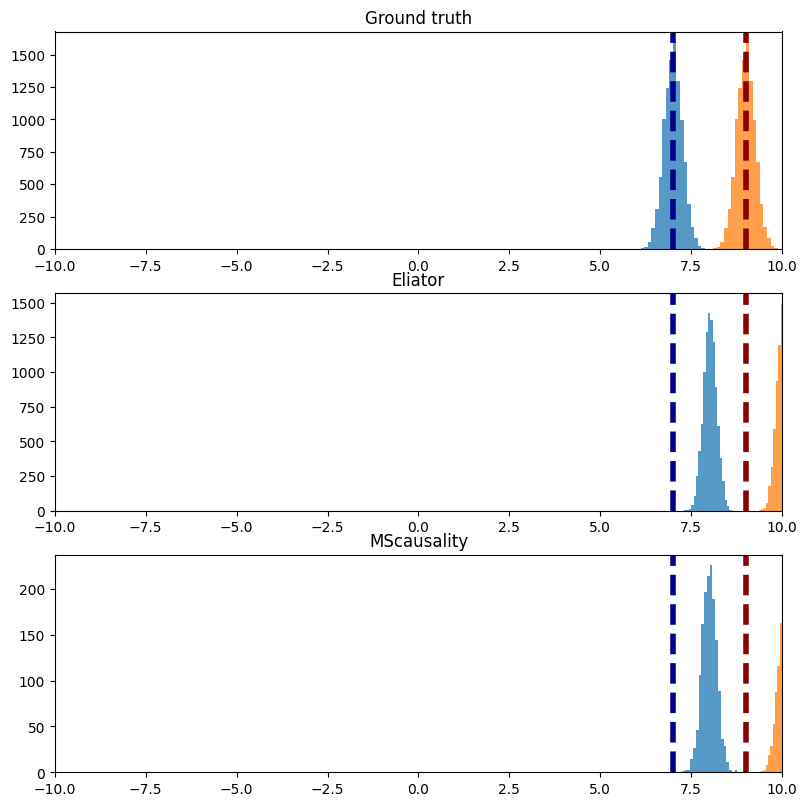

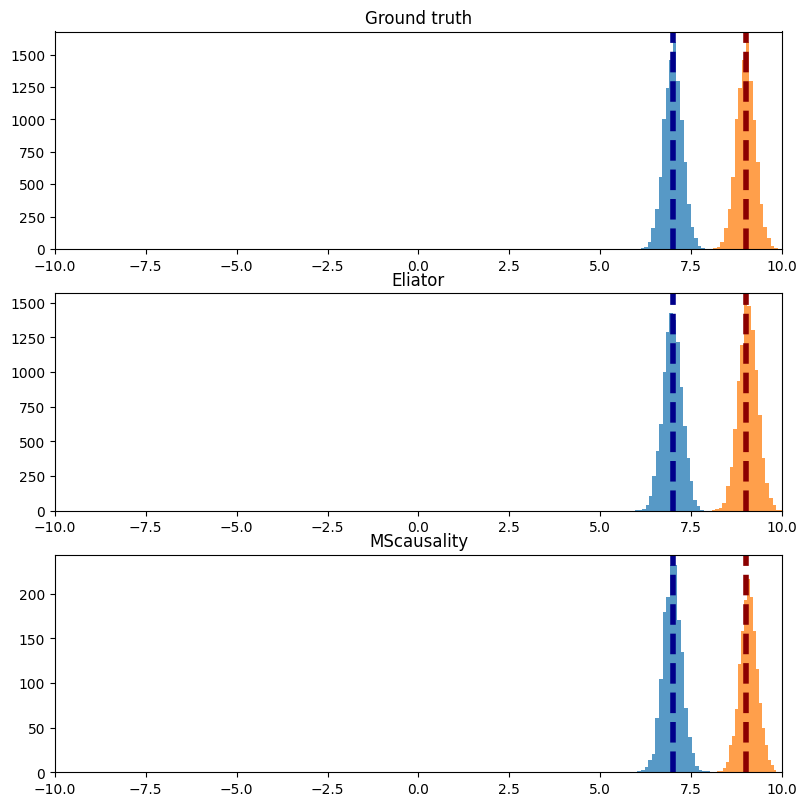

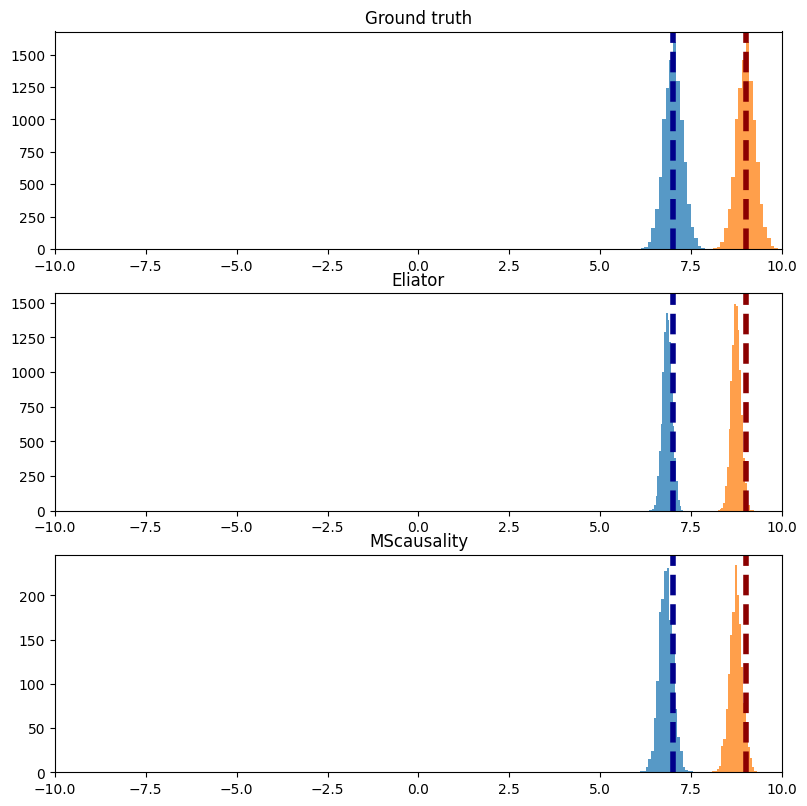

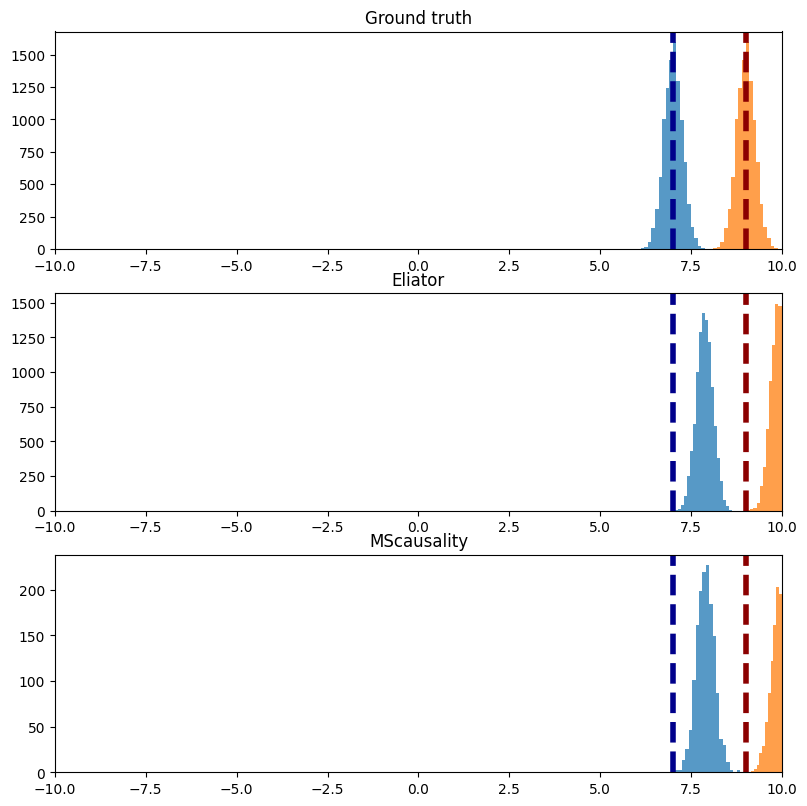

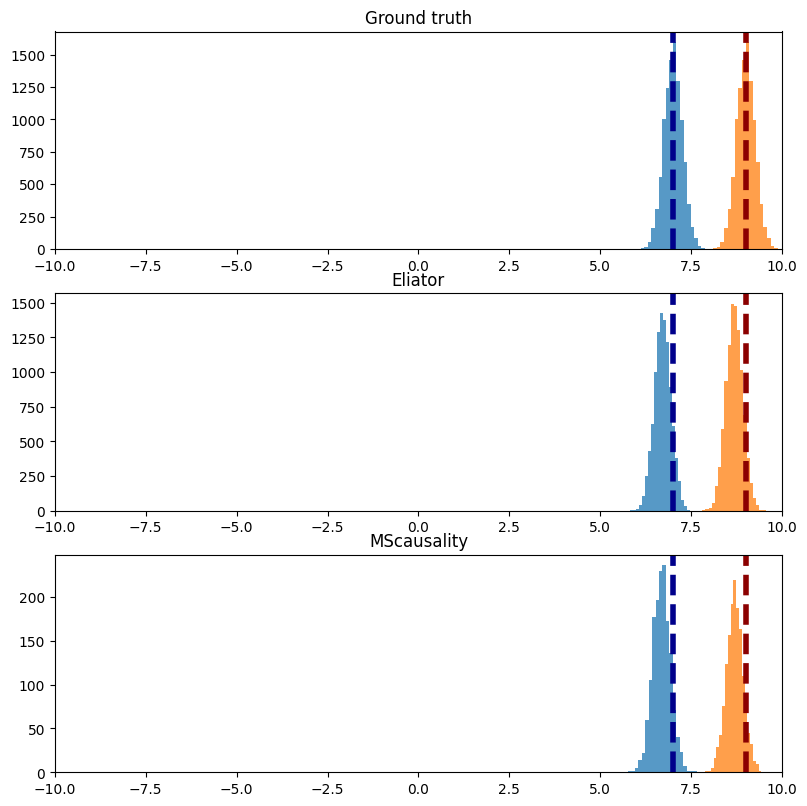

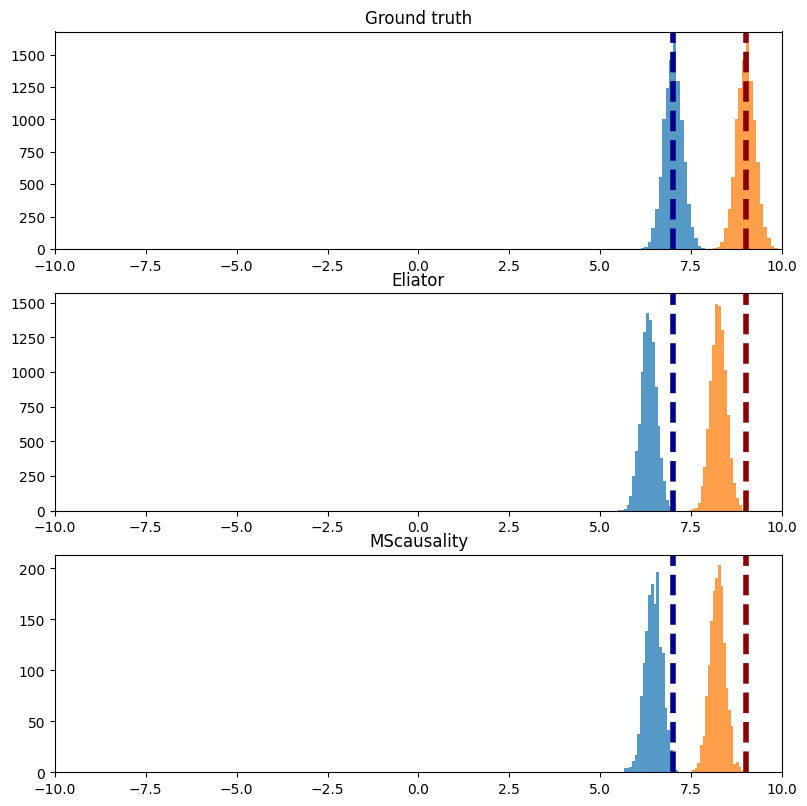

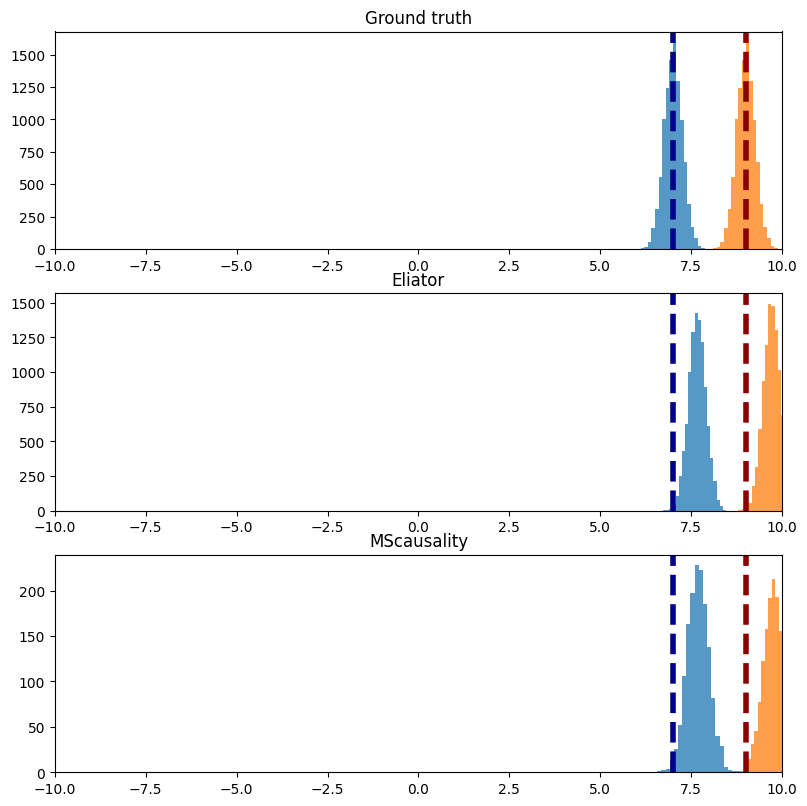

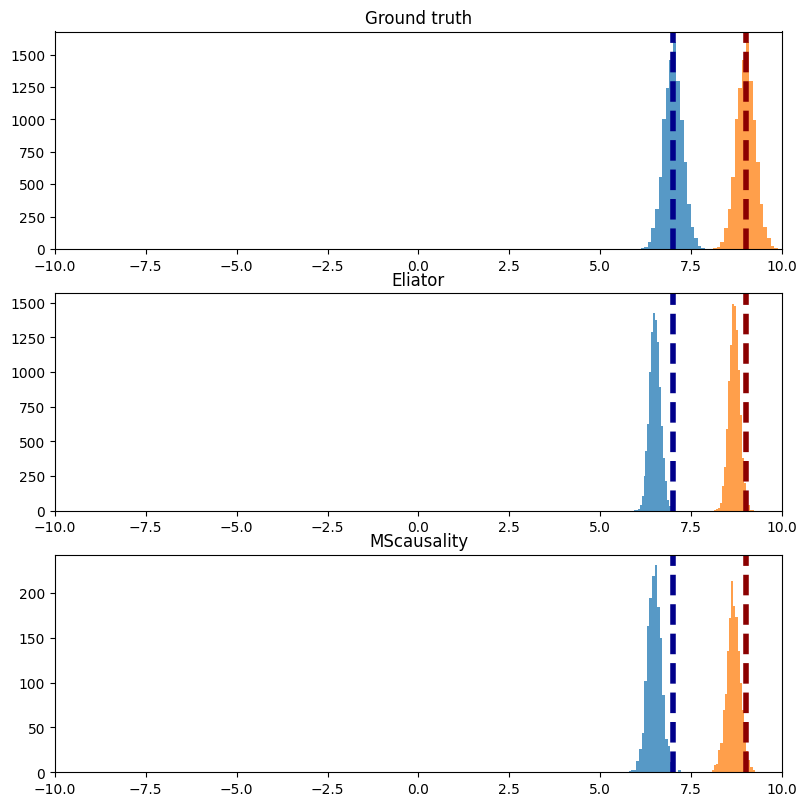

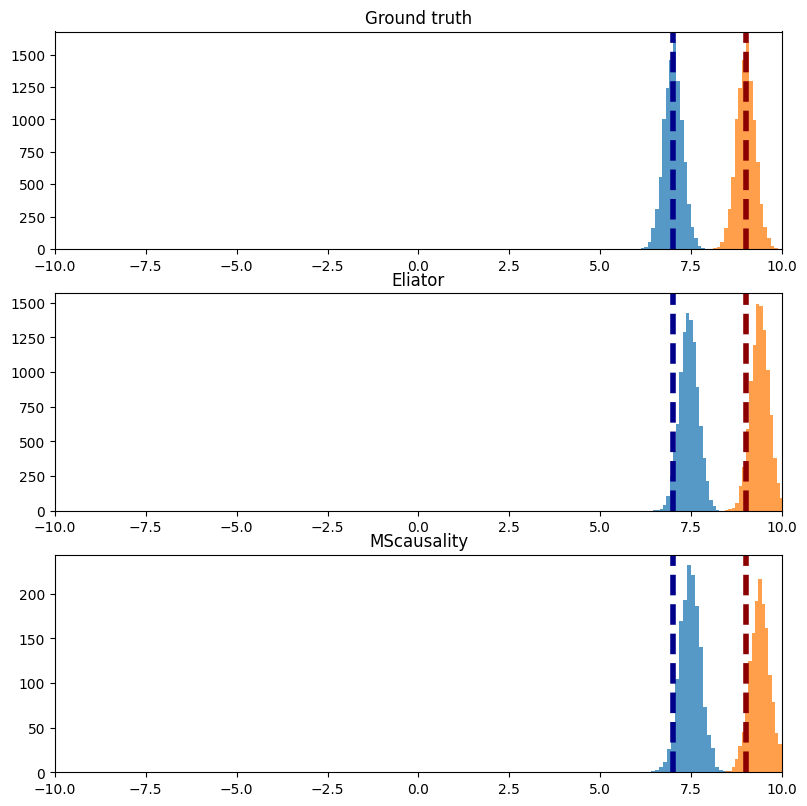

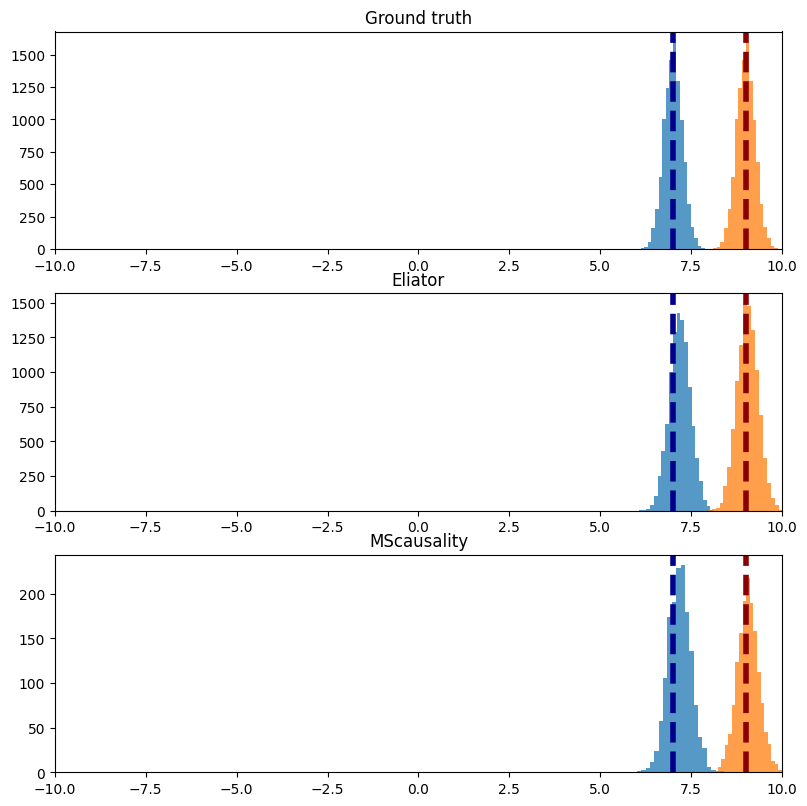

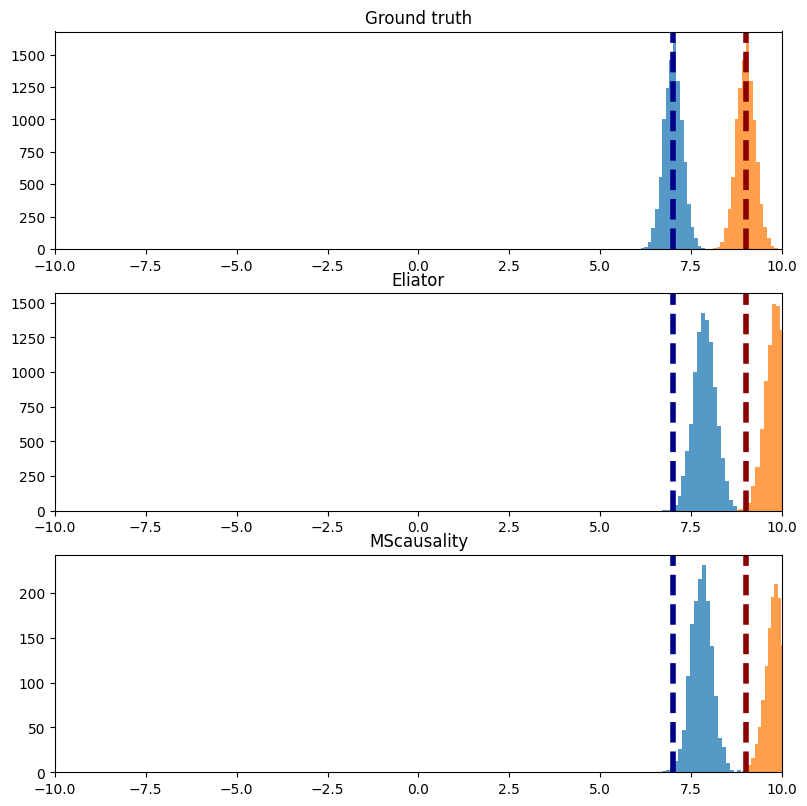

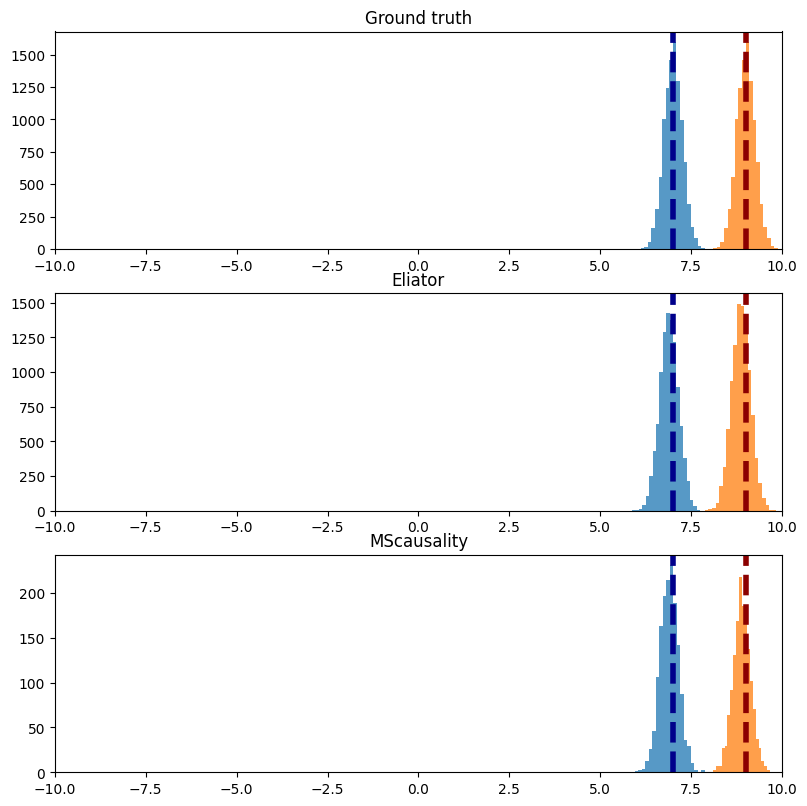

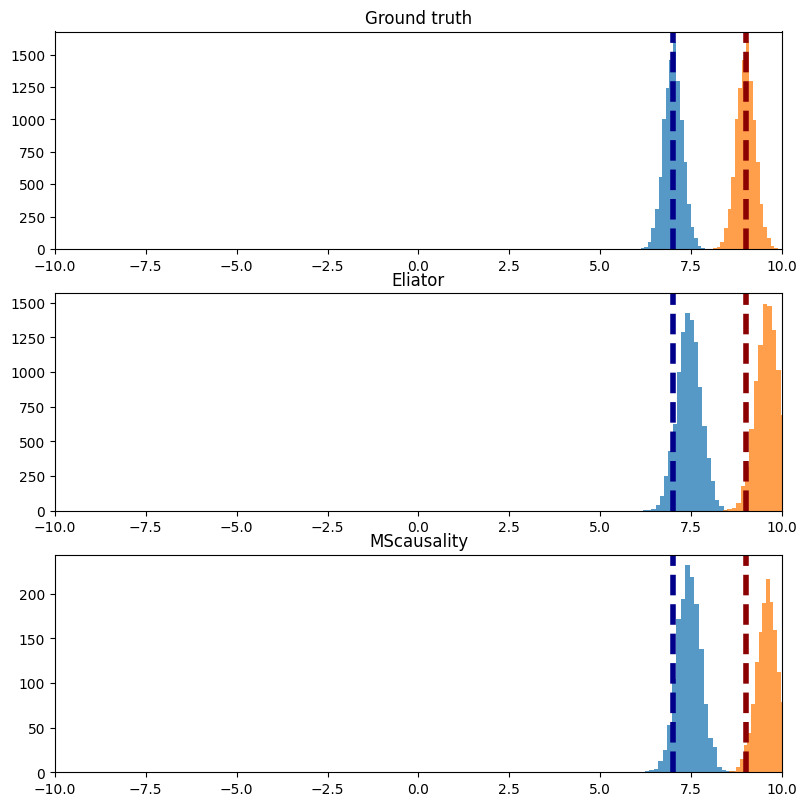

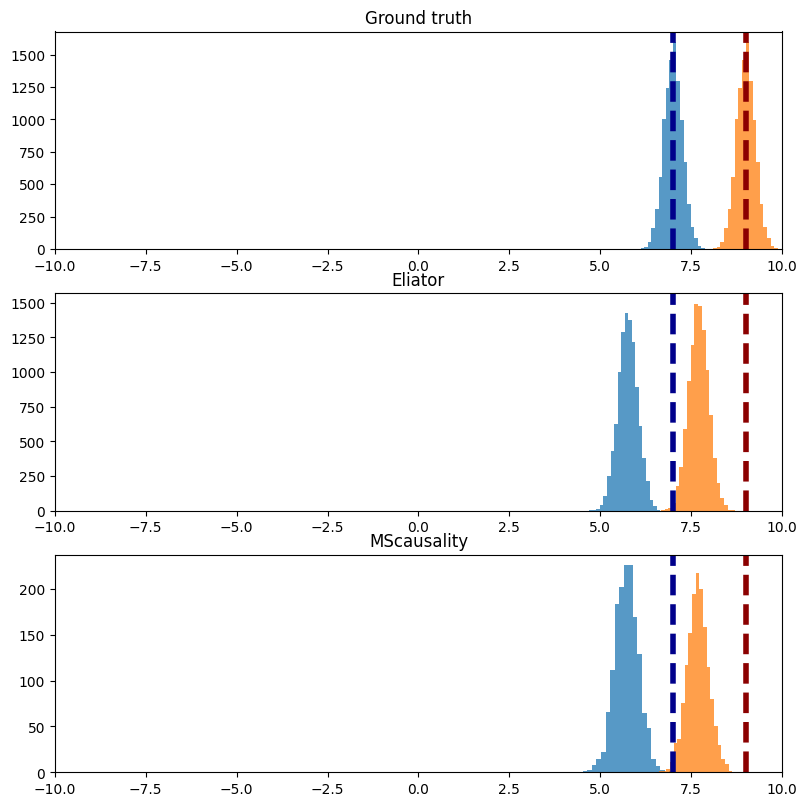

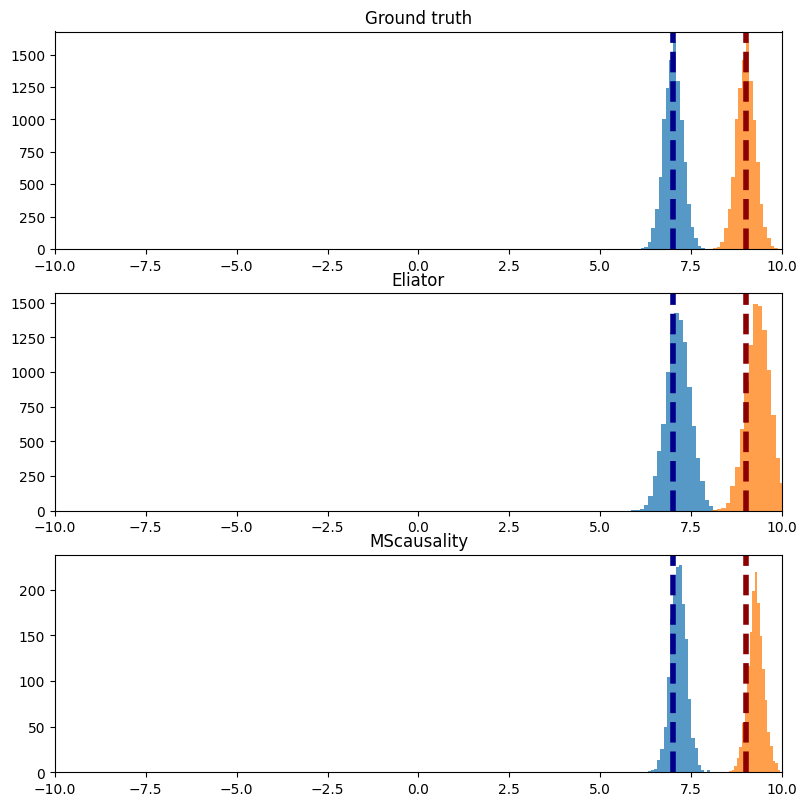

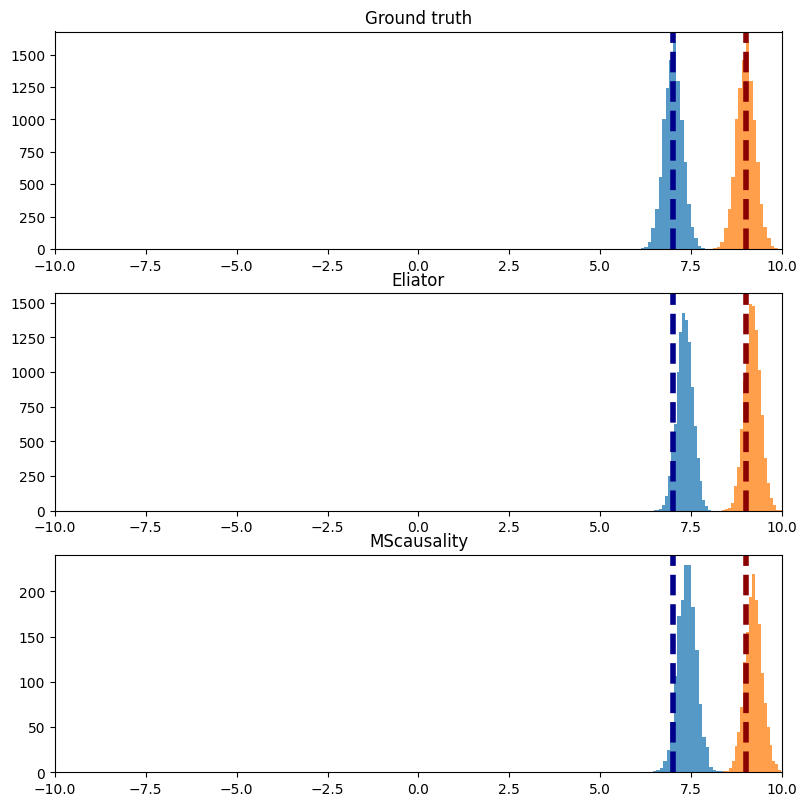

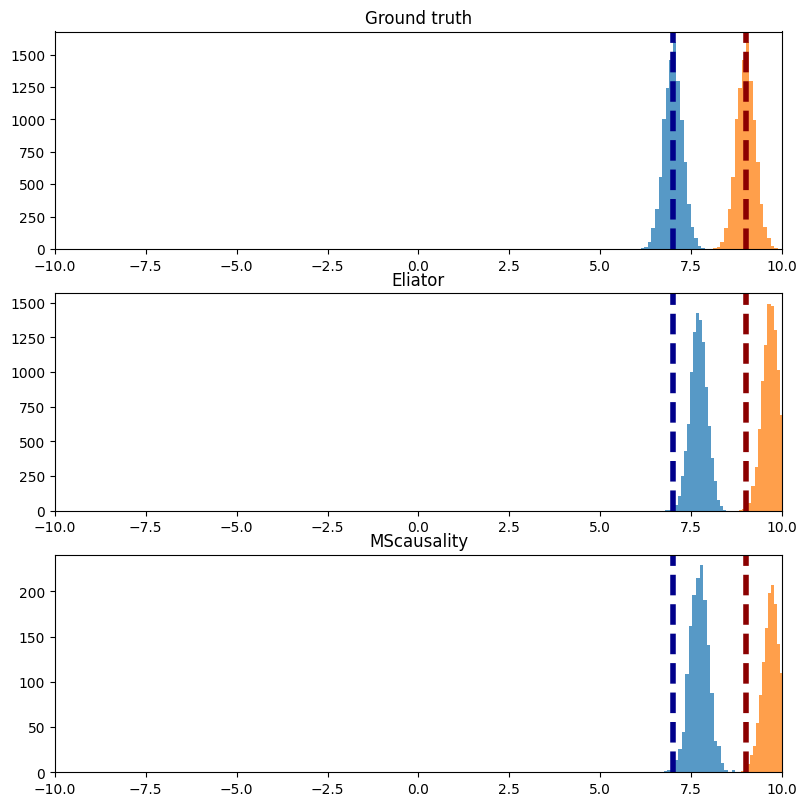

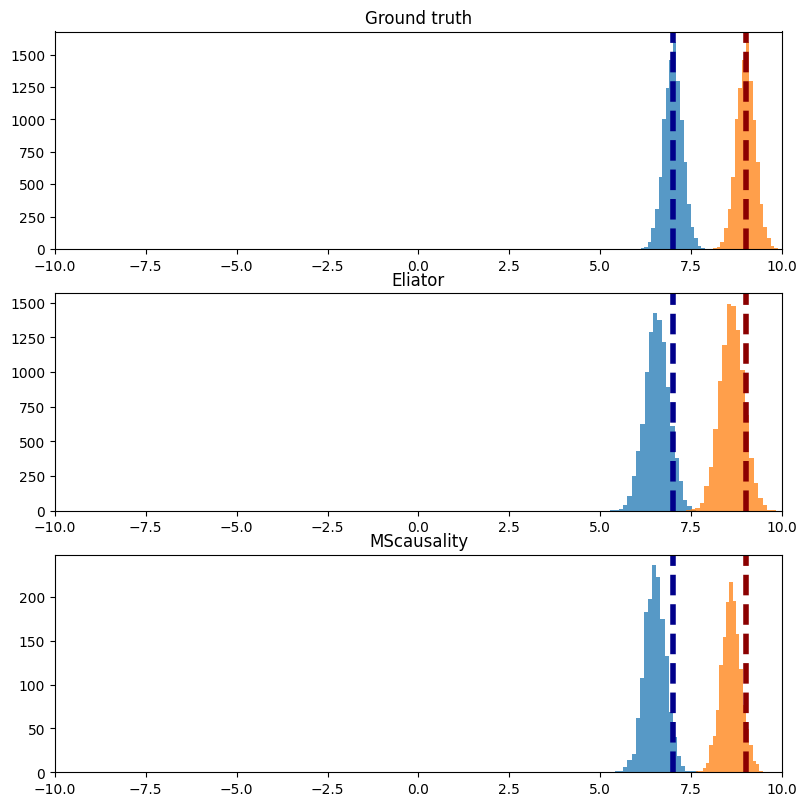

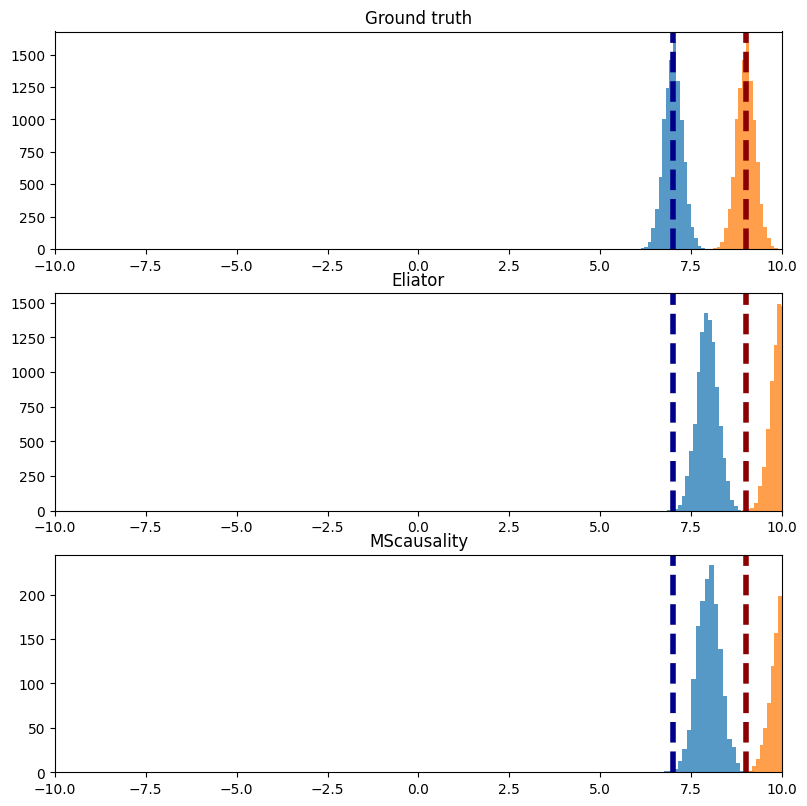

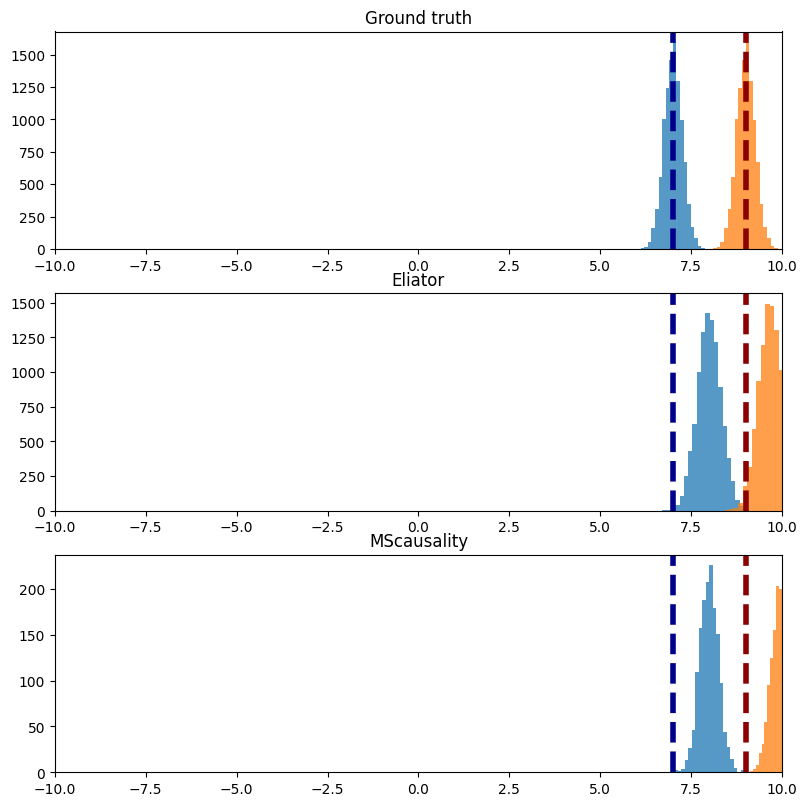

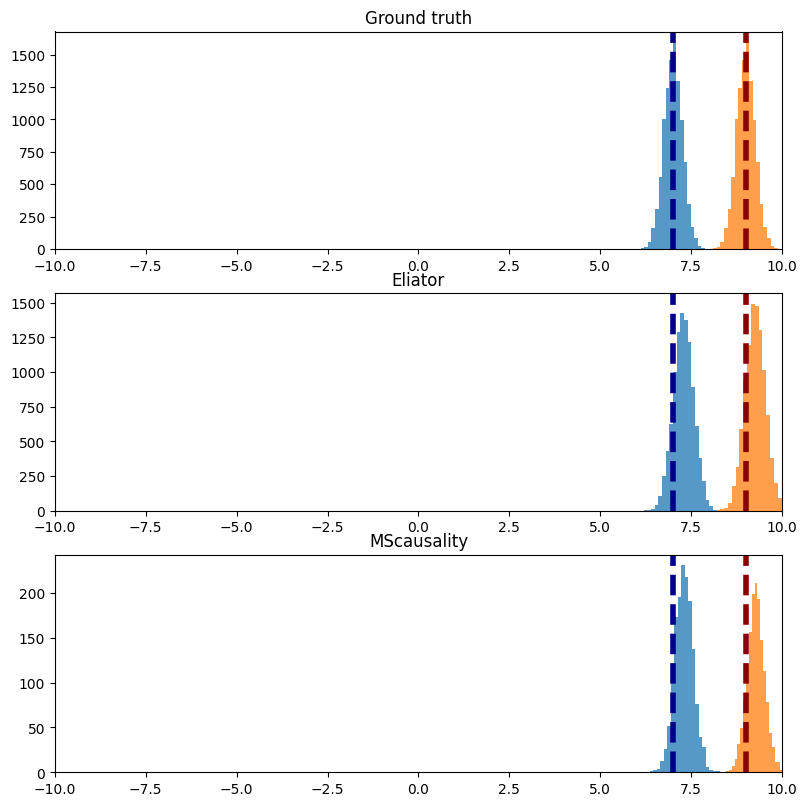

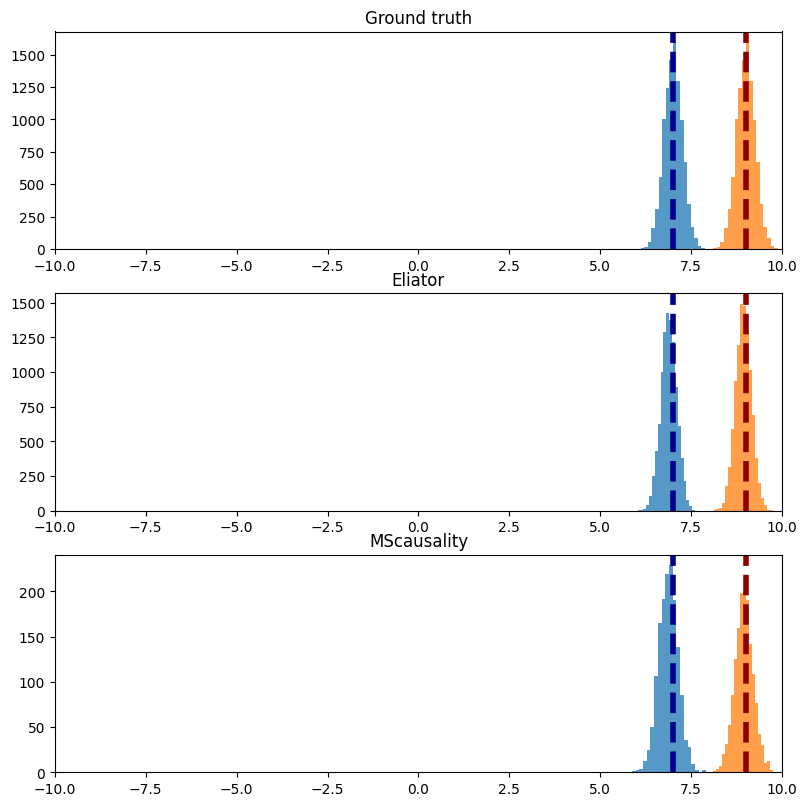

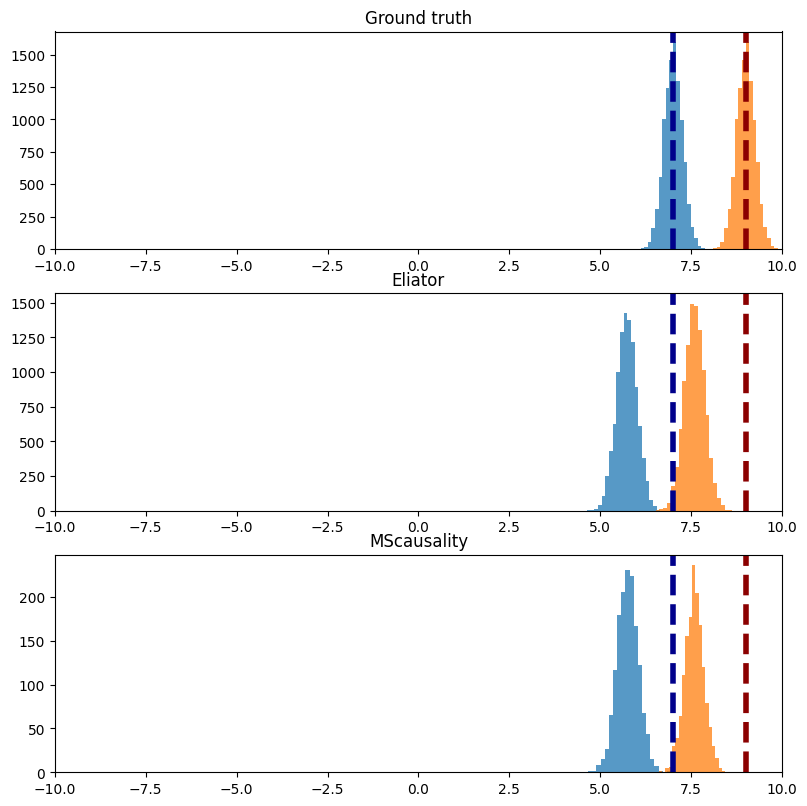

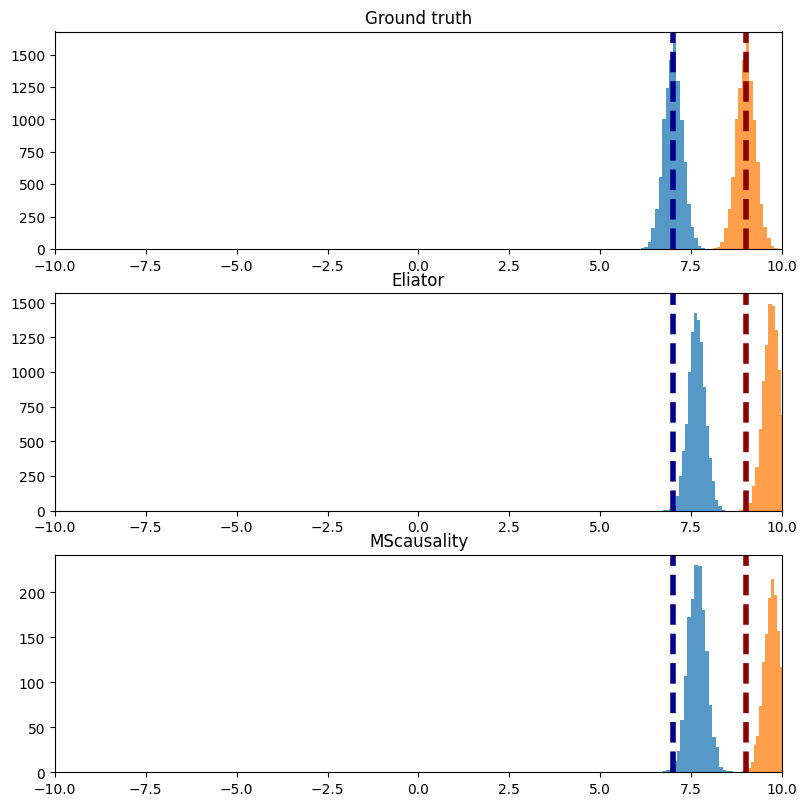

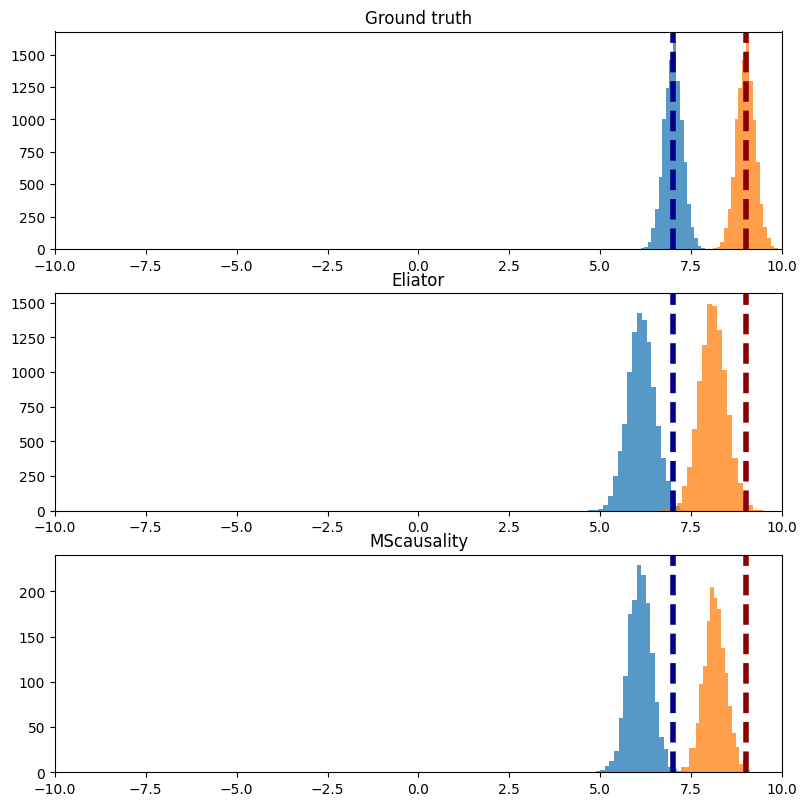

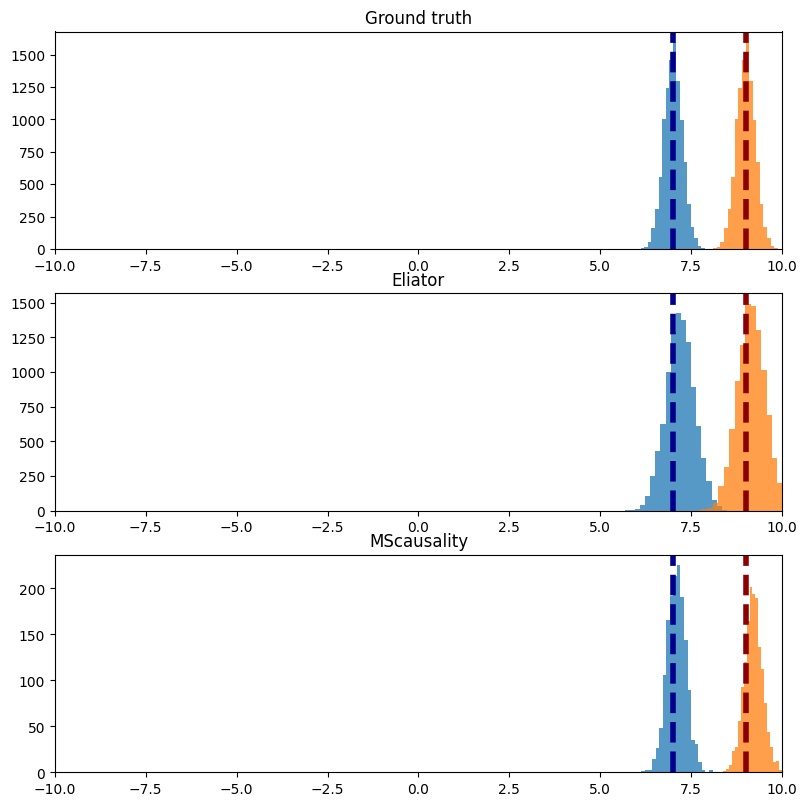

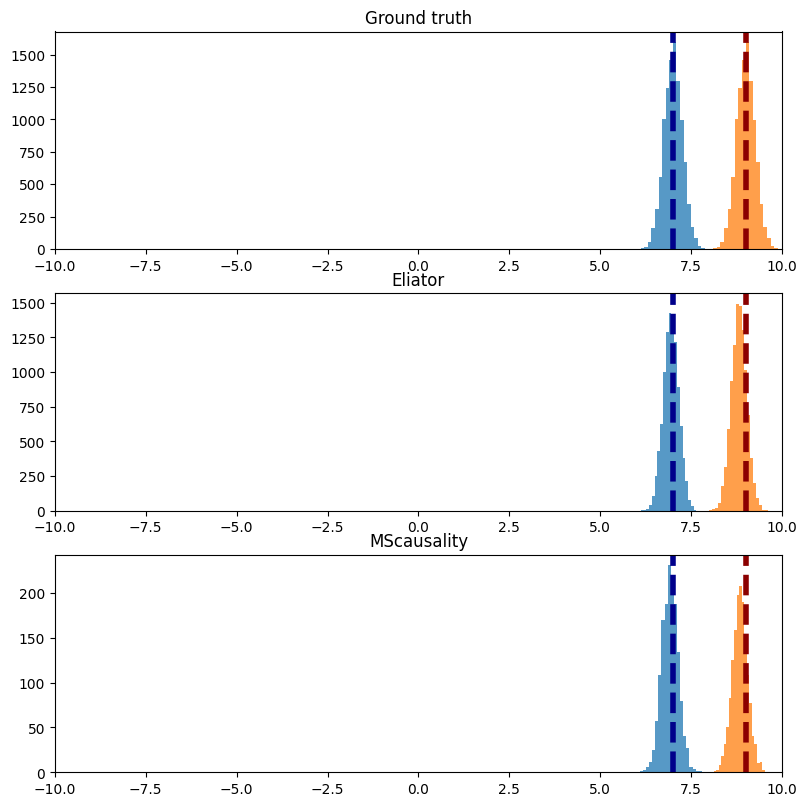

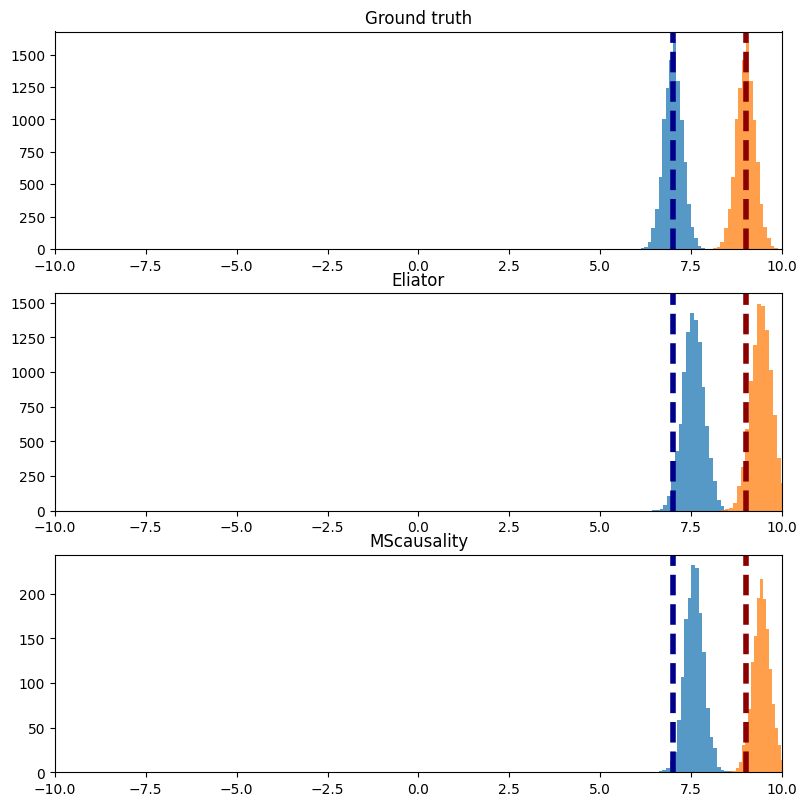

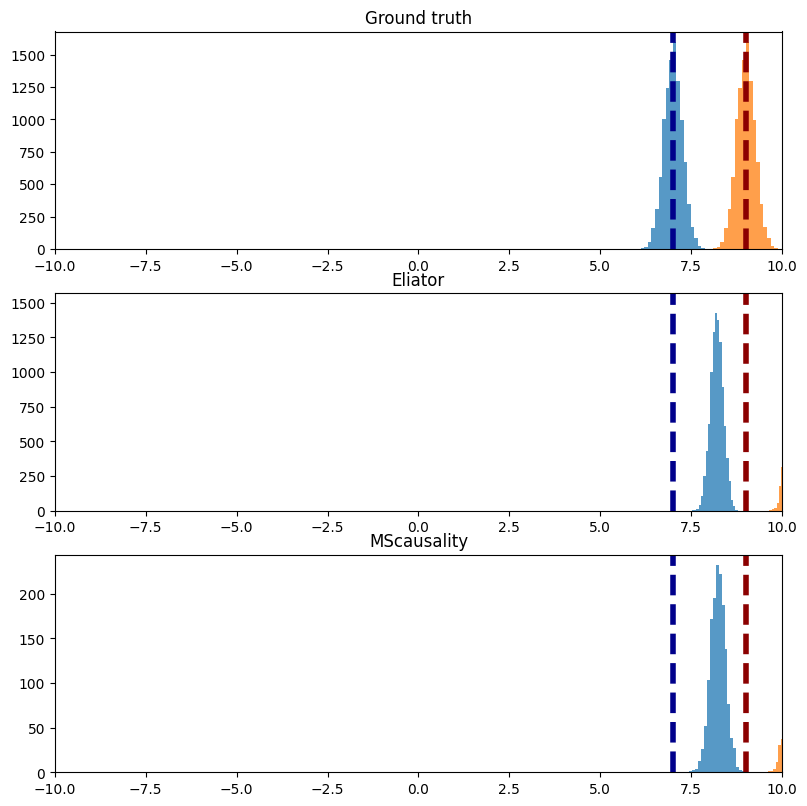

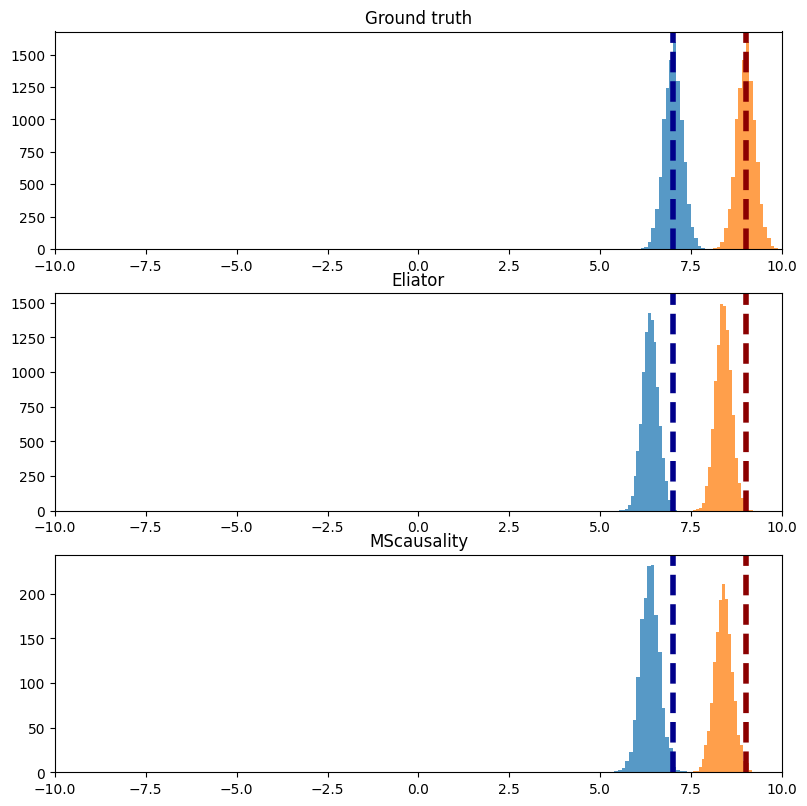

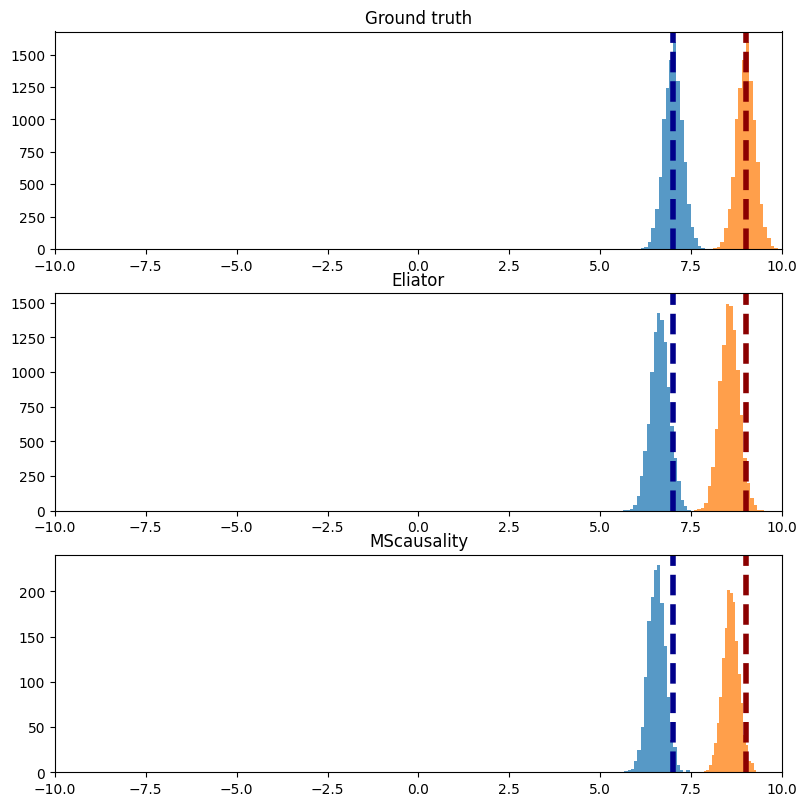

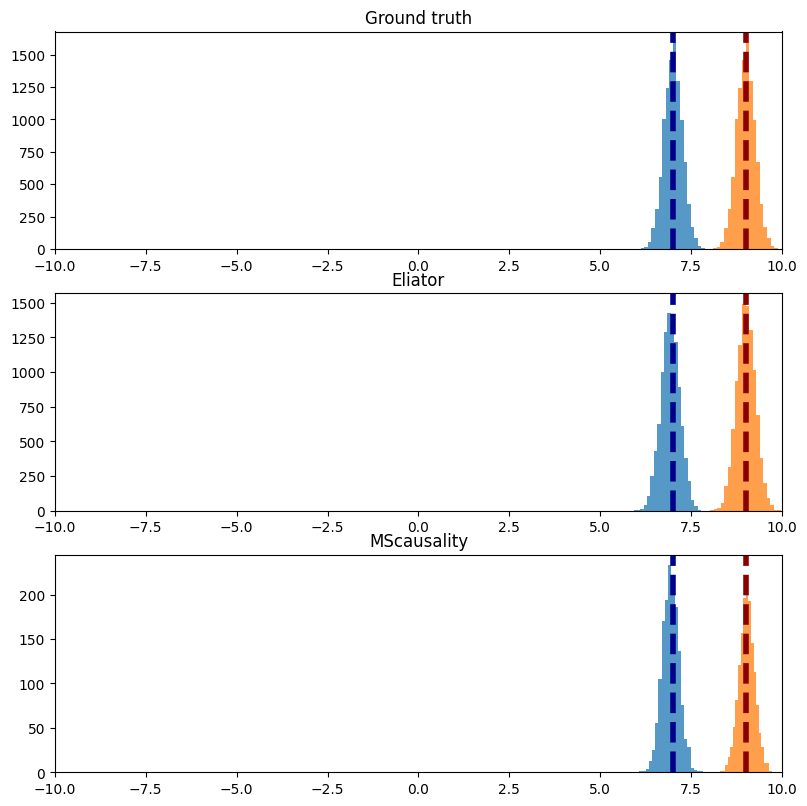

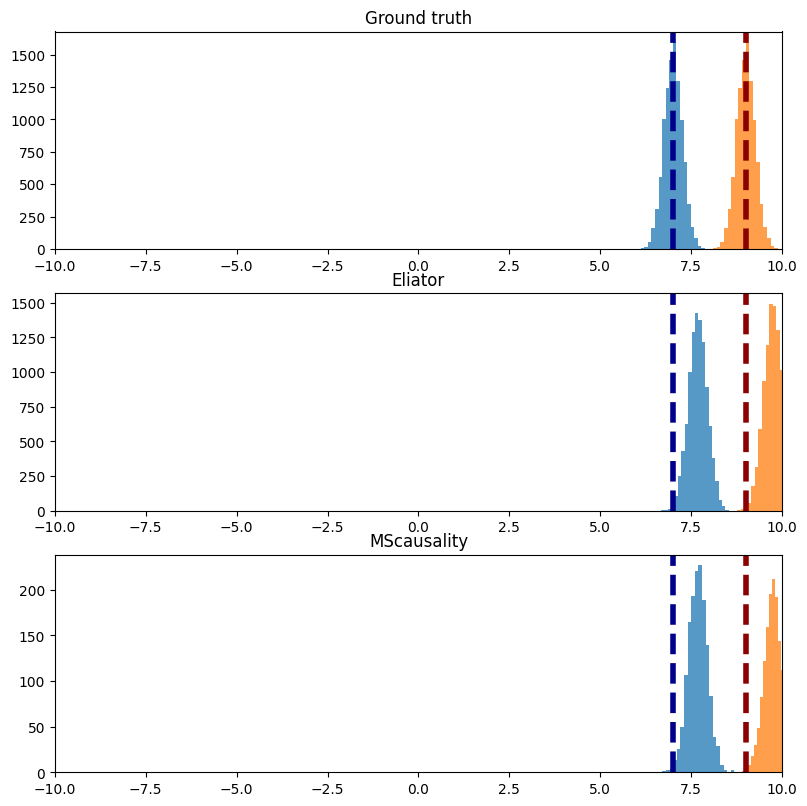

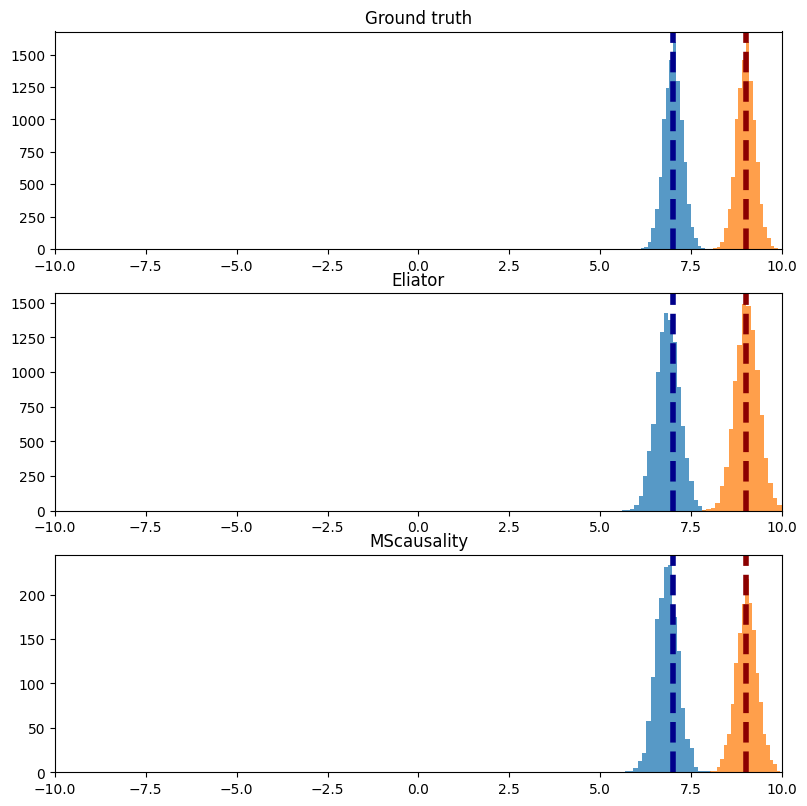

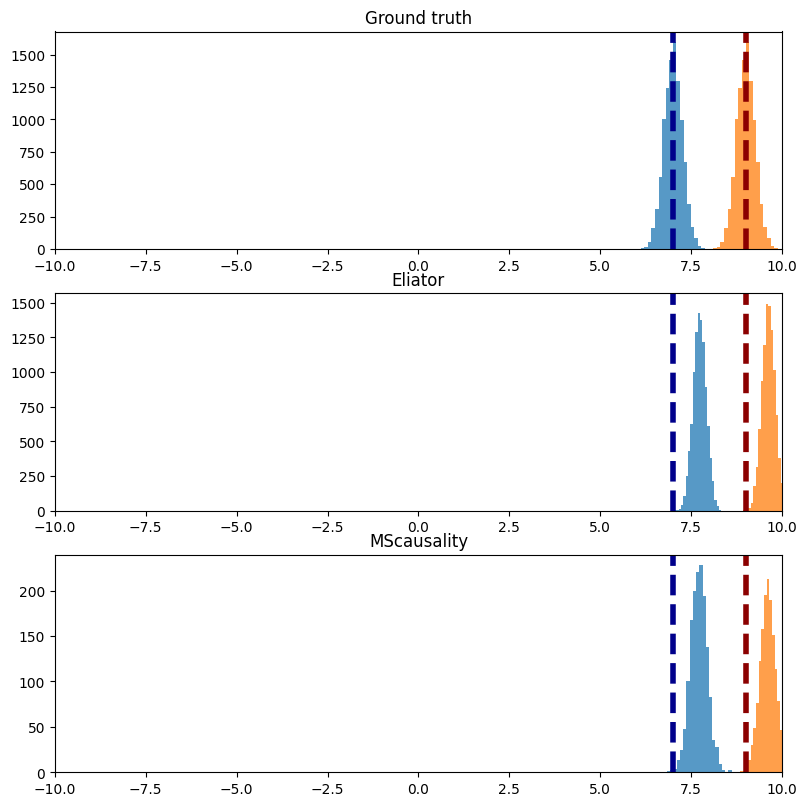

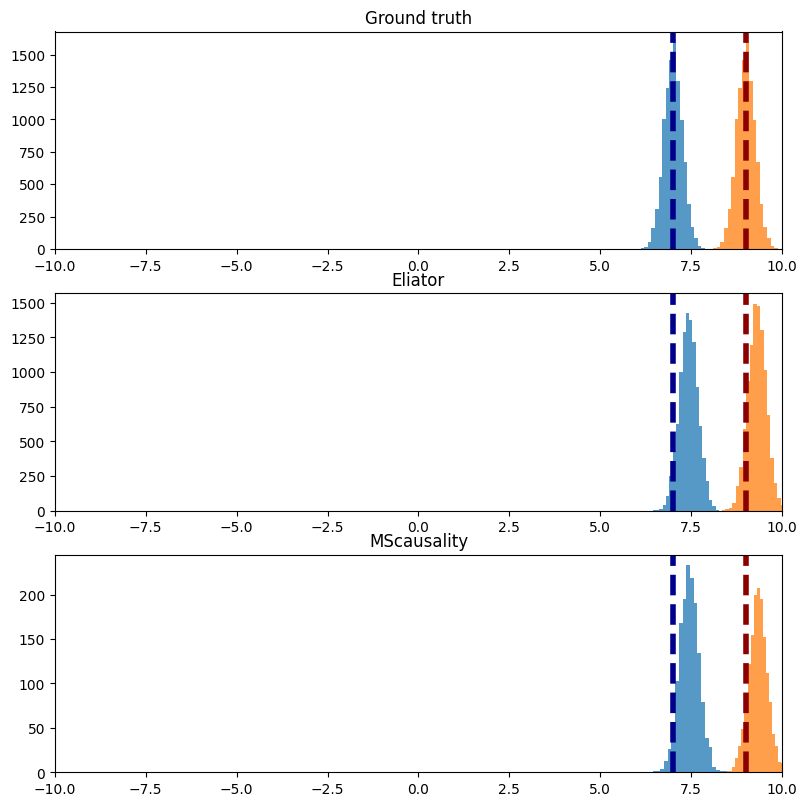

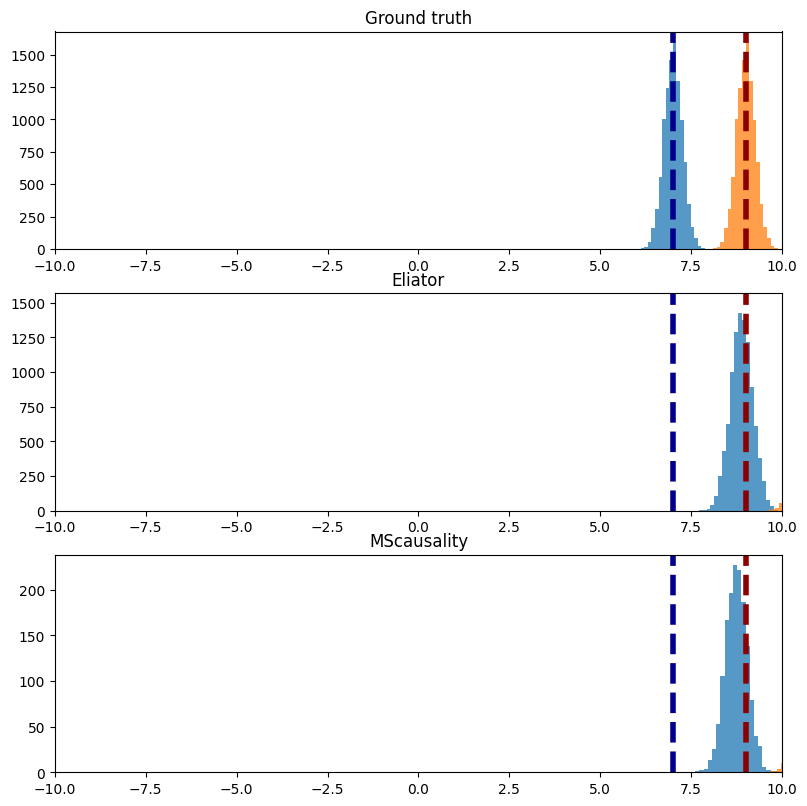

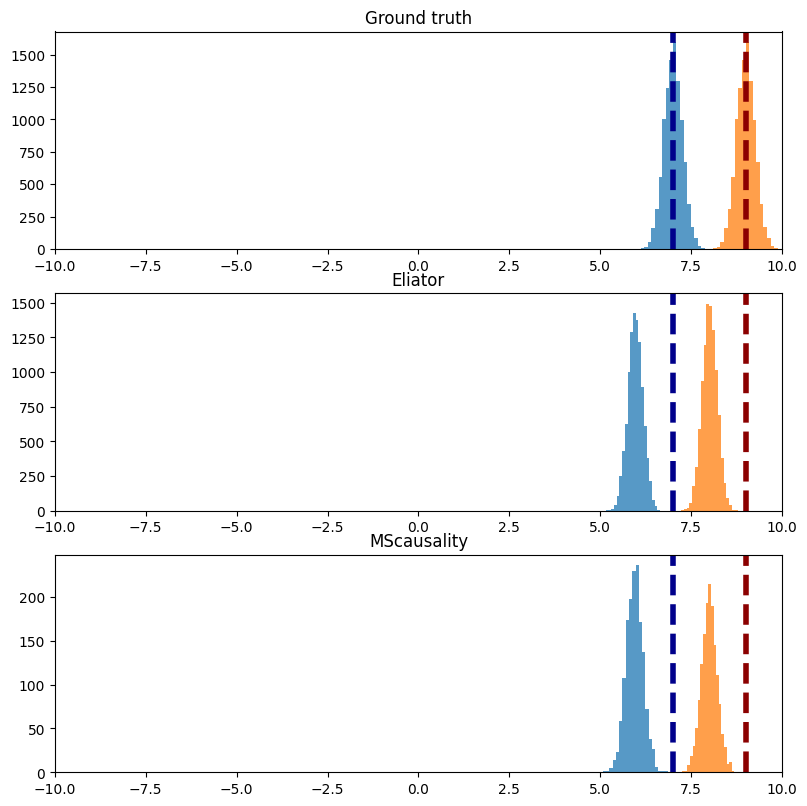

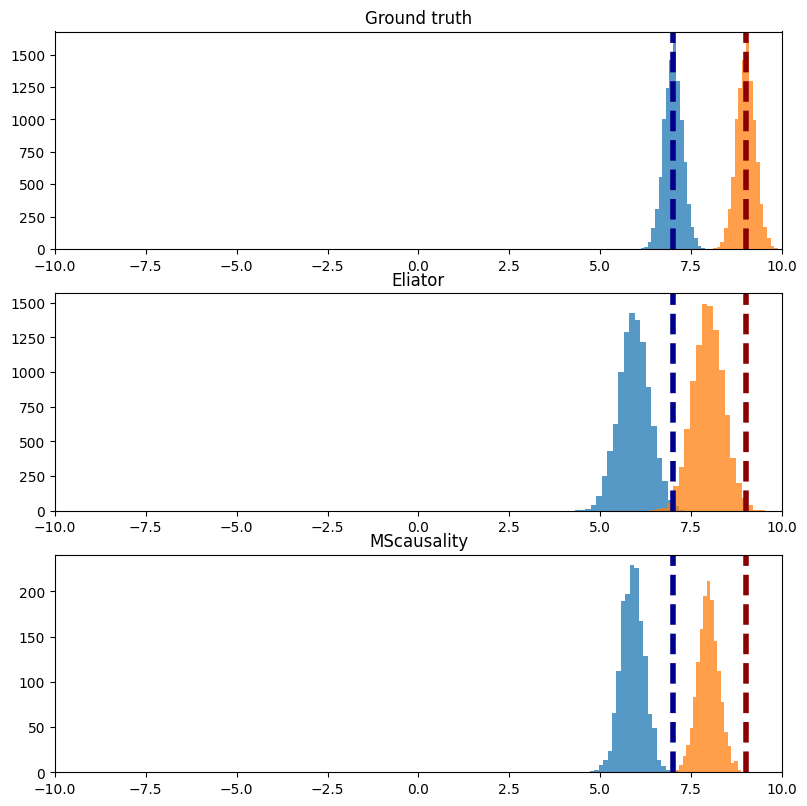

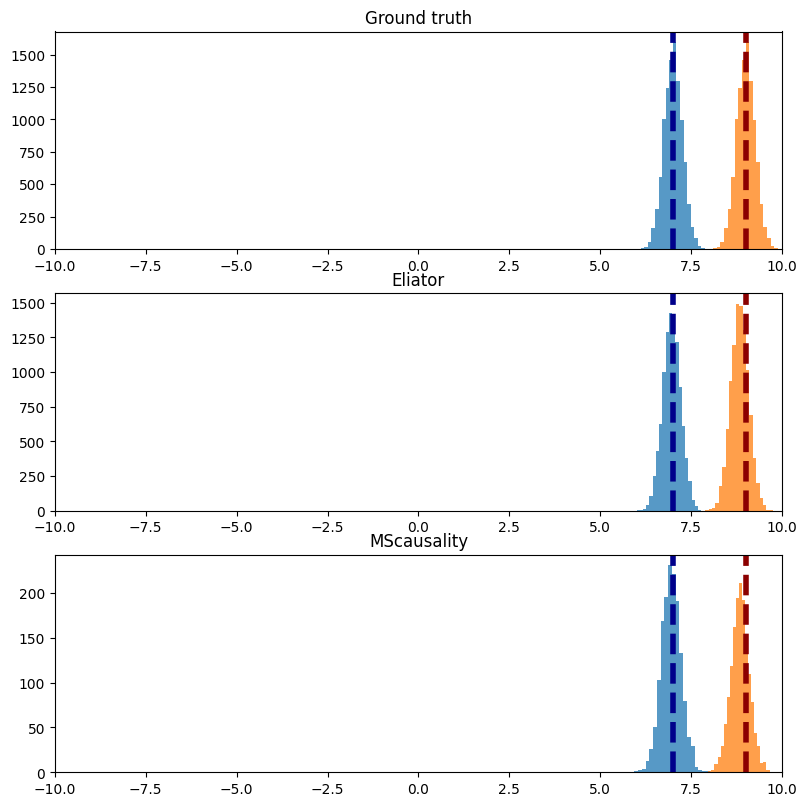

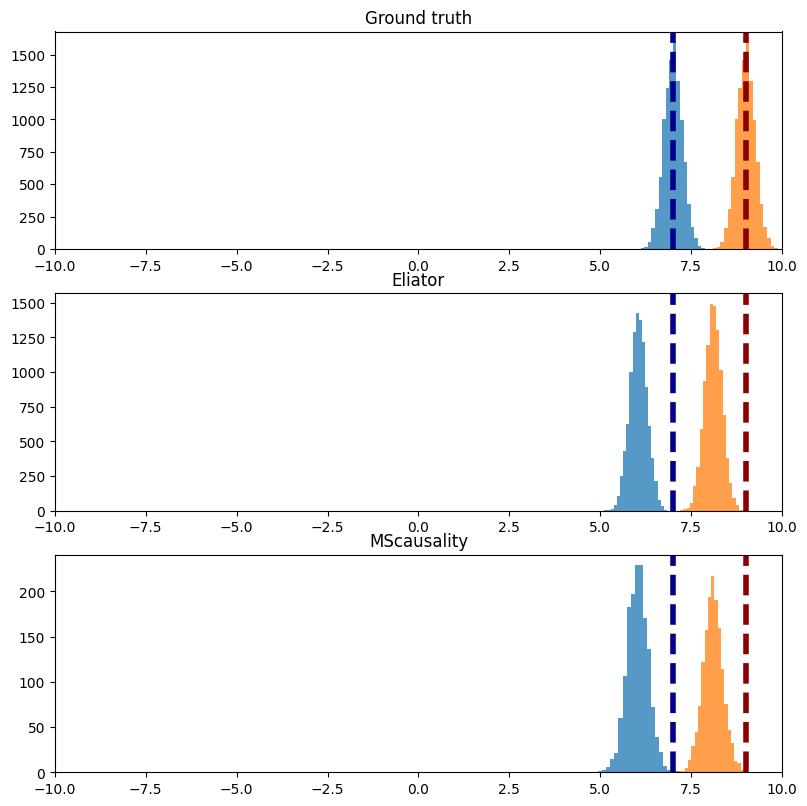

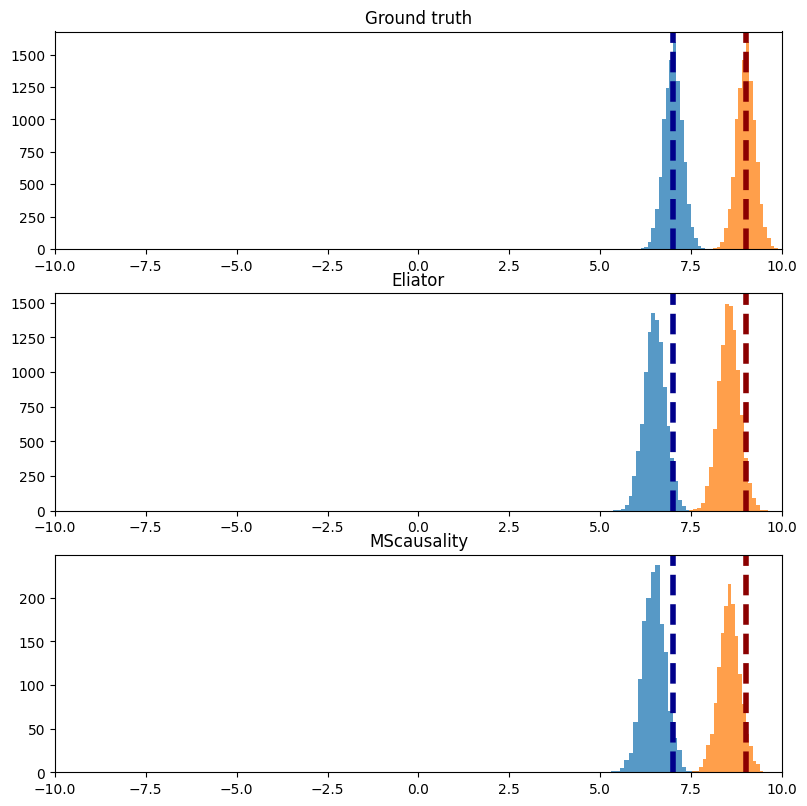

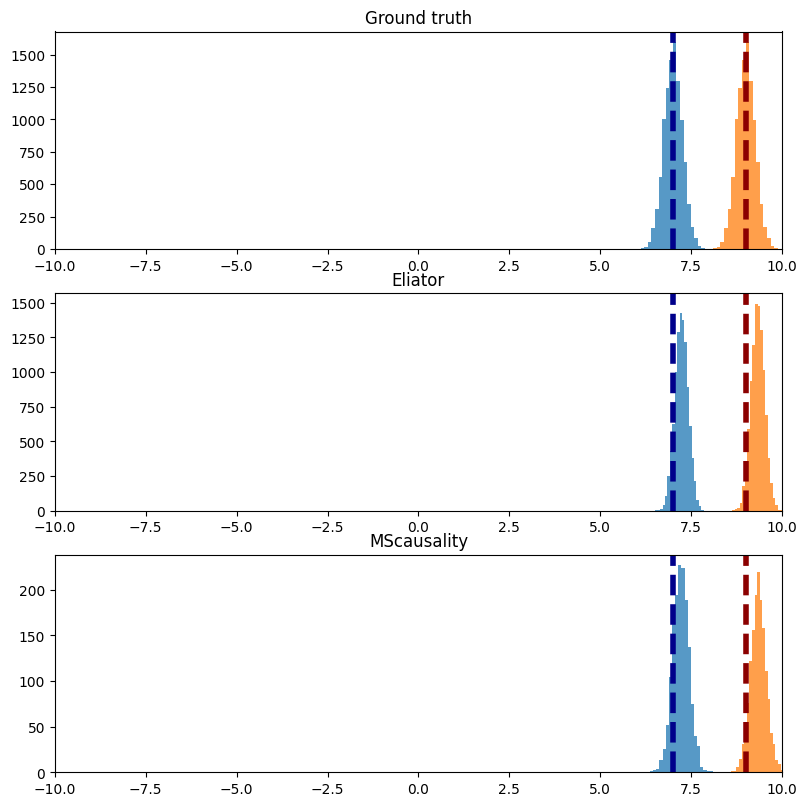

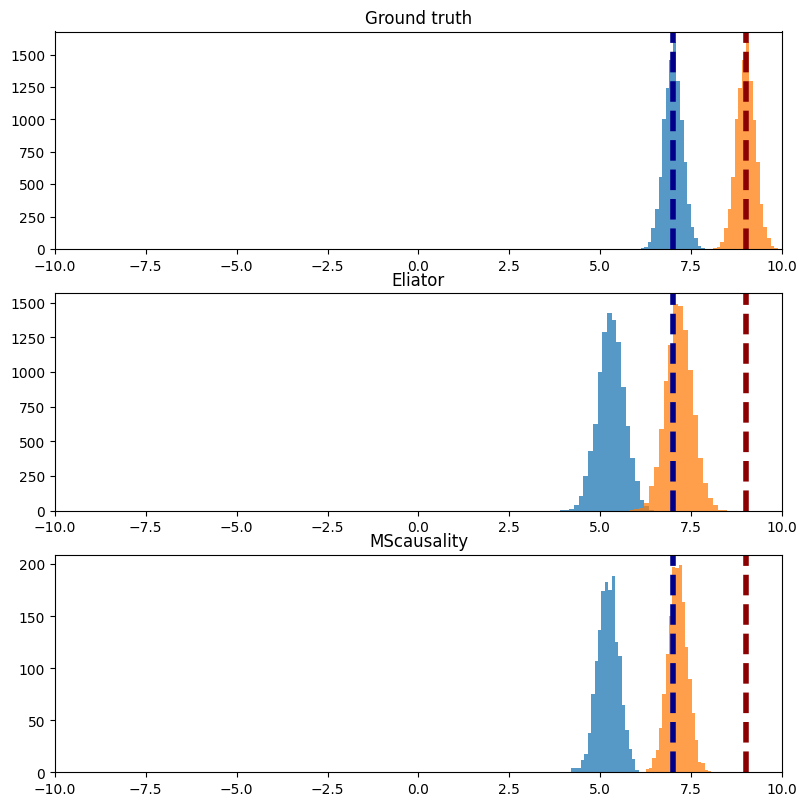

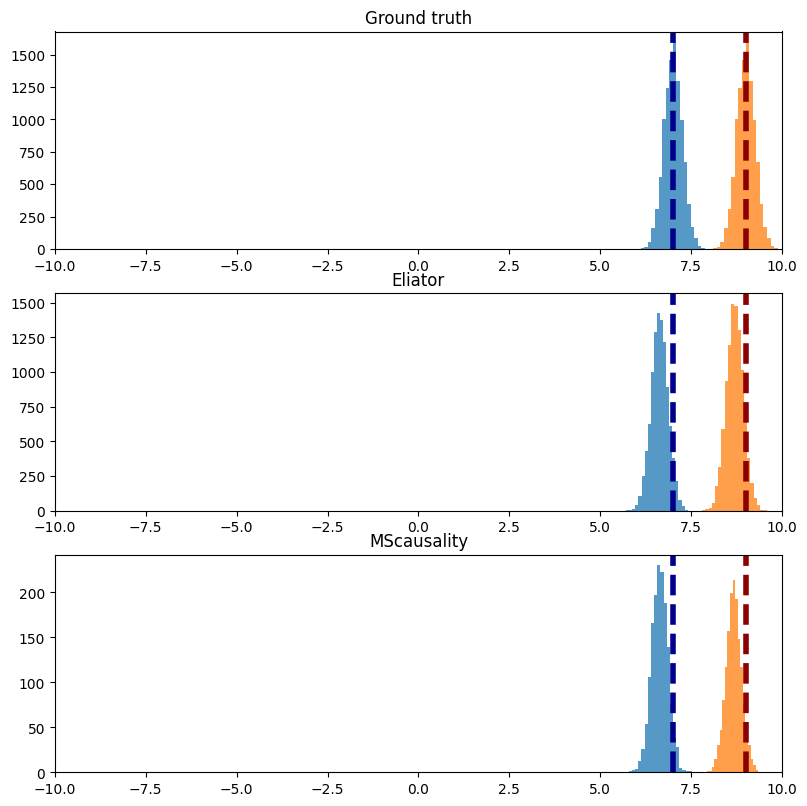

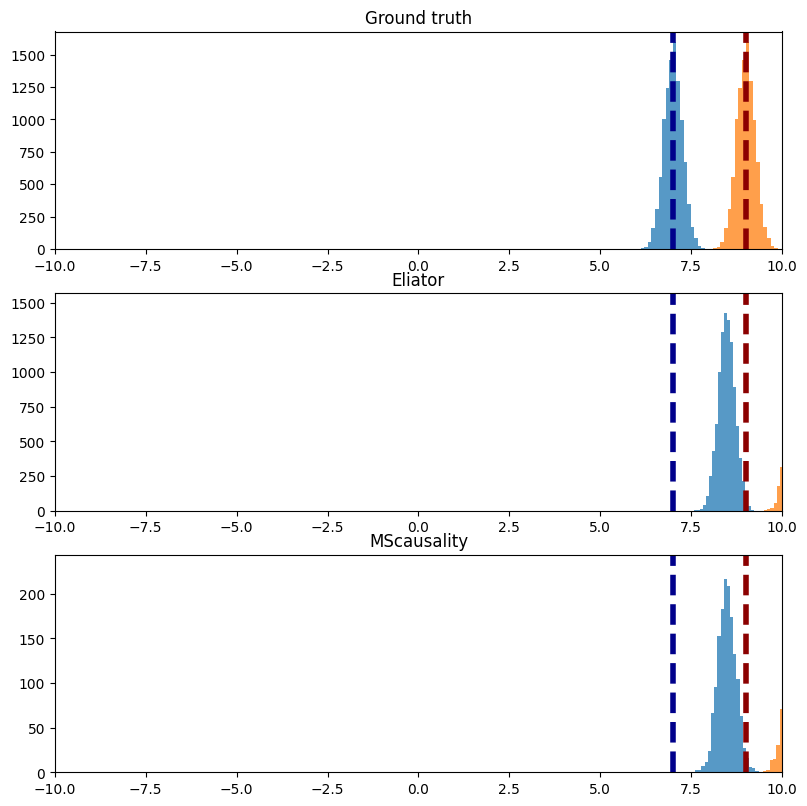

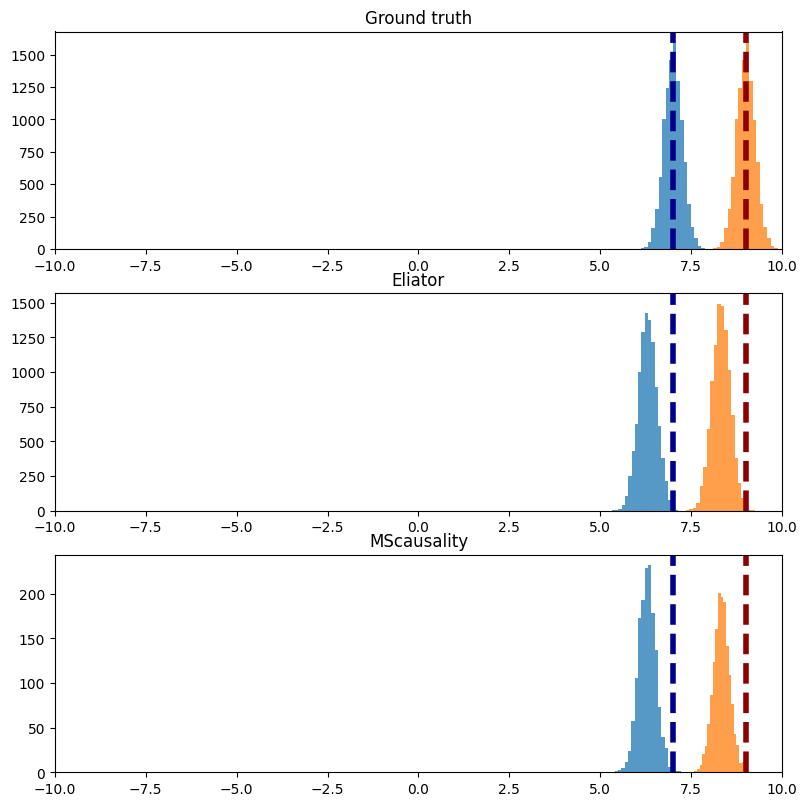

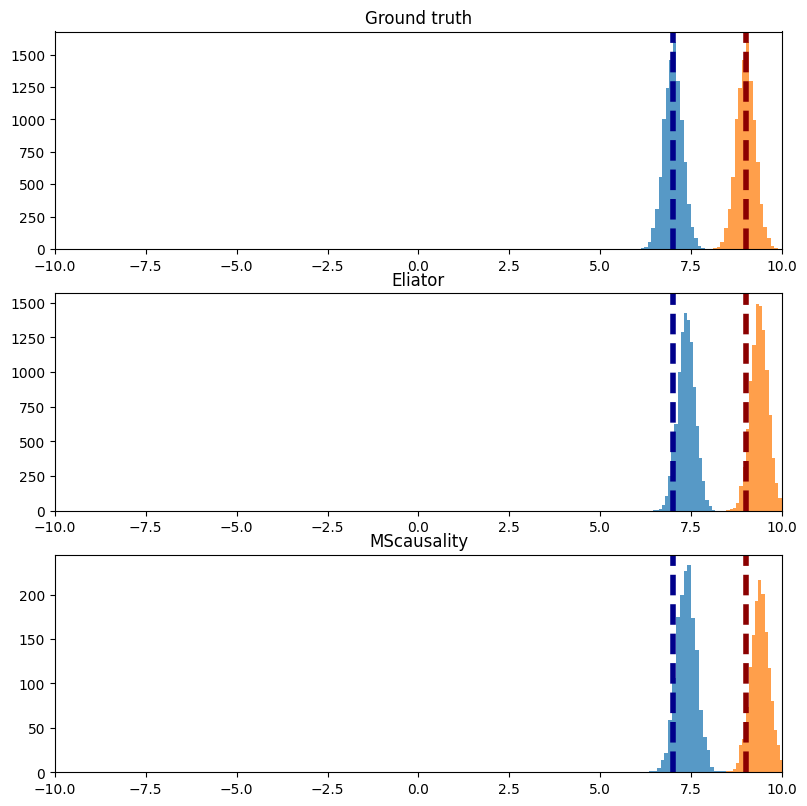

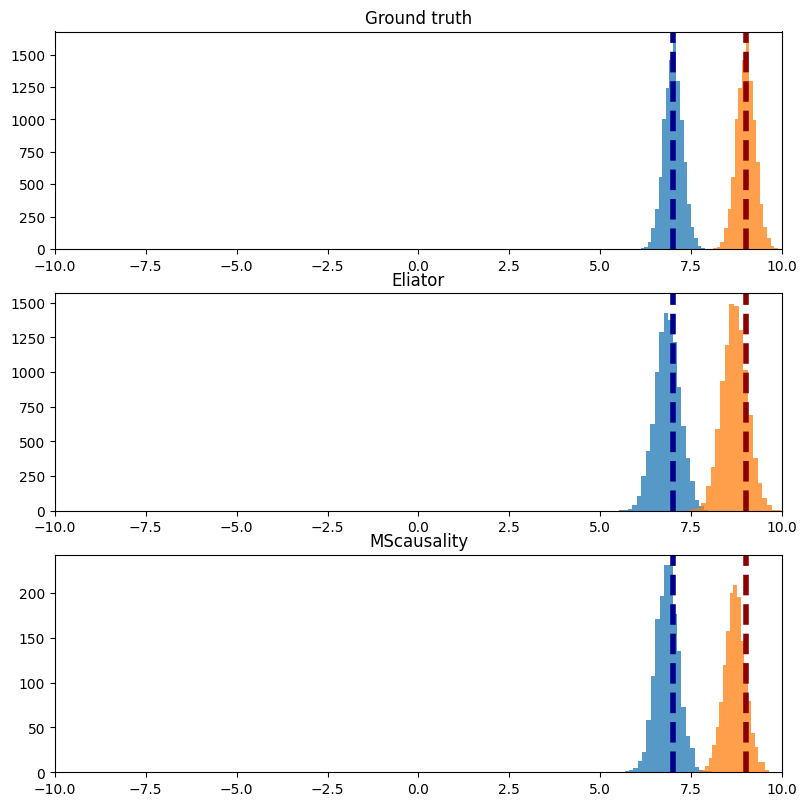

In [36]:
eliate_ate = list()
mscausality_ate = list()
eliate_var = list()
mscausality_var = list()

for i in range(100):

    sr_data = simulate_data(sr_graph, coefficients=sr_coef, 
                            add_feature_var=True, n=30, seed=i)

    sr_data = dataProcess(sr_data["Feature_data"], normalization=False, sim_data=True)
    
    result_data = comparison(sr_graph, y0_sr_graph, sr_coef, {"STAT3": 5}, 
           {"STAT3": 7}, "MYC", obs_data=sr_data)

    eliate_ate.append(result_data.loc[1, "Eliator"] - result_data.loc[0, "Eliator"])
    mscausality_ate.append(result_data.loc[1, "MScausality"] - result_data.loc[0, "MScausality"])
    eliate_var.append(result_data.loc[1, "Eliator_std"])
    mscausality_var.append(result_data.loc[1, "MScausality_std"])



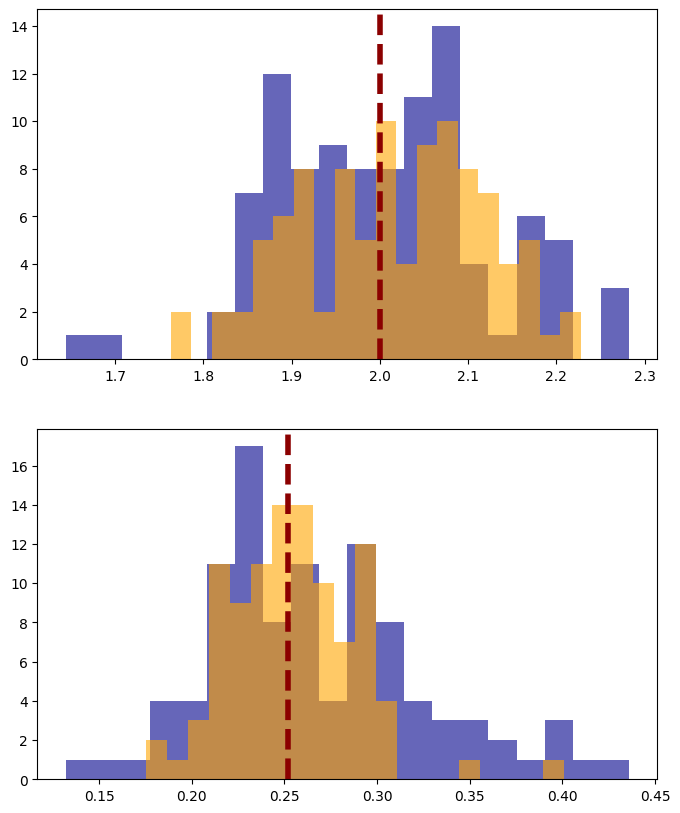

In [40]:
fig, ax = plt.subplots(2,1, figsize=(8,10))

gt = result_data.loc[1, "Ground_truth"] - result_data.loc[0, "Ground_truth"]
gt_std = result_data.loc[1, "Ground_truth_std"]

ax[0].hist(eliate_ate, color="darkblue", alpha=.6, bins=20)
ax[0].hist(mscausality_ate, color="orange", alpha=.6, bins=20)
ax[0].axvline(gt, color="darkred", linestyle="dashed", lw=4)

ax[1].hist(eliate_var, color="darkblue", alpha=.6, bins=20)
ax[1].hist(mscausality_var, color="orange", alpha=.6, bins=20)
ax[1].axvline(gt_std, color="darkred", linestyle="dashed", lw=4)

## Mediator

In [20]:
med_data = simulate_data(med_graph, coefficients=med_coef, 
                        add_feature_var=True, n=30, seed=2)
med_data["Feature_data"].to_csv("../../data/methods_paper_data/tf_sim/mediator_feature_data.csv", index=False)

simulating data...
adding feature level data...
masking data...


In [23]:
med_data = pd.read_csv("../../data/methods_paper_data/tf_sim/mediator_protein_data.csv")
med_data.head()

IL6       MYC     STAT3
0  6.624605  7.288257  6.517533
1  8.325130  7.483336  6.836141
2  5.843111  6.487663  5.906859
3  7.185746  6.999117  6.362880
4  5.437577  5.361143  5.153370

simulating data...
simulating data...
Step 0: Loss = 272.6437129091937
Step 100: Loss = 31.83920180797577
Step 200: Loss = -49.60932804644108
Step 300: Loss = -69.52688980102539
Step 400: Loss = -93.20897190272808
Step 500: Loss = -109.118253916502
Step 600: Loss = -126.14897531270981
Step 700: Loss = -117.71617171168327
Step 800: Loss = -128.71137464046478
Stopping early at step 874 with loss -144.98575776815414


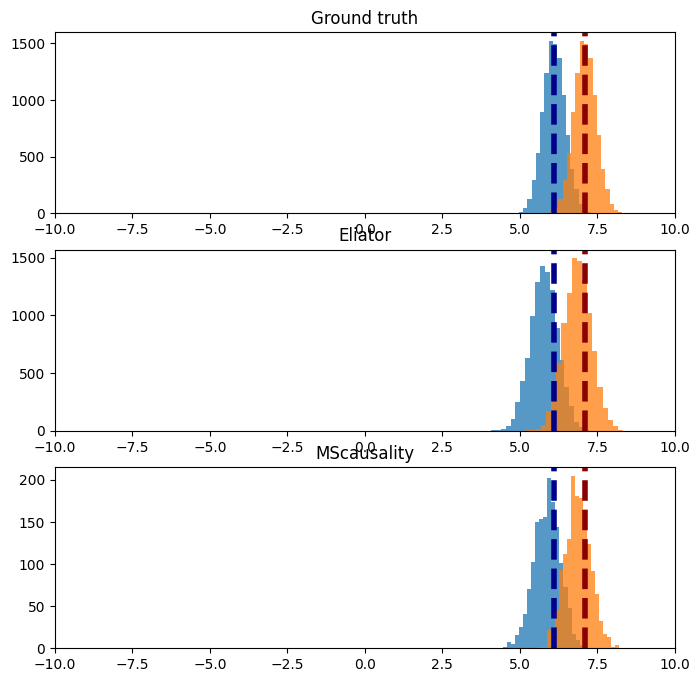

In [24]:
comparison(med_graph, y0_med_graph, med_coef, {"IL6": 5}, 
           {"IL6": 7}, "MYC", obs_data=med_data)

## Mediator with latent

In [20]:
med_lat_data = simulate_data(med_lat_graph, coefficients=med_lat_coef, 
                        add_feature_var=True, n=30, seed=2)
med_lat_data["Feature_data"].to_csv("../../data/methods_paper_data/tf_sim/mediator_latent_feature_data.csv", index=False)

simulating data...
adding feature level data...
masking data...


In [21]:
med_lat_data = pd.read_csv("../../data/methods_paper_data/tf_sim/mediator_latent_protein_data.csv")
med_lat_data.head()

C1       IL6       MYC     STAT3
0  0.209509  5.334102  6.720247  5.024507
1  0.473378  3.957424  5.544299       NaN
2  2.864700  4.909112  7.928784  5.498423
3  1.505076  4.692876  7.021710  5.033986
4  1.534168  4.841852  6.649496  5.350977

simulating data...
simulating data...
Step 0: Loss = 311.6264413446188
Step 100: Loss = -33.08746284246445
Step 200: Loss = -118.2949047088623
Step 300: Loss = -152.86597019433975
Stopping early at step 362 with loss -175.5459401011467


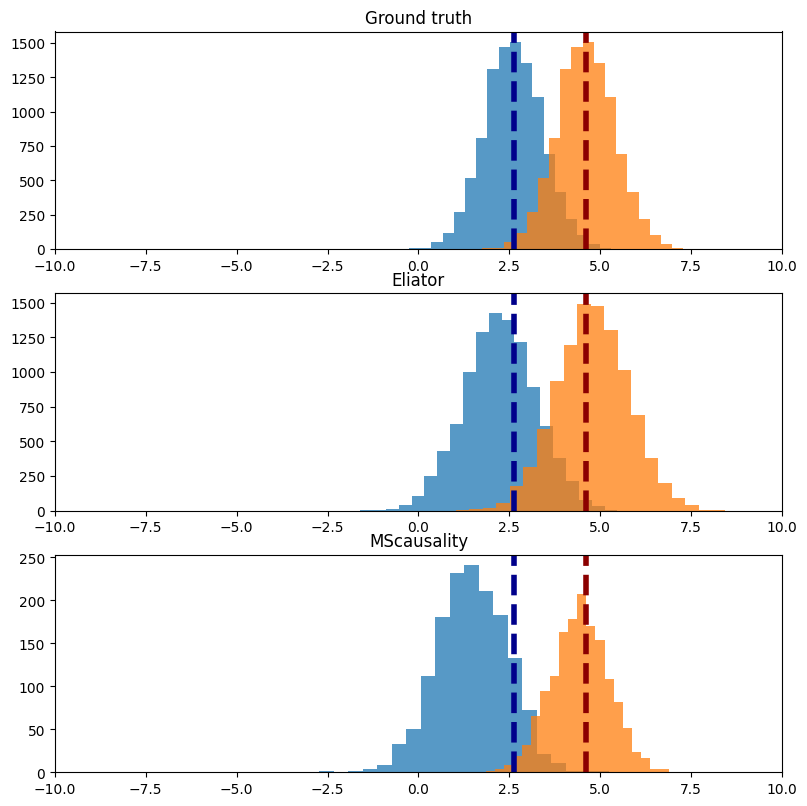

In [22]:
comparison(med_lat_graph, y0_med_lat_graph, med_lat_coef, {'IL6': -2}, {'IL6': 2}, "MYC", obs_data=med_lat_data)

## More latents!

In [ ]:
def build_tf_med_more_lat_network():
    """
    Create TF MYC graph in networkx
    
    """
    graph = nx.DiGraph()

    ## Add edges
    graph.add_edge("IL6", "STAT3")
    graph.add_edge("STAT3", "M2")
    graph.add_edge("M2", "MYC")
    
    graph.add_edge("C1", "STAT3")
    graph.add_edge("C1", "MYC")
    graph.add_edge("C2", "M2")
    graph.add_edge("C2", "MYC")
    
    return graph

def build_med_more_lat_admg(graph):

    """

    Creates acyclic directed mixed graph (ADMG) from networkx graph with latent variables.
    
    """

    ## Define obs vs latent nodes
    all_nodes = ["IL6", "STAT3", "M2", "MYC", "C1", "C2"]
    obs_nodes = ["IL6", "STAT3", "M2", "MYC"]
            
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}

    nx.set_node_attributes(graph, attrs, name="hidden")
    
    ## Use y0 to build ADMG
    mapping = dict(zip(list(graph.nodes), 
                      [Variable(i) for i in list(graph.nodes)]))
    graph = nx.relabel_nodes(graph, mapping)
    
    ## Use y0 to build ADMG
    simplified_graph = simplify_latent_dag(graph.copy(), tag="hidden")
    y0_graph = y0.graph.NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(simplified_graph.graph, "hidden")
    
    return y0_graph

med_more_lat_graph = build_tf_med_more_lat_network()
y0_more_med_lat_graph = build_med_more_lat_admg(med_more_lat_graph)

## Coefficients for relations
med_more_lat_coef = {'IL6': {'intercept': 0, "error": 1.},
            'C1': {'intercept': 0, "error": 1.},
            'C2': {'intercept': 0, "error": 1.},
            'STAT3': {'intercept': 1.6, "error": .25, 'IL6': 0.5, 'C1': .35},
            'M2': {'intercept': 1.6, "error": .25, 'STAT3': 0.5, 'C2': .6},
            'MYC': {'intercept': 2, "error": .25, 'M2': 1., 'C1': .35, 'C2':.6}
              }

simulating data...
simulating data...
simulating data...
Step 0: Loss = 7494.731795640662
Step 100: Loss = -45.733117043972015
Step 200: Loss = -1032.571386858821
Stopping early at step 242 with loss -1249.760004773736
          parameter          mean        scale
0   STAT3_intercept     1.3387204  0.028465286
1    STAT3_IL6_coef     0.5000562  0.021184882
2       STAT3_scale    -1.0697716   0.05024845
3      M2_intercept     1.1126058  0.035146754
4     M2_STAT3_coef    0.50191796  0.021457212
5          M2_scale   -0.82082474  0.043670386
6     MYC_intercept    0.34965262   0.04037617
7       MYC_M2_coef     1.4806646  0.016304327
8         MYC_scale    -0.9704578  0.043417733
9           IL6_int  -0.063298725  0.061388433
10        IL6_scale    0.09962243   0.04666827


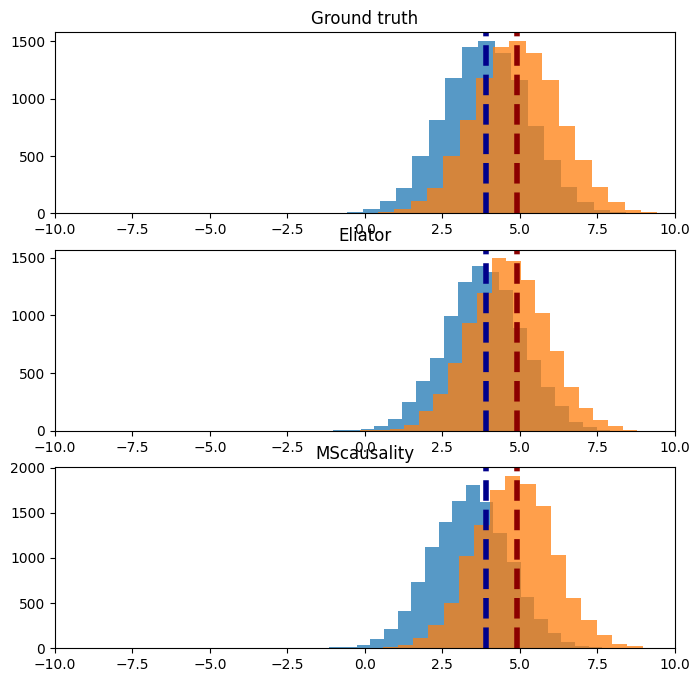

In [ ]:
comparison(med_more_lat_graph, y0_more_med_lat_graph, med_more_lat_coef, 
           {'IL6': -2}, {'IL6': 2}, "MYC", training_obs=250)

## Mediator with latent confounder

In [ ]:
def build_tf_med_lat_network():
    """
    Create TF MYC graph in networkx
    
    """
    graph = nx.DiGraph()

    ## Add edges
    graph.add_edge("IL6", "STAT3")
    graph.add_edge("STAT3", "MYC")
    
    graph.add_edge("C1", "IL6")
    graph.add_edge("C1", "MYC")
    
    return graph

def build_admg(graph):

    """

    Creates acyclic directed mixed graph (ADMG) from networkx graph with latent variables.
    
    """

    ## Define obs vs latent nodes
    all_nodes = ["IL6", "STAT3", "MYC", "C1"]
    obs_nodes = ["IL6", "STAT3", "MYC"]
            
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}

    nx.set_node_attributes(graph, attrs, name="hidden")
    
    ## Use y0 to build ADMG
    mapping = dict(zip(list(graph.nodes), 
                      [Variable(i) for i in list(graph.nodes)]))
    graph = nx.relabel_nodes(graph, mapping)
    
    ## Use y0 to build ADMG
    simplified_graph = simplify_latent_dag(graph.copy(), tag="hidden")
    y0_graph = y0.graph.NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(simplified_graph.graph, "hidden")
    
    return y0_graph

confound_lat_graph = build_tf_med_lat_network()
confound_lat_y0_graph = build_admg(confound_lat_graph)

## Coefficients for relations
confound_lat_coef = {
            'C1': {'intercept': 0, "error": 1.},
            'IL6': {'intercept': 0, "error": 1., 'C1': .9},
            'STAT3': {'intercept': 1.6, "error": .25, 'IL6': 0.5},
            'MYC': {'intercept': 2, "error": .25, 'STAT3': 1., 'C1': .9}
              }

alt_graph = y0.graph.NxMixedGraph()
alt_graph.add_directed_edge("IL6", "STAT3")
alt_graph.add_directed_edge("STAT3", "MYC")
alt_graph.add_directed_edge("IL6", "MYC")
alt_graph.add_undirected_edge("IL6", "MYC")

simulating data...
simulating data...
simulating data...
Step 0: Loss = 17449.434643259272
Step 100: Loss = -173.7238034158945
Step 200: Loss = -3133.6745622754097
Step 300: Loss = -4478.32141533494
Step 400: Loss = -5276.433055818081
Stopping early at step 437 with loss -5386.4661369249225
         parameter         mean         scale
0    IL6_intercept  -0.71887374   0.032753155
1        IL6_scale   0.08588841   0.023160635
2  STAT3_intercept     1.592915   0.008527665
3   STAT3_IL6_coef   0.49829665  0.0068366504
4      STAT3_scale   -1.3429059    0.02309161
5    MYC_intercept    0.7428574    0.02055692
6   MYC_STAT3_coef    1.5313585   0.013135699
7        MYC_scale  -0.40708688   0.022808366


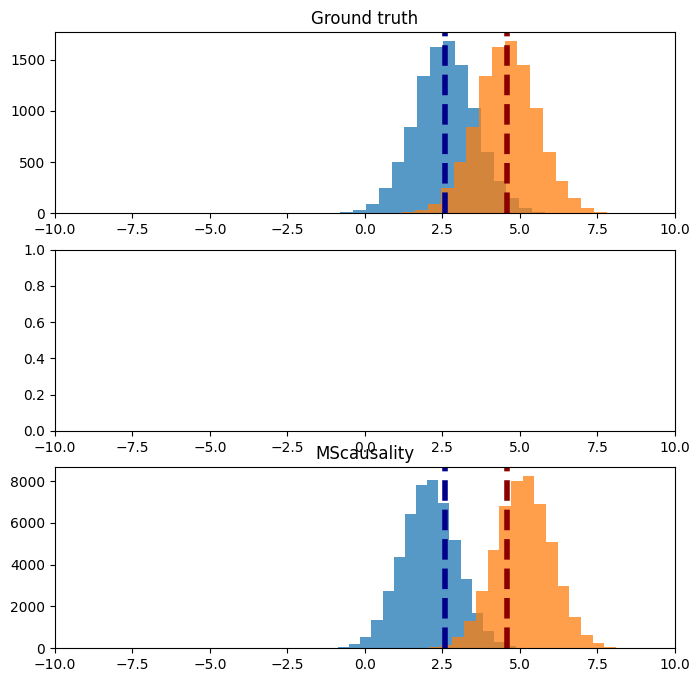

In [ ]:
comparison(confound_lat_graph, confound_lat_y0_graph, confound_lat_coef, 
           {'IL6': -2}, {'IL6': 2}, "MYC", training_obs=1000, alt_graph=None)

simulating data...
simulating data...
simulating data...
Step 0: Loss = 17391.347883095965
Step 100: Loss = -240.22616556286812
Step 200: Loss = -3172.6533222198486
Stopping early at step 281 with loss -4229.448123335838
         parameter         mean         scale
0    IL6_intercept  0.027472159   0.042093765
1        IL6_scale    0.2558112    0.02109838
2  STAT3_intercept    1.6054231    0.00995552
3   STAT3_IL6_coef    0.4997218  0.0073701697
4      STAT3_scale    -1.394317   0.027122784
5    MYC_intercept    1.7927781   0.027407428
6   MYC_STAT3_coef     1.010574   0.015180261
7     MYC_IL6_coef   0.46519786   0.016857618
8        MYC_scale  -0.36957818   0.024572663


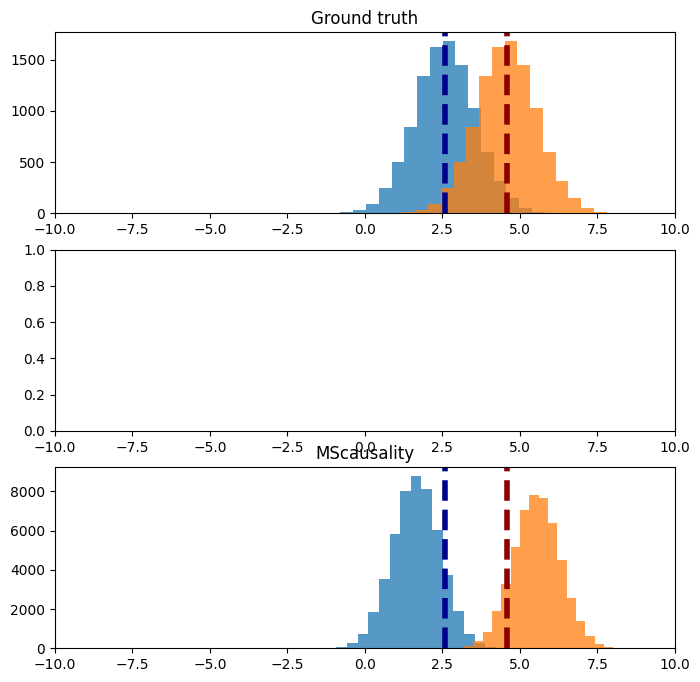

In [ ]:
comparison(confound_lat_graph, confound_lat_y0_graph, confound_lat_coef, 
           {'IL6': -2}, {'IL6': 2}, "MYC", training_obs=1000, alt_graph=alt_graph)

- Why isnt Eliator working with mediator adj
- Fix MScausality model to work with mediator

In [ ]:
obs_data = pd.DataFrame(simulate_data(confound_lat_graph, coefficients=confound_lat_coef, 
                        add_feature_var=False, n=1000, seed=2)["Protein_data"])

eliator_int_low = summary_statistics(
    confound_lat_y0_graph, obs_data,
    treatments={Variable('IL6'), Variable('STAT3')},
    outcome=Variable("MYC"),
    interventions={
        Variable('IL6'): -2})

simulating data...


MultipleTreatmentsNotImplementedError: 

In [ ]:
    from y0.dsl import Variable, X, Y
    from eliater.frontdoor_backdoor import example1
    from eliater.regression import estimate_query_by_linear_regression

    graph = example1.graph
    data = example1.generate(100, seed=100)

    estimate_query_by_linear_regression(
        graph=graph,
        data=data,
        treatments={X},
        outcome=Y,
        query_type="ate"
    )

ValueError: No valid adjustment set found for X -> Y

In [ ]:
graph.directed.edges

OutEdgeView([(X, M1), (M1, M2), (M2, Y)])

In [ ]:
graph.undirected.edges

EdgeView([(X, Y)])

simulating data...
simulating data...
Step 0: Loss = 548.4197273738682
Step 100: Loss = -48.63179591298103
Step 200: Loss = -232.1807737350464
Step 300: Loss = -323.66502672433853
Step 400: Loss = -368.54217636585236
Step 500: Loss = -407.48046347498894
Step 600: Loss = -434.153012663126
Step 700: Loss = -458.61293813586235
Step 800: Loss = -459.6974391937256
Stopping early at step 836 with loss -476.6783237159252


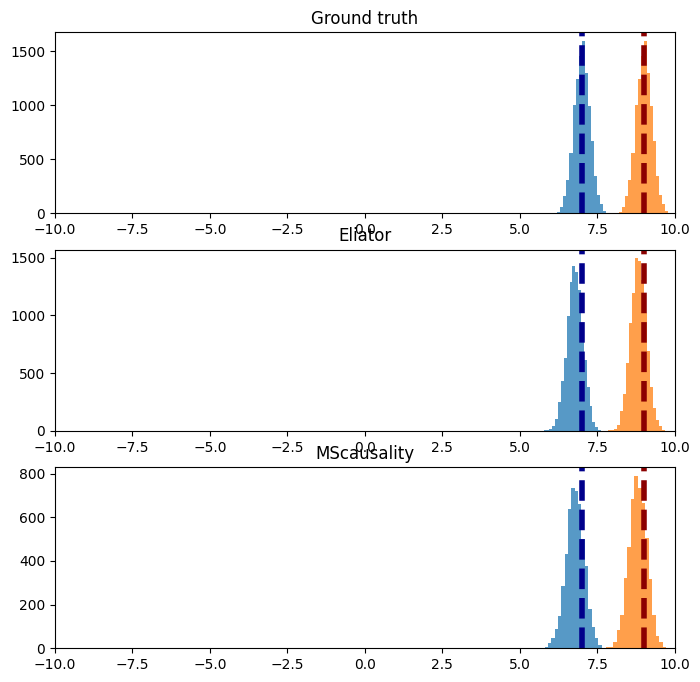

In [ ]:
comparison(sr_graph, y0_sr_graph, sr_coef, {"STAT3": 5}, 
           {"STAT3": 7}, "MYC", obs_data=sr_data)